## POS tagging using modified Viterbi

### Data Preparation

In [1]:
#Importing libraries
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

In [2]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [3]:
# Splitting into train and test
random.seed(1234)
train_set, test_set = train_test_split(nltk_data,test_size=0.05)

print(len(train_set))
print(len(test_set))
print(train_set[:40])

3718
196
[[('In', 'ADP'), ('addition', 'NOUN'), (',', '.'), ('Upjohn', 'NOUN'), ('is', 'VERB'), ('offering', 'VERB'), ('a', 'DET'), ('one-time', 'ADJ'), ('retirement', 'NOUN'), ('bonus', 'NOUN'), ('equal', 'ADJ'), ('to', 'PRT'), ('six', 'NUM'), ('months', 'NOUN'), ('of', 'ADP'), ('base', 'NOUN'), ('pay', 'NOUN'), ('.', '.')], [('Sony', 'NOUN'), ('Columbia', 'NOUN'), ('Acquisition', 'NOUN'), ('Corp.', 'NOUN'), (',', '.'), ('formed', 'VERB'), ('*', 'X'), ('for', 'ADP'), ('the', 'DET'), ('Columbia', 'NOUN'), ('deal', 'NOUN'), (',', '.'), ('will', 'VERB'), ('formally', 'ADV'), ('take', 'VERB'), ('ownership', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('movie', 'NOUN'), ('studio', 'NOUN'), ('later', 'ADJ'), ('this', 'DET'), ('month', 'NOUN'), (',', '.'), ('a', 'DET'), ('spokesman', 'NOUN'), ('said', 'VERB'), ('0', 'X'), ('*T*-1', 'X'), ('.', '.')], [('The', 'DET'), ('Artist', 'NOUN'), ('hangs', 'VERB'), ('out', 'PRT'), ('in', 'ADP'), ('Greenwich', 'NOUN'), ('Village', 'NOUN'), (',', '.'), ('on

In [6]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95735

In [7]:
# tokens 
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['In',
 'addition',
 ',',
 'Upjohn',
 'is',
 'offering',
 'a',
 'one-time',
 'retirement',
 'bonus']

In [8]:
# vocabulary
V = set(tokens)
print(len(V))

12091


In [9]:
# number of tags
T = set([pair[1] for pair in train_tagged_words])
len(T)

12

In [10]:
print(T)

{'NOUN', 'CONJ', 'NUM', 'ADP', 'ADV', 'DET', 'VERB', 'PRT', 'ADJ', 'PRON', 'X', '.'}


### Build the vanilla Viterbi based POS tagger

In [11]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [12]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [13]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [14]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)
tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [15]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

In [16]:
tags_df.loc['.', :]

NOUN    0.222701
CONJ    0.058010
NUM     0.080280
ADP     0.089978
ADV     0.053161
DET     0.173491
VERB    0.088991
PRT     0.002335
ADJ     0.044001
PRON    0.065643
X       0.027658
.       0.093660
Name: ., dtype: float32

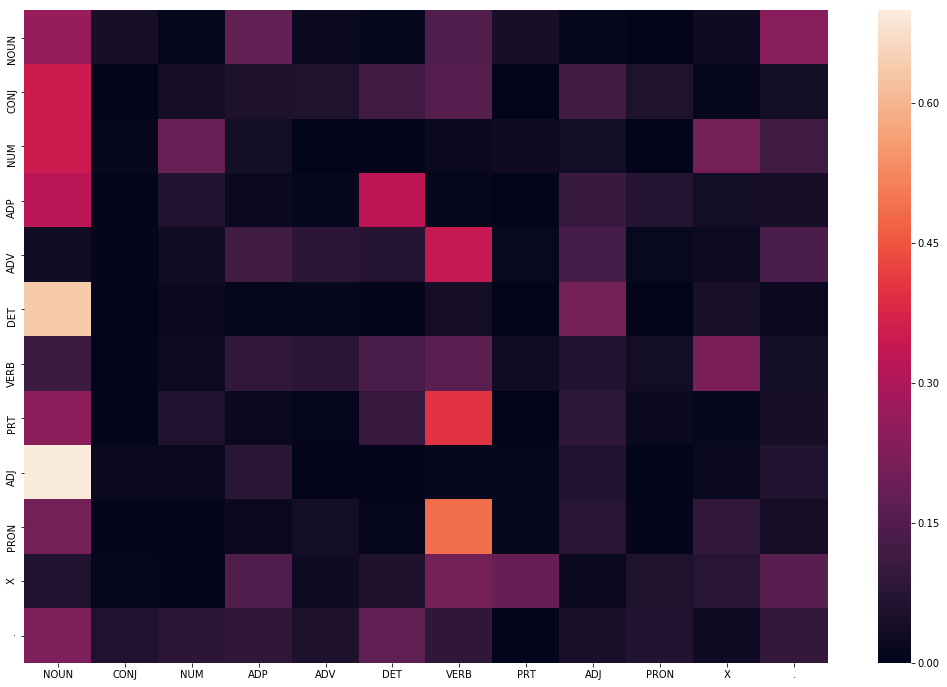

In [17]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()

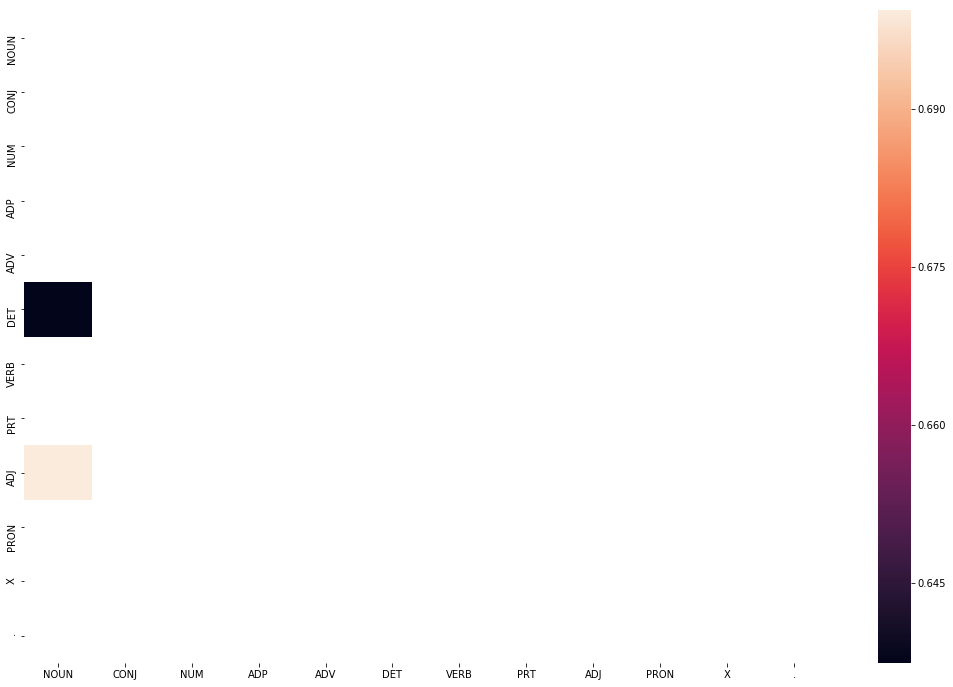

In [18]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

In [19]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [20]:
with open('Test_sentences_1.txt','r',encoding='utf8') as f:
    test_set = f.read()
# list of untagged words
sent_text = nltk.sent_tokenize(str(test_set))
print(sent_text)

['Android is a mobile operating system developed by Google.', 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.', "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.", 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.', 'Before entering politics, Donald Trump was a domineering businessman and a television personality.', 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.', 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.', 'Show me the cheapest round trips from Dallas to Atlanta\nI would like to see flights from Denver to Philadelphia.', 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.', 'NASA invited social media users to experience the launch

In [21]:
# now loop over each sentence and tokenize it separately
start = time.time()
tagged_data = []
for sentence in sent_text:
    tokenized_text = nltk.word_tokenize(sentence)
    #print(tokenized_text)
    tagged = Viterbi(tokenized_text)
    tagged_data.append(tagged)
    print(tagged)
end = time.time()
difference = end-start
print("Time taken in seconds: ", difference)

[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.')]
[('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'NOUN'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'NOUN'), ('since', 'ADP'), ('2011', 'NOUN'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NOUN'), ('.', '.')]
[('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NOUN'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ("'s", 'PRT'), ('firehose', 'NOUN'), ('.', '.')]
[('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'D

### Solve the problem of unknown words

In [22]:
a = []
nltk_word =[]
for i in range(len(nltk_data)):
    a.append([pair[0] for pair in nltk_data[i]])
for list in a:
    for word in list:
        nltk_word.append(word) 

In [23]:
b = []
tagged_word =[]
for i in range(len(tagged_data)):
    b.append([pair[0] for pair in tagged_data[i]])
for list in b:
    for word in list:
        tagged_word.append(word) 

In [24]:
#Finding the unknown keywords
unknownwords = set(tagged_word).union(set(nltk_word))  - set(tagged_word).intersection(set(nltk_word)) - set(nltk_word)

In [25]:
unknownwords = [ k for k in unknownwords]
print(unknownwords)

['invited', '21st', 'Google', '2018', '2015', '2011', 'online', 'trips', 'FIFA', '2013', 'firehose', 'Twitter', 'personality', 'ICESAT-2', 'NASA', 'OS', 'domineering', 'Satellite', 'tweets', 'worldwide', 'tournament', 'arriving', 'interact', 'Cup', 'contested', 'smartphones', 'Android', 'messages']


In [ ]:
c = []
tagged =[]
unknownword = []
for i in range(len(tagged_data)):
    c.append([pair for pair in tagged_data[i]])
    #print(c)
for list in c:
    for word in list:
        tagged.append(word)
        #print(tagged)
for tag in tagged:
    print(tag)
    tagged.append(tag)
    for word in unknownwords:
        if word in tag:
            #print(tag)
            unknownword.append(tag)
#print(unknownword)
#print(tagged)

('Android', 'NOUN')
('is', 'VERB')
('a', 'DET')
('mobile', 'ADJ')
('operating', 'NOUN')
('system', 'NOUN')
('developed', 'VERB')
('by', 'ADP')
('Google', 'NOUN')
('.', '.')
('Android', 'NOUN')
('has', 'VERB')
('been', 'VERB')
('the', 'DET')
('best-selling', 'NOUN')
('OS', 'NOUN')
('worldwide', 'NOUN')
('on', 'ADP')
('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOUN')
('and', 'CONJ')
('on', 'ADP')
('tablets', 'NOUN')
('since', 'ADP')
('2013', 'NOUN')
('.', '.')
('Google', 'NOUN')
('and', 'CONJ')
('Twitter', 'NOUN')
('made', 'VERB')
('a', 'DET')
('deal', 'NOUN')
('in', 'ADP')
('2015', 'NOUN')
('that', 'ADP')
('gave', 'VERB')
('Google', 'NOUN')
('access', 'NOUN')
('to', 'PRT')
('Twitter', 'NOUN')
("'s", 'PRT')
('firehose', 'NOUN')
('.', '.')
('Twitter', 'NOUN')
('is', 'VERB')
('an', 'DET')
('online', 'NOUN')
('news', 'NOUN')
('and', 'CONJ')
('social', 'ADJ')
('networking', 'NOUN')
('service', 'NOUN')
('on', 'ADP')
('which', 'DET')
('users', 'NOUN')
('post', 'NOUN')
('and', 'CONJ')
('

('television', 'NOUN')
('personality', 'NOUN')
('.', '.')
('The', 'DET')
('2018', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
('is', 'VERB')
('the', 'DET')
('21st', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an', 'DET')
('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'NOUN')
('that', 'ADP')
('it', 'PRON')
('has', 'VERB')
('been', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Europe', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('cheapest', 'ADJ')
('round', 'NOUN')
('trips', 'NOUN')
('from', 'ADP')
('Dallas', 'NOUN')
('to', 'PRT')
('Atlanta', 'NOUN')
('I', 'PRO

('users', 'NOUN')
('to', 'PRT')
('experience', 'NOUN')
('the', 'DET')
('launch', 'NOUN')
('of', 'ADP')
('ICESAT-2', 'NOUN')
('Satellite', 'NOUN')
('.', '.')
('Android', 'NOUN')
('is', 'VERB')
('a', 'DET')
('mobile', 'ADJ')
('operating', 'NOUN')
('system', 'NOUN')
('developed', 'VERB')
('by', 'ADP')
('Google', 'NOUN')
('.', '.')
('Android', 'NOUN')
('has', 'VERB')
('been', 'VERB')
('the', 'DET')
('best-selling', 'NOUN')
('OS', 'NOUN')
('worldwide', 'NOUN')
('on', 'ADP')
('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOUN')
('and', 'CONJ')
('on', 'ADP')
('tablets', 'NOUN')
('since', 'ADP')
('2013', 'NOUN')
('.', '.')
('Google', 'NOUN')
('and', 'CONJ')
('Twitter', 'NOUN')
('made', 'VERB')
('a', 'DET')
('deal', 'NOUN')
('in', 'ADP')
('2015', 'NOUN')
('that', 'ADP')
('gave', 'VERB')
('Google', 'NOUN')
('access', 'NOUN')
('to', 'PRT')
('Twitter', 'NOUN')
("'s", 'PRT')
('firehose', 'NOUN')
('.', '.')
('Twitter', 'NOUN')
('is', 'VERB')
('an', 'DET')
('online', 'NOUN')
('news', 'NOUN')
('an

('is', 'VERB')
('the', 'DET')
('21st', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an', 'DET')
('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'NOUN')
('that', 'ADP')
('it', 'PRON')
('has', 'VERB')
('been', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Europe', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('cheapest', 'ADJ')
('round', 'NOUN')
('trips', 'NOUN')
('from', 'ADP')
('Dallas', 'NOUN')
('to', 'PRT')
('Atlanta', 'NOUN')
('I', 'PRON')
('would', 'VERB')
('like', 'ADP')
('to', 'PRT')
('see', 'VERB')
('flights', 'NOUN')
('from', 'ADP')
('Denver', 'NOUN')
('to', 'PRT')
('Ph

('.', '.')
('Android', 'NOUN')
('is', 'VERB')
('a', 'DET')
('mobile', 'ADJ')
('operating', 'NOUN')
('system', 'NOUN')
('developed', 'VERB')
('by', 'ADP')
('Google', 'NOUN')
('.', '.')
('Android', 'NOUN')
('has', 'VERB')
('been', 'VERB')
('the', 'DET')
('best-selling', 'NOUN')
('OS', 'NOUN')
('worldwide', 'NOUN')
('on', 'ADP')
('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOUN')
('and', 'CONJ')
('on', 'ADP')
('tablets', 'NOUN')
('since', 'ADP')
('2013', 'NOUN')
('.', '.')
('Google', 'NOUN')
('and', 'CONJ')
('Twitter', 'NOUN')
('made', 'VERB')
('a', 'DET')
('deal', 'NOUN')
('in', 'ADP')
('2015', 'NOUN')
('that', 'ADP')
('gave', 'VERB')
('Google', 'NOUN')
('access', 'NOUN')
('to', 'PRT')
('Twitter', 'NOUN')
("'s", 'PRT')
('firehose', 'NOUN')
('.', '.')
('Twitter', 'NOUN')
('is', 'VERB')
('an', 'DET')
('online', 'NOUN')
('news', 'NOUN')
('and', 'CONJ')
('social', 'ADJ')
('networking', 'NOUN')
('service', 'NOUN')
('on', 'ADP')
('which', 'DET')
('users', 'NOUN')
('post', 'NOUN')
('and',

('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'NOUN')
('that', 'ADP')
('it', 'PRON')
('has', 'VERB')
('been', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Europe', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('cheapest', 'ADJ')
('round', 'NOUN')
('trips', 'NOUN')
('from', 'ADP')
('Dallas', 'NOUN')
('to', 'PRT')
('Atlanta', 'NOUN')
('I', 'PRON')
('would', 'VERB')
('like', 'ADP')
('to', 'PRT')
('see', 'VERB')
('flights', 'NOUN')
('from', 'ADP')
('Denver', 'NOUN')
('to', 'PRT')
('Philadelphia', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('price', 'NOUN')
('of', 'ADP')
('the', 'DET

('by', 'ADP')
('Google', 'NOUN')
('.', '.')
('Android', 'NOUN')
('has', 'VERB')
('been', 'VERB')
('the', 'DET')
('best-selling', 'NOUN')
('OS', 'NOUN')
('worldwide', 'NOUN')
('on', 'ADP')
('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOUN')
('and', 'CONJ')
('on', 'ADP')
('tablets', 'NOUN')
('since', 'ADP')
('2013', 'NOUN')
('.', '.')
('Google', 'NOUN')
('and', 'CONJ')
('Twitter', 'NOUN')
('made', 'VERB')
('a', 'DET')
('deal', 'NOUN')
('in', 'ADP')
('2015', 'NOUN')
('that', 'ADP')
('gave', 'VERB')
('Google', 'NOUN')
('access', 'NOUN')
('to', 'PRT')
('Twitter', 'NOUN')
("'s", 'PRT')
('firehose', 'NOUN')
('.', '.')
('Twitter', 'NOUN')
('is', 'VERB')
('an', 'DET')
('online', 'NOUN')
('news', 'NOUN')
('and', 'CONJ')
('social', 'ADJ')
('networking', 'NOUN')
('service', 'NOUN')
('on', 'ADP')
('which', 'DET')
('users', 'NOUN')
('post', 'NOUN')
('and', 'CONJ')
('interact', 'NOUN')
('with', 'ADP')
('messages', 'NOUN')
('known', 'VERB')
('as', 'ADP')
('tweets', 'NOUN')
('.', '.')
('Before', 

('.', '.')
('This', 'DET')
('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'NOUN')
('that', 'ADP')
('it', 'PRON')
('has', 'VERB')
('been', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Europe', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('cheapest', 'ADJ')
('round', 'NOUN')
('trips', 'NOUN')
('from', 'ADP')
('Dallas', 'NOUN')
('to', 'PRT')
('Atlanta', 'NOUN')
('I', 'PRON')
('would', 'VERB')
('like', 'ADP')
('to', 'PRT')
('see', 'VERB')
('flights', 'NOUN')
('from', 'ADP')
('Denver', 'NOUN')
('to', 'PRT')
('Philadelphia', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('price', 'NOUN')
('of', 'ADP')
('the', 'DET')
('flights', 'NOUN')
('leaving', 'VERB')
('Atlanta', 'NOUN')
('at', 'ADP')
('about', 'ADP')
('3', 'NUM')
('in', 'ADP')
('the', 'DET')
('afternoon', 'NOUN')


('OS', 'NOUN')
('worldwide', 'NOUN')
('on', 'ADP')
('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOUN')
('and', 'CONJ')
('on', 'ADP')
('tablets', 'NOUN')
('since', 'ADP')
('2013', 'NOUN')
('.', '.')
('Google', 'NOUN')
('and', 'CONJ')
('Twitter', 'NOUN')
('made', 'VERB')
('a', 'DET')
('deal', 'NOUN')
('in', 'ADP')
('2015', 'NOUN')
('that', 'ADP')
('gave', 'VERB')
('Google', 'NOUN')
('access', 'NOUN')
('to', 'PRT')
('Twitter', 'NOUN')
("'s", 'PRT')
('firehose', 'NOUN')
('.', '.')
('Twitter', 'NOUN')
('is', 'VERB')
('an', 'DET')
('online', 'NOUN')
('news', 'NOUN')
('and', 'CONJ')
('social', 'ADJ')
('networking', 'NOUN')
('service', 'NOUN')
('on', 'ADP')
('which', 'DET')
('users', 'NOUN')
('post', 'NOUN')
('and', 'CONJ')
('interact', 'NOUN')
('with', 'ADP')
('messages', 'NOUN')
('known', 'VERB')
('as', 'ADP')
('tweets', 'NOUN')
('.', '.')
('Before', 'ADP')
('entering', 'VERB')
('politics', 'NOUN')
(',', '.')
('Donald', 'NOUN')
('Trump', 'NOUN')
('was', 'VERB')
('a', 'DET')
('domineeri

('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'NOUN')
('that', 'ADP')
('it', 'PRON')
('has', 'VERB')
('been', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Europe', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('cheapest', 'ADJ')
('round', 'NOUN')
('trips', 'NOUN')
('from', 'ADP')
('Dallas', 'NOUN')
('to', 'PRT')
('Atlanta', 'NOUN')
('I', 'PRON')
('would', 'VERB')
('like', 'ADP')
('to', 'PRT')
('see', 'VERB')
('flights', 'NOUN')
('from', 'ADP')
('Denver', 'NOUN')
('to', 'PRT')
('Philadelphia', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('price', 'NOUN')
('of', 'ADP')
('the', 'DET')
('flights', 'NOUN')
('leaving', 'VERB')
('Atlanta', 'NOUN')
('at', 'ADP')
('about', 'ADP')
('3', 'NUM')
('in', 'ADP')
('the', 'DET')
('afternoon', 'NOUN')
('and', 'CONJ')
('arriving', 'NOUN')
('in', 'ADP')
('San', 'NOUN')
('Francisco', 'NOUN')
('.', '.')
('NASA', 'NOUN')
('inv

('tablets', 'NOUN')
('since', 'ADP')
('2013', 'NOUN')
('.', '.')
('Google', 'NOUN')
('and', 'CONJ')
('Twitter', 'NOUN')
('made', 'VERB')
('a', 'DET')
('deal', 'NOUN')
('in', 'ADP')
('2015', 'NOUN')
('that', 'ADP')
('gave', 'VERB')
('Google', 'NOUN')
('access', 'NOUN')
('to', 'PRT')
('Twitter', 'NOUN')
("'s", 'PRT')
('firehose', 'NOUN')
('.', '.')
('Twitter', 'NOUN')
('is', 'VERB')
('an', 'DET')
('online', 'NOUN')
('news', 'NOUN')
('and', 'CONJ')
('social', 'ADJ')
('networking', 'NOUN')
('service', 'NOUN')
('on', 'ADP')
('which', 'DET')
('users', 'NOUN')
('post', 'NOUN')
('and', 'CONJ')
('interact', 'NOUN')
('with', 'ADP')
('messages', 'NOUN')
('known', 'VERB')
('as', 'ADP')
('tweets', 'NOUN')
('.', '.')
('Before', 'ADP')
('entering', 'VERB')
('politics', 'NOUN')
(',', '.')
('Donald', 'NOUN')
('Trump', 'NOUN')
('was', 'VERB')
('a', 'DET')
('domineering', 'NOUN')
('businessman', 'NOUN')
('and', 'CONJ')
('a', 'DET')
('television', 'NOUN')
('personality', 'NOUN')
('.', '.')
('The', 'DET')


('time', 'NOUN')
('that', 'ADP')
('it', 'PRON')
('has', 'VERB')
('been', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Europe', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('cheapest', 'ADJ')
('round', 'NOUN')
('trips', 'NOUN')
('from', 'ADP')
('Dallas', 'NOUN')
('to', 'PRT')
('Atlanta', 'NOUN')
('I', 'PRON')
('would', 'VERB')
('like', 'ADP')
('to', 'PRT')
('see', 'VERB')
('flights', 'NOUN')
('from', 'ADP')
('Denver', 'NOUN')
('to', 'PRT')
('Philadelphia', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('price', 'NOUN')
('of', 'ADP')
('the', 'DET')
('flights', 'NOUN')
('leaving', 'VERB')
('Atlanta', 'NOUN')
('at', 'ADP')
('about', 'ADP')
('3', 'NUM')
('in', 'ADP')
('the', 'DET')
('afternoon', 'NOUN')
('and', 'CONJ')
('arriving', 'NOUN')
('in', 'ADP')
('San', 'NOUN')
('Francisco', 'NOUN')
('.', '.')
('NASA', 'NOUN')
('invited', 'NOUN')
('social', 'ADJ')
('media', 'NOUN')
('users', 'NOUN')
('to', 'PRT')
('experience', 'NOUN')
('the', 'DET')
('launch', 

('a', 'DET')
('deal', 'NOUN')
('in', 'ADP')
('2015', 'NOUN')
('that', 'ADP')
('gave', 'VERB')
('Google', 'NOUN')
('access', 'NOUN')
('to', 'PRT')
('Twitter', 'NOUN')
("'s", 'PRT')
('firehose', 'NOUN')
('.', '.')
('Twitter', 'NOUN')
('is', 'VERB')
('an', 'DET')
('online', 'NOUN')
('news', 'NOUN')
('and', 'CONJ')
('social', 'ADJ')
('networking', 'NOUN')
('service', 'NOUN')
('on', 'ADP')
('which', 'DET')
('users', 'NOUN')
('post', 'NOUN')
('and', 'CONJ')
('interact', 'NOUN')
('with', 'ADP')
('messages', 'NOUN')
('known', 'VERB')
('as', 'ADP')
('tweets', 'NOUN')
('.', '.')
('Before', 'ADP')
('entering', 'VERB')
('politics', 'NOUN')
(',', '.')
('Donald', 'NOUN')
('Trump', 'NOUN')
('was', 'VERB')
('a', 'DET')
('domineering', 'NOUN')
('businessman', 'NOUN')
('and', 'CONJ')
('a', 'DET')
('television', 'NOUN')
('personality', 'NOUN')
('.', '.')
('The', 'DET')
('2018', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
('is', 'VERB')
('the', 'DET')
('21st', 'NOUN')
('FIFA', 'NOUN')
('Wor

('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('cheapest', 'ADJ')
('round', 'NOUN')
('trips', 'NOUN')
('from', 'ADP')
('Dallas', 'NOUN')
('to', 'PRT')
('Atlanta', 'NOUN')
('I', 'PRON')
('would', 'VERB')
('like', 'ADP')
('to', 'PRT')
('see', 'VERB')
('flights', 'NOUN')
('from', 'ADP')
('Denver', 'NOUN')
('to', 'PRT')
('Philadelphia', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('price', 'NOUN')
('of', 'ADP')
('the', 'DET')
('flights', 'NOUN')
('leaving', 'VERB')
('Atlanta', 'NOUN')
('at', 'ADP')
('about', 'ADP')
('3', 'NUM')
('in', 'ADP')
('the', 'DET')
('afternoon', 'NOUN')
('and', 'CONJ')
('arriving', 'NOUN')
('in', 'ADP')
('San', 'NOUN')
('Francisco', 'NOUN')
('.', '.')
('NASA', 'NOUN')
('invited', 'NOUN')
('social', 'ADJ')
('media', 'NOUN')
('users', 'NOUN')
('to', 'PRT')
('experience', 'NOUN')
('the', 'DET')
('launch', 'NOUN')
('of', 'ADP')
('ICESAT-2', 'NOUN')
('Satellite', 'NOUN')
('.', '.')
('Android', 'NOUN')
('is', 'VERB')
('a', 'DET')
('mobil

('to', 'PRT')
('Twitter', 'NOUN')
("'s", 'PRT')
('firehose', 'NOUN')
('.', '.')
('Twitter', 'NOUN')
('is', 'VERB')
('an', 'DET')
('online', 'NOUN')
('news', 'NOUN')
('and', 'CONJ')
('social', 'ADJ')
('networking', 'NOUN')
('service', 'NOUN')
('on', 'ADP')
('which', 'DET')
('users', 'NOUN')
('post', 'NOUN')
('and', 'CONJ')
('interact', 'NOUN')
('with', 'ADP')
('messages', 'NOUN')
('known', 'VERB')
('as', 'ADP')
('tweets', 'NOUN')
('.', '.')
('Before', 'ADP')
('entering', 'VERB')
('politics', 'NOUN')
(',', '.')
('Donald', 'NOUN')
('Trump', 'NOUN')
('was', 'VERB')
('a', 'DET')
('domineering', 'NOUN')
('businessman', 'NOUN')
('and', 'CONJ')
('a', 'DET')
('television', 'NOUN')
('personality', 'NOUN')
('.', '.')
('The', 'DET')
('2018', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
('is', 'VERB')
('the', 'DET')
('21st', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an', 'DET')
('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contest

('Dallas', 'NOUN')
('to', 'PRT')
('Atlanta', 'NOUN')
('I', 'PRON')
('would', 'VERB')
('like', 'ADP')
('to', 'PRT')
('see', 'VERB')
('flights', 'NOUN')
('from', 'ADP')
('Denver', 'NOUN')
('to', 'PRT')
('Philadelphia', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('price', 'NOUN')
('of', 'ADP')
('the', 'DET')
('flights', 'NOUN')
('leaving', 'VERB')
('Atlanta', 'NOUN')
('at', 'ADP')
('about', 'ADP')
('3', 'NUM')
('in', 'ADP')
('the', 'DET')
('afternoon', 'NOUN')
('and', 'CONJ')
('arriving', 'NOUN')
('in', 'ADP')
('San', 'NOUN')
('Francisco', 'NOUN')
('.', '.')
('NASA', 'NOUN')
('invited', 'NOUN')
('social', 'ADJ')
('media', 'NOUN')
('users', 'NOUN')
('to', 'PRT')
('experience', 'NOUN')
('the', 'DET')
('launch', 'NOUN')
('of', 'ADP')
('ICESAT-2', 'NOUN')
('Satellite', 'NOUN')
('.', '.')
('Android', 'NOUN')
('is', 'VERB')
('a', 'DET')
('mobile', 'ADJ')
('operating', 'NOUN')
('system', 'NOUN')
('developed', 'VERB')
('by', 'ADP')
('Google', 'NOUN')
('.', '.')
('Android', 

('online', 'NOUN')
('news', 'NOUN')
('and', 'CONJ')
('social', 'ADJ')
('networking', 'NOUN')
('service', 'NOUN')
('on', 'ADP')
('which', 'DET')
('users', 'NOUN')
('post', 'NOUN')
('and', 'CONJ')
('interact', 'NOUN')
('with', 'ADP')
('messages', 'NOUN')
('known', 'VERB')
('as', 'ADP')
('tweets', 'NOUN')
('.', '.')
('Before', 'ADP')
('entering', 'VERB')
('politics', 'NOUN')
(',', '.')
('Donald', 'NOUN')
('Trump', 'NOUN')
('was', 'VERB')
('a', 'DET')
('domineering', 'NOUN')
('businessman', 'NOUN')
('and', 'CONJ')
('a', 'DET')
('television', 'NOUN')
('personality', 'NOUN')
('.', '.')
('The', 'DET')
('2018', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
('is', 'VERB')
('the', 'DET')
('21st', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an', 'DET')
('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the',

('flights', 'NOUN')
('from', 'ADP')
('Denver', 'NOUN')
('to', 'PRT')
('Philadelphia', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('price', 'NOUN')
('of', 'ADP')
('the', 'DET')
('flights', 'NOUN')
('leaving', 'VERB')
('Atlanta', 'NOUN')
('at', 'ADP')
('about', 'ADP')
('3', 'NUM')
('in', 'ADP')
('the', 'DET')
('afternoon', 'NOUN')
('and', 'CONJ')
('arriving', 'NOUN')
('in', 'ADP')
('San', 'NOUN')
('Francisco', 'NOUN')
('.', '.')
('NASA', 'NOUN')
('invited', 'NOUN')
('social', 'ADJ')
('media', 'NOUN')
('users', 'NOUN')
('to', 'PRT')
('experience', 'NOUN')
('the', 'DET')
('launch', 'NOUN')
('of', 'ADP')
('ICESAT-2', 'NOUN')
('Satellite', 'NOUN')
('.', '.')
('Android', 'NOUN')
('is', 'VERB')
('a', 'DET')
('mobile', 'ADJ')
('operating', 'NOUN')
('system', 'NOUN')
('developed', 'VERB')
('by', 'ADP')
('Google', 'NOUN')
('.', '.')
('Android', 'NOUN')
('has', 'VERB')
('been', 'VERB')
('the', 'DET')
('best-selling', 'NOUN')
('OS', 'NOUN')
('worldwide', 'NOUN')
('on', 'ADP')

('users', 'NOUN')
('post', 'NOUN')
('and', 'CONJ')
('interact', 'NOUN')
('with', 'ADP')
('messages', 'NOUN')
('known', 'VERB')
('as', 'ADP')
('tweets', 'NOUN')
('.', '.')
('Before', 'ADP')
('entering', 'VERB')
('politics', 'NOUN')
(',', '.')
('Donald', 'NOUN')
('Trump', 'NOUN')
('was', 'VERB')
('a', 'DET')
('domineering', 'NOUN')
('businessman', 'NOUN')
('and', 'CONJ')
('a', 'DET')
('television', 'NOUN')
('personality', 'NOUN')
('.', '.')
('The', 'DET')
('2018', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
('is', 'VERB')
('the', 'DET')
('21st', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an', 'DET')
('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Eur

('the', 'DET')
('price', 'NOUN')
('of', 'ADP')
('the', 'DET')
('flights', 'NOUN')
('leaving', 'VERB')
('Atlanta', 'NOUN')
('at', 'ADP')
('about', 'ADP')
('3', 'NUM')
('in', 'ADP')
('the', 'DET')
('afternoon', 'NOUN')
('and', 'CONJ')
('arriving', 'NOUN')
('in', 'ADP')
('San', 'NOUN')
('Francisco', 'NOUN')
('.', '.')
('NASA', 'NOUN')
('invited', 'NOUN')
('social', 'ADJ')
('media', 'NOUN')
('users', 'NOUN')
('to', 'PRT')
('experience', 'NOUN')
('the', 'DET')
('launch', 'NOUN')
('of', 'ADP')
('ICESAT-2', 'NOUN')
('Satellite', 'NOUN')
('.', '.')
('Android', 'NOUN')
('is', 'VERB')
('a', 'DET')
('mobile', 'ADJ')
('operating', 'NOUN')
('system', 'NOUN')
('developed', 'VERB')
('by', 'ADP')
('Google', 'NOUN')
('.', '.')
('Android', 'NOUN')
('has', 'VERB')
('been', 'VERB')
('the', 'DET')
('best-selling', 'NOUN')
('OS', 'NOUN')
('worldwide', 'NOUN')
('on', 'ADP')
('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOUN')
('and', 'CONJ')
('on', 'ADP')
('tablets', 'NOUN')
('since', 'ADP')
('2013', 'N

('tweets', 'NOUN')
('.', '.')
('Before', 'ADP')
('entering', 'VERB')
('politics', 'NOUN')
(',', '.')
('Donald', 'NOUN')
('Trump', 'NOUN')
('was', 'VERB')
('a', 'DET')
('domineering', 'NOUN')
('businessman', 'NOUN')
('and', 'CONJ')
('a', 'DET')
('television', 'NOUN')
('personality', 'NOUN')
('.', '.')
('The', 'DET')
('2018', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
('is', 'VERB')
('the', 'DET')
('21st', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an', 'DET')
('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'NOUN')
('that', 'ADP')
('it', 'PRON')
('has', 'VERB')
('been', 'VERB')

('about', 'ADP')
('3', 'NUM')
('in', 'ADP')
('the', 'DET')
('afternoon', 'NOUN')
('and', 'CONJ')
('arriving', 'NOUN')
('in', 'ADP')
('San', 'NOUN')
('Francisco', 'NOUN')
('.', '.')
('NASA', 'NOUN')
('invited', 'NOUN')
('social', 'ADJ')
('media', 'NOUN')
('users', 'NOUN')
('to', 'PRT')
('experience', 'NOUN')
('the', 'DET')
('launch', 'NOUN')
('of', 'ADP')
('ICESAT-2', 'NOUN')
('Satellite', 'NOUN')
('.', '.')
('Android', 'NOUN')
('is', 'VERB')
('a', 'DET')
('mobile', 'ADJ')
('operating', 'NOUN')
('system', 'NOUN')
('developed', 'VERB')
('by', 'ADP')
('Google', 'NOUN')
('.', '.')
('Android', 'NOUN')
('has', 'VERB')
('been', 'VERB')
('the', 'DET')
('best-selling', 'NOUN')
('OS', 'NOUN')
('worldwide', 'NOUN')
('on', 'ADP')
('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOUN')
('and', 'CONJ')
('on', 'ADP')
('tablets', 'NOUN')
('since', 'ADP')
('2013', 'NOUN')
('.', '.')
('Google', 'NOUN')
('and', 'CONJ')
('Twitter', 'NOUN')
('made', 'VERB')
('a', 'DET')
('deal', 'NOUN')
('in', 'ADP')
('2

('was', 'VERB')
('a', 'DET')
('domineering', 'NOUN')
('businessman', 'NOUN')
('and', 'CONJ')
('a', 'DET')
('television', 'NOUN')
('personality', 'NOUN')
('.', '.')
('The', 'DET')
('2018', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
('is', 'VERB')
('the', 'DET')
('21st', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an', 'DET')
('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'NOUN')
('that', 'ADP')
('it', 'PRON')
('has', 'VERB')
('been', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Europe', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('cheapest', 'ADJ')
('round',

('San', 'NOUN')
('Francisco', 'NOUN')
('.', '.')
('NASA', 'NOUN')
('invited', 'NOUN')
('social', 'ADJ')
('media', 'NOUN')
('users', 'NOUN')
('to', 'PRT')
('experience', 'NOUN')
('the', 'DET')
('launch', 'NOUN')
('of', 'ADP')
('ICESAT-2', 'NOUN')
('Satellite', 'NOUN')
('.', '.')
('Android', 'NOUN')
('is', 'VERB')
('a', 'DET')
('mobile', 'ADJ')
('operating', 'NOUN')
('system', 'NOUN')
('developed', 'VERB')
('by', 'ADP')
('Google', 'NOUN')
('.', '.')
('Android', 'NOUN')
('has', 'VERB')
('been', 'VERB')
('the', 'DET')
('best-selling', 'NOUN')
('OS', 'NOUN')
('worldwide', 'NOUN')
('on', 'ADP')
('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOUN')
('and', 'CONJ')
('on', 'ADP')
('tablets', 'NOUN')
('since', 'ADP')
('2013', 'NOUN')
('.', '.')
('Google', 'NOUN')
('and', 'CONJ')
('Twitter', 'NOUN')
('made', 'VERB')
('a', 'DET')
('deal', 'NOUN')
('in', 'ADP')
('2015', 'NOUN')
('that', 'ADP')
('gave', 'VERB')
('Google', 'NOUN')
('access', 'NOUN')
('to', 'PRT')
('Twitter', 'NOUN')
("'s", 'PRT')

('.', '.')
('The', 'DET')
('2018', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
('is', 'VERB')
('the', 'DET')
('21st', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an', 'DET')
('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'NOUN')
('that', 'ADP')
('it', 'PRON')
('has', 'VERB')
('been', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Europe', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('cheapest', 'ADJ')
('round', 'NOUN')
('trips', 'NOUN')
('from', 'ADP')
('Dallas', 'NOUN')
('to', 'PRT')
('Atlanta', 'NOUN')
('I', 'PRON')
('would', 'VERB')
('like', 'ADP')
('to', 'P

('to', 'PRT')
('experience', 'NOUN')
('the', 'DET')
('launch', 'NOUN')
('of', 'ADP')
('ICESAT-2', 'NOUN')
('Satellite', 'NOUN')
('.', '.')
('Android', 'NOUN')
('is', 'VERB')
('a', 'DET')
('mobile', 'ADJ')
('operating', 'NOUN')
('system', 'NOUN')
('developed', 'VERB')
('by', 'ADP')
('Google', 'NOUN')
('.', '.')
('Android', 'NOUN')
('has', 'VERB')
('been', 'VERB')
('the', 'DET')
('best-selling', 'NOUN')
('OS', 'NOUN')
('worldwide', 'NOUN')
('on', 'ADP')
('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOUN')
('and', 'CONJ')
('on', 'ADP')
('tablets', 'NOUN')
('since', 'ADP')
('2013', 'NOUN')
('.', '.')
('Google', 'NOUN')
('and', 'CONJ')
('Twitter', 'NOUN')
('made', 'VERB')
('a', 'DET')
('deal', 'NOUN')
('in', 'ADP')
('2015', 'NOUN')
('that', 'ADP')
('gave', 'VERB')
('Google', 'NOUN')
('access', 'NOUN')
('to', 'PRT')
('Twitter', 'NOUN')
("'s", 'PRT')
('firehose', 'NOUN')
('.', '.')
('Twitter', 'NOUN')
('is', 'VERB')
('an', 'DET')
('online', 'NOUN')
('news', 'NOUN')
('and', 'CONJ')
('soci

('21st', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an', 'DET')
('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'NOUN')
('that', 'ADP')
('it', 'PRON')
('has', 'VERB')
('been', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Europe', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('cheapest', 'ADJ')
('round', 'NOUN')
('trips', 'NOUN')
('from', 'ADP')
('Dallas', 'NOUN')
('to', 'PRT')
('Atlanta', 'NOUN')
('I', 'PRON')
('would', 'VERB')
('like', 'ADP')
('to', 'PRT')
('see', 'VERB')
('flights', 'NOUN')
('from', 'ADP')
('Denver', 'NOUN')
('to', 'PRT')
('Philadelphia', 'NOUN')
('.', '.'

('Android', 'NOUN')
('is', 'VERB')
('a', 'DET')
('mobile', 'ADJ')
('operating', 'NOUN')
('system', 'NOUN')
('developed', 'VERB')
('by', 'ADP')
('Google', 'NOUN')
('.', '.')
('Android', 'NOUN')
('has', 'VERB')
('been', 'VERB')
('the', 'DET')
('best-selling', 'NOUN')
('OS', 'NOUN')
('worldwide', 'NOUN')
('on', 'ADP')
('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOUN')
('and', 'CONJ')
('on', 'ADP')
('tablets', 'NOUN')
('since', 'ADP')
('2013', 'NOUN')
('.', '.')
('Google', 'NOUN')
('and', 'CONJ')
('Twitter', 'NOUN')
('made', 'VERB')
('a', 'DET')
('deal', 'NOUN')
('in', 'ADP')
('2015', 'NOUN')
('that', 'ADP')
('gave', 'VERB')
('Google', 'NOUN')
('access', 'NOUN')
('to', 'PRT')
('Twitter', 'NOUN')
("'s", 'PRT')
('firehose', 'NOUN')
('.', '.')
('Twitter', 'NOUN')
('is', 'VERB')
('an', 'DET')
('online', 'NOUN')
('news', 'NOUN')
('and', 'CONJ')
('social', 'ADJ')
('networking', 'NOUN')
('service', 'NOUN')
('on', 'ADP')
('which', 'DET')
('users', 'NOUN')
('post', 'NOUN')
('and', 'CONJ')
('

('service', 'NOUN')
('on', 'ADP')
('which', 'DET')
('users', 'NOUN')
('post', 'NOUN')
('and', 'CONJ')
('interact', 'NOUN')
('with', 'ADP')
('messages', 'NOUN')
('known', 'VERB')
('as', 'ADP')
('tweets', 'NOUN')
('.', '.')
('Before', 'ADP')
('entering', 'VERB')
('politics', 'NOUN')
(',', '.')
('Donald', 'NOUN')
('Trump', 'NOUN')
('was', 'VERB')
('a', 'DET')
('domineering', 'NOUN')
('businessman', 'NOUN')
('and', 'CONJ')
('a', 'DET')
('television', 'NOUN')
('personality', 'NOUN')
('.', '.')
('The', 'DET')
('2018', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
('is', 'VERB')
('the', 'DET')
('21st', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an', 'DET')
('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('hel

('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('price', 'NOUN')
('of', 'ADP')
('the', 'DET')
('flights', 'NOUN')
('leaving', 'VERB')
('Atlanta', 'NOUN')
('at', 'ADP')
('about', 'ADP')
('3', 'NUM')
('in', 'ADP')
('the', 'DET')
('afternoon', 'NOUN')
('and', 'CONJ')
('arriving', 'NOUN')
('in', 'ADP')
('San', 'NOUN')
('Francisco', 'NOUN')
('.', '.')
('NASA', 'NOUN')
('invited', 'NOUN')
('social', 'ADJ')
('media', 'NOUN')
('users', 'NOUN')
('to', 'PRT')
('experience', 'NOUN')
('the', 'DET')
('launch', 'NOUN')
('of', 'ADP')
('ICESAT-2', 'NOUN')
('Satellite', 'NOUN')
('.', '.')
('Android', 'NOUN')
('is', 'VERB')
('a', 'DET')
('mobile', 'ADJ')
('operating', 'NOUN')
('system', 'NOUN')
('developed', 'VERB')
('by', 'ADP')
('Google', 'NOUN')
('.', '.')
('Android', 'NOUN')
('has', 'VERB')
('been', 'VERB')
('the', 'DET')
('best-selling', 'NOUN')
('OS', 'NOUN')
('worldwide', 'NOUN')
('on', 'ADP')
('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOUN')
('and', 'CONJ')
('on', 'ADP')
('tab

('messages', 'NOUN')
('known', 'VERB')
('as', 'ADP')
('tweets', 'NOUN')
('.', '.')
('Before', 'ADP')
('entering', 'VERB')
('politics', 'NOUN')
(',', '.')
('Donald', 'NOUN')
('Trump', 'NOUN')
('was', 'VERB')
('a', 'DET')
('domineering', 'NOUN')
('businessman', 'NOUN')
('and', 'CONJ')
('a', 'DET')
('television', 'NOUN')
('personality', 'NOUN')
('.', '.')
('The', 'DET')
('2018', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
('is', 'VERB')
('the', 'DET')
('21st', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an', 'DET')
('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'NOUN')
('that', '

('leaving', 'VERB')
('Atlanta', 'NOUN')
('at', 'ADP')
('about', 'ADP')
('3', 'NUM')
('in', 'ADP')
('the', 'DET')
('afternoon', 'NOUN')
('and', 'CONJ')
('arriving', 'NOUN')
('in', 'ADP')
('San', 'NOUN')
('Francisco', 'NOUN')
('.', '.')
('NASA', 'NOUN')
('invited', 'NOUN')
('social', 'ADJ')
('media', 'NOUN')
('users', 'NOUN')
('to', 'PRT')
('experience', 'NOUN')
('the', 'DET')
('launch', 'NOUN')
('of', 'ADP')
('ICESAT-2', 'NOUN')
('Satellite', 'NOUN')
('.', '.')
('Android', 'NOUN')
('is', 'VERB')
('a', 'DET')
('mobile', 'ADJ')
('operating', 'NOUN')
('system', 'NOUN')
('developed', 'VERB')
('by', 'ADP')
('Google', 'NOUN')
('.', '.')
('Android', 'NOUN')
('has', 'VERB')
('been', 'VERB')
('the', 'DET')
('best-selling', 'NOUN')
('OS', 'NOUN')
('worldwide', 'NOUN')
('on', 'ADP')
('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOUN')
('and', 'CONJ')
('on', 'ADP')
('tablets', 'NOUN')
('since', 'ADP')
('2013', 'NOUN')
('.', '.')
('Google', 'NOUN')
('and', 'CONJ')
('Twitter', 'NOUN')
('made', '

(',', '.')
('Donald', 'NOUN')
('Trump', 'NOUN')
('was', 'VERB')
('a', 'DET')
('domineering', 'NOUN')
('businessman', 'NOUN')
('and', 'CONJ')
('a', 'DET')
('television', 'NOUN')
('personality', 'NOUN')
('.', '.')
('The', 'DET')
('2018', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
('is', 'VERB')
('the', 'DET')
('21st', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an', 'DET')
('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'NOUN')
('that', 'ADP')
('it', 'PRON')
('has', 'VERB')
('been', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Europe', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRO

('and', 'CONJ')
('arriving', 'NOUN')
('in', 'ADP')
('San', 'NOUN')
('Francisco', 'NOUN')
('.', '.')
('NASA', 'NOUN')
('invited', 'NOUN')
('social', 'ADJ')
('media', 'NOUN')
('users', 'NOUN')
('to', 'PRT')
('experience', 'NOUN')
('the', 'DET')
('launch', 'NOUN')
('of', 'ADP')
('ICESAT-2', 'NOUN')
('Satellite', 'NOUN')
('.', '.')
('Android', 'NOUN')
('is', 'VERB')
('a', 'DET')
('mobile', 'ADJ')
('operating', 'NOUN')
('system', 'NOUN')
('developed', 'VERB')
('by', 'ADP')
('Google', 'NOUN')
('.', '.')
('Android', 'NOUN')
('has', 'VERB')
('been', 'VERB')
('the', 'DET')
('best-selling', 'NOUN')
('OS', 'NOUN')
('worldwide', 'NOUN')
('on', 'ADP')
('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOUN')
('and', 'CONJ')
('on', 'ADP')
('tablets', 'NOUN')
('since', 'ADP')
('2013', 'NOUN')
('.', '.')
('Google', 'NOUN')
('and', 'CONJ')
('Twitter', 'NOUN')
('made', 'VERB')
('a', 'DET')
('deal', 'NOUN')
('in', 'ADP')
('2015', 'NOUN')
('that', 'ADP')
('gave', 'VERB')
('Google', 'NOUN')
('access', 'NOU

('a', 'DET')
('television', 'NOUN')
('personality', 'NOUN')
('.', '.')
('The', 'DET')
('2018', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
('is', 'VERB')
('the', 'DET')
('21st', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an', 'DET')
('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'NOUN')
('that', 'ADP')
('it', 'PRON')
('has', 'VERB')
('been', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Europe', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('cheapest', 'ADJ')
('round', 'NOUN')
('trips', 'NOUN')
('from', 'ADP')
('Dallas', 'NOUN')
('to', 'PRT')
('Atlanta', 'NOUN

('social', 'ADJ')
('media', 'NOUN')
('users', 'NOUN')
('to', 'PRT')
('experience', 'NOUN')
('the', 'DET')
('launch', 'NOUN')
('of', 'ADP')
('ICESAT-2', 'NOUN')
('Satellite', 'NOUN')
('.', '.')
('Android', 'NOUN')
('is', 'VERB')
('a', 'DET')
('mobile', 'ADJ')
('operating', 'NOUN')
('system', 'NOUN')
('developed', 'VERB')
('by', 'ADP')
('Google', 'NOUN')
('.', '.')
('Android', 'NOUN')
('has', 'VERB')
('been', 'VERB')
('the', 'DET')
('best-selling', 'NOUN')
('OS', 'NOUN')
('worldwide', 'NOUN')
('on', 'ADP')
('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOUN')
('and', 'CONJ')
('on', 'ADP')
('tablets', 'NOUN')
('since', 'ADP')
('2013', 'NOUN')
('.', '.')
('Google', 'NOUN')
('and', 'CONJ')
('Twitter', 'NOUN')
('made', 'VERB')
('a', 'DET')
('deal', 'NOUN')
('in', 'ADP')
('2015', 'NOUN')
('that', 'ADP')
('gave', 'VERB')
('Google', 'NOUN')
('access', 'NOUN')
('to', 'PRT')
('Twitter', 'NOUN')
("'s", 'PRT')
('firehose', 'NOUN')
('.', '.')
('Twitter', 'NOUN')
('is', 'VERB')
('an', 'DET')
('on

('Cup', 'NOUN')
('is', 'VERB')
('the', 'DET')
('21st', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an', 'DET')
('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'NOUN')
('that', 'ADP')
('it', 'PRON')
('has', 'VERB')
('been', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Europe', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('cheapest', 'ADJ')
('round', 'NOUN')
('trips', 'NOUN')
('from', 'ADP')
('Dallas', 'NOUN')
('to', 'PRT')
('Atlanta', 'NOUN')
('I', 'PRON')
('would', 'VERB')
('like', 'ADP')
('to', 'PRT')
('see', 'VERB')
('flights', 'NOUN')
('from', 'ADP')
('Denver', 'NOUN')
('

('ICESAT-2', 'NOUN')
('Satellite', 'NOUN')
('.', '.')
('Android', 'NOUN')
('is', 'VERB')
('a', 'DET')
('mobile', 'ADJ')
('operating', 'NOUN')
('system', 'NOUN')
('developed', 'VERB')
('by', 'ADP')
('Google', 'NOUN')
('.', '.')
('Android', 'NOUN')
('has', 'VERB')
('been', 'VERB')
('the', 'DET')
('best-selling', 'NOUN')
('OS', 'NOUN')
('worldwide', 'NOUN')
('on', 'ADP')
('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOUN')
('and', 'CONJ')
('on', 'ADP')
('tablets', 'NOUN')
('since', 'ADP')
('2013', 'NOUN')
('.', '.')
('Google', 'NOUN')
('and', 'CONJ')
('Twitter', 'NOUN')
('made', 'VERB')
('a', 'DET')
('deal', 'NOUN')
('in', 'ADP')
('2015', 'NOUN')
('that', 'ADP')
('gave', 'VERB')
('Google', 'NOUN')
('access', 'NOUN')
('to', 'PRT')
('Twitter', 'NOUN')
("'s", 'PRT')
('firehose', 'NOUN')
('.', '.')
('Twitter', 'NOUN')
('is', 'VERB')
('an', 'DET')
('online', 'NOUN')
('news', 'NOUN')
('and', 'CONJ')
('social', 'ADJ')
('networking', 'NOUN')
('service', 'NOUN')
('on', 'ADP')
('which', 'DET')

('an', 'DET')
('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'NOUN')
('that', 'ADP')
('it', 'PRON')
('has', 'VERB')
('been', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Europe', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('cheapest', 'ADJ')
('round', 'NOUN')
('trips', 'NOUN')
('from', 'ADP')
('Dallas', 'NOUN')
('to', 'PRT')
('Atlanta', 'NOUN')
('I', 'PRON')
('would', 'VERB')
('like', 'ADP')
('to', 'PRT')
('see', 'VERB')
('flights', 'NOUN')
('from', 'ADP')
('Denver', 'NOUN')
('to', 'PRT')
('Philadelphia', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('price', 'NOUN')
('of', 'ADP'

('system', 'NOUN')
('developed', 'VERB')
('by', 'ADP')
('Google', 'NOUN')
('.', '.')
('Android', 'NOUN')
('has', 'VERB')
('been', 'VERB')
('the', 'DET')
('best-selling', 'NOUN')
('OS', 'NOUN')
('worldwide', 'NOUN')
('on', 'ADP')
('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOUN')
('and', 'CONJ')
('on', 'ADP')
('tablets', 'NOUN')
('since', 'ADP')
('2013', 'NOUN')
('.', '.')
('Google', 'NOUN')
('and', 'CONJ')
('Twitter', 'NOUN')
('made', 'VERB')
('a', 'DET')
('deal', 'NOUN')
('in', 'ADP')
('2015', 'NOUN')
('that', 'ADP')
('gave', 'VERB')
('Google', 'NOUN')
('access', 'NOUN')
('to', 'PRT')
('Twitter', 'NOUN')
("'s", 'PRT')
('firehose', 'NOUN')
('.', '.')
('Twitter', 'NOUN')
('is', 'VERB')
('an', 'DET')
('online', 'NOUN')
('news', 'NOUN')
('and', 'CONJ')
('social', 'ADJ')
('networking', 'NOUN')
('service', 'NOUN')
('on', 'ADP')
('which', 'DET')
('users', 'NOUN')
('post', 'NOUN')
('and', 'CONJ')
('interact', 'NOUN')
('with', 'ADP')
('messages', 'NOUN')
('known', 'VERB')
('as', 'ADP')


('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'NOUN')
('that', 'ADP')
('it', 'PRON')
('has', 'VERB')
('been', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Europe', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('cheapest', 'ADJ')
('round', 'NOUN')
('trips', 'NOUN')
('from', 'ADP')
('Dallas', 'NOUN')
('to', 'PRT')
('Atlanta', 'NOUN')
('I', 'PRON')
('would', 'VERB')
('like', 'ADP')
('to', 'PRT')
('see', 'VERB')
('flights', 'NOUN')
('from', 'ADP')
('Denver', 'NOUN')
('to', 'PRT')
('Philadelphia', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('price', 'NOUN')
('of', 'ADP')
('the', 'DET')
('flights', 'NOUN')
('leaving', 'VERB')
('Atlanta', 'NOUN')
('at', 'ADP')
('about', 'ADP')
('3', 'NUM')
('in', 'ADP')
('the', 'DET')
('af

('the', 'DET')
('best-selling', 'NOUN')
('OS', 'NOUN')
('worldwide', 'NOUN')
('on', 'ADP')
('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOUN')
('and', 'CONJ')
('on', 'ADP')
('tablets', 'NOUN')
('since', 'ADP')
('2013', 'NOUN')
('.', '.')
('Google', 'NOUN')
('and', 'CONJ')
('Twitter', 'NOUN')
('made', 'VERB')
('a', 'DET')
('deal', 'NOUN')
('in', 'ADP')
('2015', 'NOUN')
('that', 'ADP')
('gave', 'VERB')
('Google', 'NOUN')
('access', 'NOUN')
('to', 'PRT')
('Twitter', 'NOUN')
("'s", 'PRT')
('firehose', 'NOUN')
('.', '.')
('Twitter', 'NOUN')
('is', 'VERB')
('an', 'DET')
('online', 'NOUN')
('news', 'NOUN')
('and', 'CONJ')
('social', 'ADJ')
('networking', 'NOUN')
('service', 'NOUN')
('on', 'ADP')
('which', 'DET')
('users', 'NOUN')
('post', 'NOUN')
('and', 'CONJ')
('interact', 'NOUN')
('with', 'ADP')
('messages', 'NOUN')
('known', 'VERB')
('as', 'ADP')
('tweets', 'NOUN')
('.', '.')
('Before', 'ADP')
('entering', 'VERB')
('politics', 'NOUN')
(',', '.')
('Donald', 'NOUN')
('Trump', 'NOUN')


('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'NOUN')
('that', 'ADP')
('it', 'PRON')
('has', 'VERB')
('been', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Europe', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('cheapest', 'ADJ')
('round', 'NOUN')
('trips', 'NOUN')
('from', 'ADP')
('Dallas', 'NOUN')
('to', 'PRT')
('Atlanta', 'NOUN')
('I', 'PRON')
('would', 'VERB')
('like', 'ADP')
('to', 'PRT')
('see', 'VERB')
('flights', 'NOUN')
('from', 'ADP')
('Denver', 'NOUN')
('to', 'PRT')
('Philadelphia', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('price', 'NOUN')
('of', 'ADP')
('the', 'DET')
('flights', 'NOUN')
('leaving', 'VERB')
('Atlanta', 'NOUN')
('at', 'ADP')
('about', 'ADP')
('3', 'NUM')
('in', 'ADP')
('the', 'DET')
('afternoon', 'NOUN')
('and', 'CONJ')
('arriving', 'NOUN')
('in', 'ADP')
('San', 'NOUN')
('Francisco', 'NOUN')
('.', '.')
('NASA',

('.', '.')
('Before', 'ADP')
('entering', 'VERB')
('politics', 'NOUN')
(',', '.')
('Donald', 'NOUN')
('Trump', 'NOUN')
('was', 'VERB')
('a', 'DET')
('domineering', 'NOUN')
('businessman', 'NOUN')
('and', 'CONJ')
('a', 'DET')
('television', 'NOUN')
('personality', 'NOUN')
('.', '.')
('The', 'DET')
('2018', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
('is', 'VERB')
('the', 'DET')
('21st', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an', 'DET')
('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'NOUN')
('that', 'ADP')
('it', 'PRON')
('has', 'VERB')
('been', 'VERB')
('held', 'VERB')
(

('and', 'CONJ')
('on', 'ADP')
('tablets', 'NOUN')
('since', 'ADP')
('2013', 'NOUN')
('.', '.')
('Google', 'NOUN')
('and', 'CONJ')
('Twitter', 'NOUN')
('made', 'VERB')
('a', 'DET')
('deal', 'NOUN')
('in', 'ADP')
('2015', 'NOUN')
('that', 'ADP')
('gave', 'VERB')
('Google', 'NOUN')
('access', 'NOUN')
('to', 'PRT')
('Twitter', 'NOUN')
("'s", 'PRT')
('firehose', 'NOUN')
('.', '.')
('Twitter', 'NOUN')
('is', 'VERB')
('an', 'DET')
('online', 'NOUN')
('news', 'NOUN')
('and', 'CONJ')
('social', 'ADJ')
('networking', 'NOUN')
('service', 'NOUN')
('on', 'ADP')
('which', 'DET')
('users', 'NOUN')
('post', 'NOUN')
('and', 'CONJ')
('interact', 'NOUN')
('with', 'ADP')
('messages', 'NOUN')
('known', 'VERB')
('as', 'ADP')
('tweets', 'NOUN')
('.', '.')
('Before', 'ADP')
('entering', 'VERB')
('politics', 'NOUN')
(',', '.')
('Donald', 'NOUN')
('Trump', 'NOUN')
('was', 'VERB')
('a', 'DET')
('domineering', 'NOUN')
('businessman', 'NOUN')
('and', 'CONJ')
('a', 'DET')
('television', 'NOUN')
('personality', 'NOU

('the', 'DET')
('11th', 'ADJ')
('time', 'NOUN')
('that', 'ADP')
('it', 'PRON')
('has', 'VERB')
('been', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Europe', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('cheapest', 'ADJ')
('round', 'NOUN')
('trips', 'NOUN')
('from', 'ADP')
('Dallas', 'NOUN')
('to', 'PRT')
('Atlanta', 'NOUN')
('I', 'PRON')
('would', 'VERB')
('like', 'ADP')
('to', 'PRT')
('see', 'VERB')
('flights', 'NOUN')
('from', 'ADP')
('Denver', 'NOUN')
('to', 'PRT')
('Philadelphia', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('price', 'NOUN')
('of', 'ADP')
('the', 'DET')
('flights', 'NOUN')
('leaving', 'VERB')
('Atlanta', 'NOUN')
('at', 'ADP')
('about', 'ADP')
('3', 'NUM')
('in', 'ADP')
('the', 'DET')
('afternoon', 'NOUN')
('and', 'CONJ')
('arriving', 'NOUN')
('in', 'ADP')
('San', 'NOUN')
('Francisco', 'NOUN')
('.', '.')
('NASA', 'NOUN')
('invited', 'NOUN')
('social', 'ADJ')
('media', 'NOUN')
('users', 'NOUN')
('to', 'PRT')
('experience', 'NO

('Twitter', 'NOUN')
('made', 'VERB')
('a', 'DET')
('deal', 'NOUN')
('in', 'ADP')
('2015', 'NOUN')
('that', 'ADP')
('gave', 'VERB')
('Google', 'NOUN')
('access', 'NOUN')
('to', 'PRT')
('Twitter', 'NOUN')
("'s", 'PRT')
('firehose', 'NOUN')
('.', '.')
('Twitter', 'NOUN')
('is', 'VERB')
('an', 'DET')
('online', 'NOUN')
('news', 'NOUN')
('and', 'CONJ')
('social', 'ADJ')
('networking', 'NOUN')
('service', 'NOUN')
('on', 'ADP')
('which', 'DET')
('users', 'NOUN')
('post', 'NOUN')
('and', 'CONJ')
('interact', 'NOUN')
('with', 'ADP')
('messages', 'NOUN')
('known', 'VERB')
('as', 'ADP')
('tweets', 'NOUN')
('.', '.')
('Before', 'ADP')
('entering', 'VERB')
('politics', 'NOUN')
(',', '.')
('Donald', 'NOUN')
('Trump', 'NOUN')
('was', 'VERB')
('a', 'DET')
('domineering', 'NOUN')
('businessman', 'NOUN')
('and', 'CONJ')
('a', 'DET')
('television', 'NOUN')
('personality', 'NOUN')
('.', '.')
('The', 'DET')
('2018', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
('is', 'VERB')
('the', 'DET')
('

('in', 'ADP')
('Europe', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('cheapest', 'ADJ')
('round', 'NOUN')
('trips', 'NOUN')
('from', 'ADP')
('Dallas', 'NOUN')
('to', 'PRT')
('Atlanta', 'NOUN')
('I', 'PRON')
('would', 'VERB')
('like', 'ADP')
('to', 'PRT')
('see', 'VERB')
('flights', 'NOUN')
('from', 'ADP')
('Denver', 'NOUN')
('to', 'PRT')
('Philadelphia', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('price', 'NOUN')
('of', 'ADP')
('the', 'DET')
('flights', 'NOUN')
('leaving', 'VERB')
('Atlanta', 'NOUN')
('at', 'ADP')
('about', 'ADP')
('3', 'NUM')
('in', 'ADP')
('the', 'DET')
('afternoon', 'NOUN')
('and', 'CONJ')
('arriving', 'NOUN')
('in', 'ADP')
('San', 'NOUN')
('Francisco', 'NOUN')
('.', '.')
('NASA', 'NOUN')
('invited', 'NOUN')
('social', 'ADJ')
('media', 'NOUN')
('users', 'NOUN')
('to', 'PRT')
('experience', 'NOUN')
('the', 'DET')
('launch', 'NOUN')
('of', 'ADP')
('ICESAT-2', 'NOUN')
('Satellite', 'NOUN')
('.', '.')
('Android', 'NOUN')
('

('Google', 'NOUN')
('access', 'NOUN')
('to', 'PRT')
('Twitter', 'NOUN')
("'s", 'PRT')
('firehose', 'NOUN')
('.', '.')
('Twitter', 'NOUN')
('is', 'VERB')
('an', 'DET')
('online', 'NOUN')
('news', 'NOUN')
('and', 'CONJ')
('social', 'ADJ')
('networking', 'NOUN')
('service', 'NOUN')
('on', 'ADP')
('which', 'DET')
('users', 'NOUN')
('post', 'NOUN')
('and', 'CONJ')
('interact', 'NOUN')
('with', 'ADP')
('messages', 'NOUN')
('known', 'VERB')
('as', 'ADP')
('tweets', 'NOUN')
('.', '.')
('Before', 'ADP')
('entering', 'VERB')
('politics', 'NOUN')
(',', '.')
('Donald', 'NOUN')
('Trump', 'NOUN')
('was', 'VERB')
('a', 'DET')
('domineering', 'NOUN')
('businessman', 'NOUN')
('and', 'CONJ')
('a', 'DET')
('television', 'NOUN')
('personality', 'NOUN')
('.', '.')
('The', 'DET')
('2018', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
('is', 'VERB')
('the', 'DET')
('21st', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an', 'DET')
('international', 'ADJ')
('football', 'N

('trips', 'NOUN')
('from', 'ADP')
('Dallas', 'NOUN')
('to', 'PRT')
('Atlanta', 'NOUN')
('I', 'PRON')
('would', 'VERB')
('like', 'ADP')
('to', 'PRT')
('see', 'VERB')
('flights', 'NOUN')
('from', 'ADP')
('Denver', 'NOUN')
('to', 'PRT')
('Philadelphia', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('price', 'NOUN')
('of', 'ADP')
('the', 'DET')
('flights', 'NOUN')
('leaving', 'VERB')
('Atlanta', 'NOUN')
('at', 'ADP')
('about', 'ADP')
('3', 'NUM')
('in', 'ADP')
('the', 'DET')
('afternoon', 'NOUN')
('and', 'CONJ')
('arriving', 'NOUN')
('in', 'ADP')
('San', 'NOUN')
('Francisco', 'NOUN')
('.', '.')
('NASA', 'NOUN')
('invited', 'NOUN')
('social', 'ADJ')
('media', 'NOUN')
('users', 'NOUN')
('to', 'PRT')
('experience', 'NOUN')
('the', 'DET')
('launch', 'NOUN')
('of', 'ADP')
('ICESAT-2', 'NOUN')
('Satellite', 'NOUN')
('.', '.')
('Android', 'NOUN')
('is', 'VERB')
('a', 'DET')
('mobile', 'ADJ')
('operating', 'NOUN')
('system', 'NOUN')
('developed', 'VERB')
('by', 'ADP')
('Google

('is', 'VERB')
('an', 'DET')
('online', 'NOUN')
('news', 'NOUN')
('and', 'CONJ')
('social', 'ADJ')
('networking', 'NOUN')
('service', 'NOUN')
('on', 'ADP')
('which', 'DET')
('users', 'NOUN')
('post', 'NOUN')
('and', 'CONJ')
('interact', 'NOUN')
('with', 'ADP')
('messages', 'NOUN')
('known', 'VERB')
('as', 'ADP')
('tweets', 'NOUN')
('.', '.')
('Before', 'ADP')
('entering', 'VERB')
('politics', 'NOUN')
(',', '.')
('Donald', 'NOUN')
('Trump', 'NOUN')
('was', 'VERB')
('a', 'DET')
('domineering', 'NOUN')
('businessman', 'NOUN')
('and', 'CONJ')
('a', 'DET')
('television', 'NOUN')
('personality', 'NOUN')
('.', '.')
('The', 'DET')
('2018', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
('is', 'VERB')
('the', 'DET')
('21st', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an', 'DET')
('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 

('is', 'VERB')
('a', 'DET')
('mobile', 'ADJ')
('operating', 'NOUN')
('system', 'NOUN')
('developed', 'VERB')
('by', 'ADP')
('Google', 'NOUN')
('.', '.')
('Android', 'NOUN')
('has', 'VERB')
('been', 'VERB')
('the', 'DET')
('best-selling', 'NOUN')
('OS', 'NOUN')
('worldwide', 'NOUN')
('on', 'ADP')
('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOUN')
('and', 'CONJ')
('on', 'ADP')
('tablets', 'NOUN')
('since', 'ADP')
('2013', 'NOUN')
('.', '.')
('Google', 'NOUN')
('and', 'CONJ')
('Twitter', 'NOUN')
('made', 'VERB')
('a', 'DET')
('deal', 'NOUN')
('in', 'ADP')
('2015', 'NOUN')
('that', 'ADP')
('gave', 'VERB')
('Google', 'NOUN')
('access', 'NOUN')
('to', 'PRT')
('Twitter', 'NOUN')
("'s", 'PRT')
('firehose', 'NOUN')
('.', '.')
('Twitter', 'NOUN')
('is', 'VERB')
('an', 'DET')
('online', 'NOUN')
('news', 'NOUN')
('and', 'CONJ')
('social', 'ADJ')
('networking', 'NOUN')
('service', 'NOUN')
('on', 'ADP')
('which', 'DET')
('users', 'NOUN')
('post', 'NOUN')
('and', 'CONJ')
('interact', 'NOUN')
(

('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'NOUN')
('that', 'ADP')
('it', 'PRON')
('has', 'VERB')
('been', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Europe', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('cheapest', 'ADJ')
('round', 'NOUN')
('trips', 'NOUN')
('from', 'ADP')
('Dallas', 'NOUN')
('to', 'PRT')
('Atlanta', 'NOUN')
('I', 'PRON')
('would', 'VERB')
('like', 'ADP')
('to', 'PRT')
('see', 'VERB')
('flights', 'NOUN')
('from', 'ADP')
('Denver', 'NOUN')
('to', 'PRT')
('Philadelphia', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('price', 'NOUN')
('of', 'ADP')
('the', 'DET')
('flights', 'NOUN')
('leaving', 'VERB')
('Atlanta', 'NOUN')
('at',

('.', '.')
('Android', 'NOUN')
('has', 'VERB')
('been', 'VERB')
('the', 'DET')
('best-selling', 'NOUN')
('OS', 'NOUN')
('worldwide', 'NOUN')
('on', 'ADP')
('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOUN')
('and', 'CONJ')
('on', 'ADP')
('tablets', 'NOUN')
('since', 'ADP')
('2013', 'NOUN')
('.', '.')
('Google', 'NOUN')
('and', 'CONJ')
('Twitter', 'NOUN')
('made', 'VERB')
('a', 'DET')
('deal', 'NOUN')
('in', 'ADP')
('2015', 'NOUN')
('that', 'ADP')
('gave', 'VERB')
('Google', 'NOUN')
('access', 'NOUN')
('to', 'PRT')
('Twitter', 'NOUN')
("'s", 'PRT')
('firehose', 'NOUN')
('.', '.')
('Twitter', 'NOUN')
('is', 'VERB')
('an', 'DET')
('online', 'NOUN')
('news', 'NOUN')
('and', 'CONJ')
('social', 'ADJ')
('networking', 'NOUN')
('service', 'NOUN')
('on', 'ADP')
('which', 'DET')
('users', 'NOUN')
('post', 'NOUN')
('and', 'CONJ')
('interact', 'NOUN')
('with', 'ADP')
('messages', 'NOUN')
('known', 'VERB')
('as', 'ADP')
('tweets', 'NOUN')
('.', '.')
('Before', 'ADP')
('entering', 'VERB')
('pol

('the', 'DET')
('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'NOUN')
('that', 'ADP')
('it', 'PRON')
('has', 'VERB')
('been', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Europe', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('cheapest', 'ADJ')
('round', 'NOUN')
('trips', 'NOUN')
('from', 'ADP')
('Dallas', 'NOUN')
('to', 'PRT')
('Atlanta', 'NOUN')
('I', 'PRON')
('would', 'VERB')
('like', 'ADP')
('to', 'PRT')
('see', 'VERB')
('flights', 'NOUN')
('from', 'ADP')
('Denver', 'NOUN')
('to', 'PRT')
('Philadelphia', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('price', 'NOUN')
('of', 'ADP')
('the', 'DET')
('flights', 'NOUN')
('leaving', 'VERB')
('Atlanta', 'NOUN')
('at', 'ADP')
('about', 'ADP')
('3', 'NUM')
('in', 'ADP')
('the', 'DET')
('afternoon', 'NOUN')
('and', 'CONJ')
('arriving', 'NOUN')
('in'

('on', 'ADP')
('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOUN')
('and', 'CONJ')
('on', 'ADP')
('tablets', 'NOUN')
('since', 'ADP')
('2013', 'NOUN')
('.', '.')
('Google', 'NOUN')
('and', 'CONJ')
('Twitter', 'NOUN')
('made', 'VERB')
('a', 'DET')
('deal', 'NOUN')
('in', 'ADP')
('2015', 'NOUN')
('that', 'ADP')
('gave', 'VERB')
('Google', 'NOUN')
('access', 'NOUN')
('to', 'PRT')
('Twitter', 'NOUN')
("'s", 'PRT')
('firehose', 'NOUN')
('.', '.')
('Twitter', 'NOUN')
('is', 'VERB')
('an', 'DET')
('online', 'NOUN')
('news', 'NOUN')
('and', 'CONJ')
('social', 'ADJ')
('networking', 'NOUN')
('service', 'NOUN')
('on', 'ADP')
('which', 'DET')
('users', 'NOUN')
('post', 'NOUN')
('and', 'CONJ')
('interact', 'NOUN')
('with', 'ADP')
('messages', 'NOUN')
('known', 'VERB')
('as', 'ADP')
('tweets', 'NOUN')
('.', '.')
('Before', 'ADP')
('entering', 'VERB')
('politics', 'NOUN')
(',', '.')
('Donald', 'NOUN')
('Trump', 'NOUN')
('was', 'VERB')
('a', 'DET')
('domineering', 'NOUN')
('businessman', 'NOUN')


('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'NOUN')
('that', 'ADP')
('it', 'PRON')
('has', 'VERB')
('been', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Europe', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('cheapest', 'ADJ')
('round', 'NOUN')
('trips', 'NOUN')
('from', 'ADP')
('Dallas', 'NOUN')
('to', 'PRT')
('Atlanta', 'NOUN')
('I', 'PRON')
('would', 'VERB')
('like', 'ADP')
('to', 'PRT')
('see', 'VERB')
('flights', 'NOUN')
('from', 'ADP')
('Denver', 'NOUN')
('to', 'PRT')
('Philadelphia', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('price', 'NOUN')
('of', 'ADP')
('the', 'DET')
('flights', 'NOUN')
('leaving', 'VERB')
('Atlanta', 'NOUN')
('at', 'ADP')
('about', 'ADP')
('3', 'NUM')
('in', 'ADP')
('the', 'DET')
('afternoon', 'NOUN')
('and', 'CONJ')
('arriving', 'NOUN')
('in', 'ADP')
('San', 'NOUN')
('Francisco', 'NOUN')
('.', '.')
('NASA', 'NOUN')
('invited', 'NOUN')
('social', 'ADJ')
('media', 'NO

('2013', 'NOUN')
('.', '.')
('Google', 'NOUN')
('and', 'CONJ')
('Twitter', 'NOUN')
('made', 'VERB')
('a', 'DET')
('deal', 'NOUN')
('in', 'ADP')
('2015', 'NOUN')
('that', 'ADP')
('gave', 'VERB')
('Google', 'NOUN')
('access', 'NOUN')
('to', 'PRT')
('Twitter', 'NOUN')
("'s", 'PRT')
('firehose', 'NOUN')
('.', '.')
('Twitter', 'NOUN')
('is', 'VERB')
('an', 'DET')
('online', 'NOUN')
('news', 'NOUN')
('and', 'CONJ')
('social', 'ADJ')
('networking', 'NOUN')
('service', 'NOUN')
('on', 'ADP')
('which', 'DET')
('users', 'NOUN')
('post', 'NOUN')
('and', 'CONJ')
('interact', 'NOUN')
('with', 'ADP')
('messages', 'NOUN')
('known', 'VERB')
('as', 'ADP')
('tweets', 'NOUN')
('.', '.')
('Before', 'ADP')
('entering', 'VERB')
('politics', 'NOUN')
(',', '.')
('Donald', 'NOUN')
('Trump', 'NOUN')
('was', 'VERB')
('a', 'DET')
('domineering', 'NOUN')
('businessman', 'NOUN')
('and', 'CONJ')
('a', 'DET')
('television', 'NOUN')
('personality', 'NOUN')
('.', '.')
('The', 'DET')
('2018', 'NOUN')
('FIFA', 'NOUN')
('W

('has', 'VERB')
('been', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Europe', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('cheapest', 'ADJ')
('round', 'NOUN')
('trips', 'NOUN')
('from', 'ADP')
('Dallas', 'NOUN')
('to', 'PRT')
('Atlanta', 'NOUN')
('I', 'PRON')
('would', 'VERB')
('like', 'ADP')
('to', 'PRT')
('see', 'VERB')
('flights', 'NOUN')
('from', 'ADP')
('Denver', 'NOUN')
('to', 'PRT')
('Philadelphia', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('price', 'NOUN')
('of', 'ADP')
('the', 'DET')
('flights', 'NOUN')
('leaving', 'VERB')
('Atlanta', 'NOUN')
('at', 'ADP')
('about', 'ADP')
('3', 'NUM')
('in', 'ADP')
('the', 'DET')
('afternoon', 'NOUN')
('and', 'CONJ')
('arriving', 'NOUN')
('in', 'ADP')
('San', 'NOUN')
('Francisco', 'NOUN')
('.', '.')
('NASA', 'NOUN')
('invited', 'NOUN')
('social', 'ADJ')
('media', 'NOUN')
('users', 'NOUN')
('to', 'PRT')
('experience', 'NOUN')
('the', 'DET')
('launch', 'NOUN')
('of', 'ADP')
('ICESAT-2', 'NOUN')
('Sat

('in', 'ADP')
('2015', 'NOUN')
('that', 'ADP')
('gave', 'VERB')
('Google', 'NOUN')
('access', 'NOUN')
('to', 'PRT')
('Twitter', 'NOUN')
("'s", 'PRT')
('firehose', 'NOUN')
('.', '.')
('Twitter', 'NOUN')
('is', 'VERB')
('an', 'DET')
('online', 'NOUN')
('news', 'NOUN')
('and', 'CONJ')
('social', 'ADJ')
('networking', 'NOUN')
('service', 'NOUN')
('on', 'ADP')
('which', 'DET')
('users', 'NOUN')
('post', 'NOUN')
('and', 'CONJ')
('interact', 'NOUN')
('with', 'ADP')
('messages', 'NOUN')
('known', 'VERB')
('as', 'ADP')
('tweets', 'NOUN')
('.', '.')
('Before', 'ADP')
('entering', 'VERB')
('politics', 'NOUN')
(',', '.')
('Donald', 'NOUN')
('Trump', 'NOUN')
('was', 'VERB')
('a', 'DET')
('domineering', 'NOUN')
('businessman', 'NOUN')
('and', 'CONJ')
('a', 'DET')
('television', 'NOUN')
('personality', 'NOUN')
('.', '.')
('The', 'DET')
('2018', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
('is', 'VERB')
('the', 'DET')
('21st', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
(

('the', 'DET')
('cheapest', 'ADJ')
('round', 'NOUN')
('trips', 'NOUN')
('from', 'ADP')
('Dallas', 'NOUN')
('to', 'PRT')
('Atlanta', 'NOUN')
('I', 'PRON')
('would', 'VERB')
('like', 'ADP')
('to', 'PRT')
('see', 'VERB')
('flights', 'NOUN')
('from', 'ADP')
('Denver', 'NOUN')
('to', 'PRT')
('Philadelphia', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('price', 'NOUN')
('of', 'ADP')
('the', 'DET')
('flights', 'NOUN')
('leaving', 'VERB')
('Atlanta', 'NOUN')
('at', 'ADP')
('about', 'ADP')
('3', 'NUM')
('in', 'ADP')
('the', 'DET')
('afternoon', 'NOUN')
('and', 'CONJ')
('arriving', 'NOUN')
('in', 'ADP')
('San', 'NOUN')
('Francisco', 'NOUN')
('.', '.')
('NASA', 'NOUN')
('invited', 'NOUN')
('social', 'ADJ')
('media', 'NOUN')
('users', 'NOUN')
('to', 'PRT')
('experience', 'NOUN')
('the', 'DET')
('launch', 'NOUN')
('of', 'ADP')
('ICESAT-2', 'NOUN')
('Satellite', 'NOUN')
('.', '.')
('Android', 'NOUN')
('is', 'VERB')
('a', 'DET')
('mobile', 'ADJ')
('operating', 'NOUN')
('system',

("'s", 'PRT')
('firehose', 'NOUN')
('.', '.')
('Twitter', 'NOUN')
('is', 'VERB')
('an', 'DET')
('online', 'NOUN')
('news', 'NOUN')
('and', 'CONJ')
('social', 'ADJ')
('networking', 'NOUN')
('service', 'NOUN')
('on', 'ADP')
('which', 'DET')
('users', 'NOUN')
('post', 'NOUN')
('and', 'CONJ')
('interact', 'NOUN')
('with', 'ADP')
('messages', 'NOUN')
('known', 'VERB')
('as', 'ADP')
('tweets', 'NOUN')
('.', '.')
('Before', 'ADP')
('entering', 'VERB')
('politics', 'NOUN')
(',', '.')
('Donald', 'NOUN')
('Trump', 'NOUN')
('was', 'VERB')
('a', 'DET')
('domineering', 'NOUN')
('businessman', 'NOUN')
('and', 'CONJ')
('a', 'DET')
('television', 'NOUN')
('personality', 'NOUN')
('.', '.')
('The', 'DET')
('2018', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
('is', 'VERB')
('the', 'DET')
('21st', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an', 'DET')
('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('eve

('I', 'PRON')
('would', 'VERB')
('like', 'ADP')
('to', 'PRT')
('see', 'VERB')
('flights', 'NOUN')
('from', 'ADP')
('Denver', 'NOUN')
('to', 'PRT')
('Philadelphia', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('price', 'NOUN')
('of', 'ADP')
('the', 'DET')
('flights', 'NOUN')
('leaving', 'VERB')
('Atlanta', 'NOUN')
('at', 'ADP')
('about', 'ADP')
('3', 'NUM')
('in', 'ADP')
('the', 'DET')
('afternoon', 'NOUN')
('and', 'CONJ')
('arriving', 'NOUN')
('in', 'ADP')
('San', 'NOUN')
('Francisco', 'NOUN')
('.', '.')
('NASA', 'NOUN')
('invited', 'NOUN')
('social', 'ADJ')
('media', 'NOUN')
('users', 'NOUN')
('to', 'PRT')
('experience', 'NOUN')
('the', 'DET')
('launch', 'NOUN')
('of', 'ADP')
('ICESAT-2', 'NOUN')
('Satellite', 'NOUN')
('.', '.')
('Android', 'NOUN')
('is', 'VERB')
('a', 'DET')
('mobile', 'ADJ')
('operating', 'NOUN')
('system', 'NOUN')
('developed', 'VERB')
('by', 'ADP')
('Google', 'NOUN')
('.', '.')
('Android', 'NOUN')
('has', 'VERB')
('been', 'VERB')
('the', 'DET

('and', 'CONJ')
('social', 'ADJ')
('networking', 'NOUN')
('service', 'NOUN')
('on', 'ADP')
('which', 'DET')
('users', 'NOUN')
('post', 'NOUN')
('and', 'CONJ')
('interact', 'NOUN')
('with', 'ADP')
('messages', 'NOUN')
('known', 'VERB')
('as', 'ADP')
('tweets', 'NOUN')
('.', '.')
('Before', 'ADP')
('entering', 'VERB')
('politics', 'NOUN')
(',', '.')
('Donald', 'NOUN')
('Trump', 'NOUN')
('was', 'VERB')
('a', 'DET')
('domineering', 'NOUN')
('businessman', 'NOUN')
('and', 'CONJ')
('a', 'DET')
('television', 'NOUN')
('personality', 'NOUN')
('.', '.')
('The', 'DET')
('2018', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
('is', 'VERB')
('the', 'DET')
('21st', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an', 'DET')
('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', '

('to', 'PRT')
('Philadelphia', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('price', 'NOUN')
('of', 'ADP')
('the', 'DET')
('flights', 'NOUN')
('leaving', 'VERB')
('Atlanta', 'NOUN')
('at', 'ADP')
('about', 'ADP')
('3', 'NUM')
('in', 'ADP')
('the', 'DET')
('afternoon', 'NOUN')
('and', 'CONJ')
('arriving', 'NOUN')
('in', 'ADP')
('San', 'NOUN')
('Francisco', 'NOUN')
('.', '.')
('NASA', 'NOUN')
('invited', 'NOUN')
('social', 'ADJ')
('media', 'NOUN')
('users', 'NOUN')
('to', 'PRT')
('experience', 'NOUN')
('the', 'DET')
('launch', 'NOUN')
('of', 'ADP')
('ICESAT-2', 'NOUN')
('Satellite', 'NOUN')
('.', '.')
('Android', 'NOUN')
('is', 'VERB')
('a', 'DET')
('mobile', 'ADJ')
('operating', 'NOUN')
('system', 'NOUN')
('developed', 'VERB')
('by', 'ADP')
('Google', 'NOUN')
('.', '.')
('Android', 'NOUN')
('has', 'VERB')
('been', 'VERB')
('the', 'DET')
('best-selling', 'NOUN')
('OS', 'NOUN')
('worldwide', 'NOUN')
('on', 'ADP')
('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOU

('and', 'CONJ')
('interact', 'NOUN')
('with', 'ADP')
('messages', 'NOUN')
('known', 'VERB')
('as', 'ADP')
('tweets', 'NOUN')
('.', '.')
('Before', 'ADP')
('entering', 'VERB')
('politics', 'NOUN')
(',', '.')
('Donald', 'NOUN')
('Trump', 'NOUN')
('was', 'VERB')
('a', 'DET')
('domineering', 'NOUN')
('businessman', 'NOUN')
('and', 'CONJ')
('a', 'DET')
('television', 'NOUN')
('personality', 'NOUN')
('.', '.')
('The', 'DET')
('2018', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
('is', 'VERB')
('the', 'DET')
('21st', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an', 'DET')
('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the

('the', 'DET')
('flights', 'NOUN')
('leaving', 'VERB')
('Atlanta', 'NOUN')
('at', 'ADP')
('about', 'ADP')
('3', 'NUM')
('in', 'ADP')
('the', 'DET')
('afternoon', 'NOUN')
('and', 'CONJ')
('arriving', 'NOUN')
('in', 'ADP')
('San', 'NOUN')
('Francisco', 'NOUN')
('.', '.')
('NASA', 'NOUN')
('invited', 'NOUN')
('social', 'ADJ')
('media', 'NOUN')
('users', 'NOUN')
('to', 'PRT')
('experience', 'NOUN')
('the', 'DET')
('launch', 'NOUN')
('of', 'ADP')
('ICESAT-2', 'NOUN')
('Satellite', 'NOUN')
('.', '.')
('Android', 'NOUN')
('is', 'VERB')
('a', 'DET')
('mobile', 'ADJ')
('operating', 'NOUN')
('system', 'NOUN')
('developed', 'VERB')
('by', 'ADP')
('Google', 'NOUN')
('.', '.')
('Android', 'NOUN')
('has', 'VERB')
('been', 'VERB')
('the', 'DET')
('best-selling', 'NOUN')
('OS', 'NOUN')
('worldwide', 'NOUN')
('on', 'ADP')
('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOUN')
('and', 'CONJ')
('on', 'ADP')
('tablets', 'NOUN')
('since', 'ADP')
('2013', 'NOUN')
('.', '.')
('Google', 'NOUN')
('and', 'CO

('Before', 'ADP')
('entering', 'VERB')
('politics', 'NOUN')
(',', '.')
('Donald', 'NOUN')
('Trump', 'NOUN')
('was', 'VERB')
('a', 'DET')
('domineering', 'NOUN')
('businessman', 'NOUN')
('and', 'CONJ')
('a', 'DET')
('television', 'NOUN')
('personality', 'NOUN')
('.', '.')
('The', 'DET')
('2018', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
('is', 'VERB')
('the', 'DET')
('21st', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an', 'DET')
('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'NOUN')
('that', 'ADP')
('it', 'PRON')
('has', 'VERB')
('been', 'VERB')
('held', 'VERB')
('in', 'ADP'

('the', 'DET')
('afternoon', 'NOUN')
('and', 'CONJ')
('arriving', 'NOUN')
('in', 'ADP')
('San', 'NOUN')
('Francisco', 'NOUN')
('.', '.')
('NASA', 'NOUN')
('invited', 'NOUN')
('social', 'ADJ')
('media', 'NOUN')
('users', 'NOUN')
('to', 'PRT')
('experience', 'NOUN')
('the', 'DET')
('launch', 'NOUN')
('of', 'ADP')
('ICESAT-2', 'NOUN')
('Satellite', 'NOUN')
('.', '.')
('Android', 'NOUN')
('is', 'VERB')
('a', 'DET')
('mobile', 'ADJ')
('operating', 'NOUN')
('system', 'NOUN')
('developed', 'VERB')
('by', 'ADP')
('Google', 'NOUN')
('.', '.')
('Android', 'NOUN')
('has', 'VERB')
('been', 'VERB')
('the', 'DET')
('best-selling', 'NOUN')
('OS', 'NOUN')
('worldwide', 'NOUN')
('on', 'ADP')
('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOUN')
('and', 'CONJ')
('on', 'ADP')
('tablets', 'NOUN')
('since', 'ADP')
('2013', 'NOUN')
('.', '.')
('Google', 'NOUN')
('and', 'CONJ')
('Twitter', 'NOUN')
('made', 'VERB')
('a', 'DET')
('deal', 'NOUN')
('in', 'ADP')
('2015', 'NOUN')
('that', 'ADP')
('gave', 'VERB

('domineering', 'NOUN')
('businessman', 'NOUN')
('and', 'CONJ')
('a', 'DET')
('television', 'NOUN')
('personality', 'NOUN')
('.', '.')
('The', 'DET')
('2018', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
('is', 'VERB')
('the', 'DET')
('21st', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an', 'DET')
('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'NOUN')
('that', 'ADP')
('it', 'PRON')
('has', 'VERB')
('been', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Europe', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('cheapest', 'ADJ')
('round', 'NOUN')
('trips', 'NOUN')
('

('NASA', 'NOUN')
('invited', 'NOUN')
('social', 'ADJ')
('media', 'NOUN')
('users', 'NOUN')
('to', 'PRT')
('experience', 'NOUN')
('the', 'DET')
('launch', 'NOUN')
('of', 'ADP')
('ICESAT-2', 'NOUN')
('Satellite', 'NOUN')
('.', '.')
('Android', 'NOUN')
('is', 'VERB')
('a', 'DET')
('mobile', 'ADJ')
('operating', 'NOUN')
('system', 'NOUN')
('developed', 'VERB')
('by', 'ADP')
('Google', 'NOUN')
('.', '.')
('Android', 'NOUN')
('has', 'VERB')
('been', 'VERB')
('the', 'DET')
('best-selling', 'NOUN')
('OS', 'NOUN')
('worldwide', 'NOUN')
('on', 'ADP')
('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOUN')
('and', 'CONJ')
('on', 'ADP')
('tablets', 'NOUN')
('since', 'ADP')
('2013', 'NOUN')
('.', '.')
('Google', 'NOUN')
('and', 'CONJ')
('Twitter', 'NOUN')
('made', 'VERB')
('a', 'DET')
('deal', 'NOUN')
('in', 'ADP')
('2015', 'NOUN')
('that', 'ADP')
('gave', 'VERB')
('Google', 'NOUN')
('access', 'NOUN')
('to', 'PRT')
('Twitter', 'NOUN')
("'s", 'PRT')
('firehose', 'NOUN')
('.', '.')
('Twitter', 'NOU

('2018', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
('is', 'VERB')
('the', 'DET')
('21st', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an', 'DET')
('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'NOUN')
('that', 'ADP')
('it', 'PRON')
('has', 'VERB')
('been', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Europe', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('cheapest', 'ADJ')
('round', 'NOUN')
('trips', 'NOUN')
('from', 'ADP')
('Dallas', 'NOUN')
('to', 'PRT')
('Atlanta', 'NOUN')
('I', 'PRON')
('would', 'VERB')
('like', 'ADP')
('to', 'PRT')
('see', 'VERB')
('fli

('launch', 'NOUN')
('of', 'ADP')
('ICESAT-2', 'NOUN')
('Satellite', 'NOUN')
('.', '.')
('Android', 'NOUN')
('is', 'VERB')
('a', 'DET')
('mobile', 'ADJ')
('operating', 'NOUN')
('system', 'NOUN')
('developed', 'VERB')
('by', 'ADP')
('Google', 'NOUN')
('.', '.')
('Android', 'NOUN')
('has', 'VERB')
('been', 'VERB')
('the', 'DET')
('best-selling', 'NOUN')
('OS', 'NOUN')
('worldwide', 'NOUN')
('on', 'ADP')
('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOUN')
('and', 'CONJ')
('on', 'ADP')
('tablets', 'NOUN')
('since', 'ADP')
('2013', 'NOUN')
('.', '.')
('Google', 'NOUN')
('and', 'CONJ')
('Twitter', 'NOUN')
('made', 'VERB')
('a', 'DET')
('deal', 'NOUN')
('in', 'ADP')
('2015', 'NOUN')
('that', 'ADP')
('gave', 'VERB')
('Google', 'NOUN')
('access', 'NOUN')
('to', 'PRT')
('Twitter', 'NOUN')
("'s", 'PRT')
('firehose', 'NOUN')
('.', '.')
('Twitter', 'NOUN')
('is', 'VERB')
('an', 'DET')
('online', 'NOUN')
('news', 'NOUN')
('and', 'CONJ')
('social', 'ADJ')
('networking', 'NOUN')
('service', 'NOUN

('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an', 'DET')
('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'NOUN')
('that', 'ADP')
('it', 'PRON')
('has', 'VERB')
('been', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Europe', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('cheapest', 'ADJ')
('round', 'NOUN')
('trips', 'NOUN')
('from', 'ADP')
('Dallas', 'NOUN')
('to', 'PRT')
('Atlanta', 'NOUN')
('I', 'PRON')
('would', 'VERB')
('like', 'ADP')
('to', 'PRT')
('see', 'VERB')
('flights', 'NOUN')
('from', 'ADP')
('Denver', 'NOUN')
('to', 'PRT')
('Philadelphia', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')


('mobile', 'ADJ')
('operating', 'NOUN')
('system', 'NOUN')
('developed', 'VERB')
('by', 'ADP')
('Google', 'NOUN')
('.', '.')
('Android', 'NOUN')
('has', 'VERB')
('been', 'VERB')
('the', 'DET')
('best-selling', 'NOUN')
('OS', 'NOUN')
('worldwide', 'NOUN')
('on', 'ADP')
('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOUN')
('and', 'CONJ')
('on', 'ADP')
('tablets', 'NOUN')
('since', 'ADP')
('2013', 'NOUN')
('.', '.')
('Google', 'NOUN')
('and', 'CONJ')
('Twitter', 'NOUN')
('made', 'VERB')
('a', 'DET')
('deal', 'NOUN')
('in', 'ADP')
('2015', 'NOUN')
('that', 'ADP')
('gave', 'VERB')
('Google', 'NOUN')
('access', 'NOUN')
('to', 'PRT')
('Twitter', 'NOUN')
("'s", 'PRT')
('firehose', 'NOUN')
('.', '.')
('Twitter', 'NOUN')
('is', 'VERB')
('an', 'DET')
('online', 'NOUN')
('news', 'NOUN')
('and', 'CONJ')
('social', 'ADJ')
('networking', 'NOUN')
('service', 'NOUN')
('on', 'ADP')
('which', 'DET')
('users', 'NOUN')
('post', 'NOUN')
('and', 'CONJ')
('interact', 'NOUN')
('with', 'ADP')
('messages', 

('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'NOUN')
('that', 'ADP')
('it', 'PRON')
('has', 'VERB')
('been', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Europe', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('cheapest', 'ADJ')
('round', 'NOUN')
('trips', 'NOUN')
('from', 'ADP')
('Dallas', 'NOUN')
('to', 'PRT')
('Atlanta', 'NOUN')
('I', 'PRON')
('would', 'VERB')
('like', 'ADP')
('to', 'PRT')
('see', 'VERB')
('flights', 'NOUN')
('from', 'ADP')
('Denver', 'NOUN')
('to', 'PRT')
('Philadelphia', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('price', 'NOUN')
('of', 'ADP')
('the', 'DET')
('flights', 'NOUN')
('leaving', 'VERB')
('Atlanta', 'NOUN')
('at', 'ADP')
('about', 'ADP

('has', 'VERB')
('been', 'VERB')
('the', 'DET')
('best-selling', 'NOUN')
('OS', 'NOUN')
('worldwide', 'NOUN')
('on', 'ADP')
('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOUN')
('and', 'CONJ')
('on', 'ADP')
('tablets', 'NOUN')
('since', 'ADP')
('2013', 'NOUN')
('.', '.')
('Google', 'NOUN')
('and', 'CONJ')
('Twitter', 'NOUN')
('made', 'VERB')
('a', 'DET')
('deal', 'NOUN')
('in', 'ADP')
('2015', 'NOUN')
('that', 'ADP')
('gave', 'VERB')
('Google', 'NOUN')
('access', 'NOUN')
('to', 'PRT')
('Twitter', 'NOUN')
("'s", 'PRT')
('firehose', 'NOUN')
('.', '.')
('Twitter', 'NOUN')
('is', 'VERB')
('an', 'DET')
('online', 'NOUN')
('news', 'NOUN')
('and', 'CONJ')
('social', 'ADJ')
('networking', 'NOUN')
('service', 'NOUN')
('on', 'ADP')
('which', 'DET')
('users', 'NOUN')
('post', 'NOUN')
('and', 'CONJ')
('interact', 'NOUN')
('with', 'ADP')
('messages', 'NOUN')
('known', 'VERB')
('as', 'ADP')
('tweets', 'NOUN')
('.', '.')
('Before', 'ADP')
('entering', 'VERB')
('politics', 'NOUN')
(',', '.')
('Do

('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'NOUN')
('that', 'ADP')
('it', 'PRON')
('has', 'VERB')
('been', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Europe', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('cheapest', 'ADJ')
('round', 'NOUN')
('trips', 'NOUN')
('from', 'ADP')
('Dallas', 'NOUN')
('to', 'PRT')
('Atlanta', 'NOUN')
('I', 'PRON')
('would', 'VERB')
('like', 'ADP')
('to', 'PRT')
('see', 'VERB')
('flights', 'NOUN')
('from', 'ADP')
('Denver', 'NOUN')
('to', 'PRT')
('Philadelphia', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('price', 'NOUN')
('of', 'ADP')
('the', 'DET')
('flights', 'NOUN')
('leaving', 'VERB')
('Atlanta', 'NOUN')
('at', 'ADP')
('about', 'ADP')
('3', 'NUM')
('in', 'ADP')
('the', 'DET')
('afternoon', 'NOUN')
('and', 'CONJ')
('arriving', 'NOUN')
('in', 'ADP')
('San'

('since', 'ADP')
('2011', 'NOUN')
('and', 'CONJ')
('on', 'ADP')
('tablets', 'NOUN')
('since', 'ADP')
('2013', 'NOUN')
('.', '.')
('Google', 'NOUN')
('and', 'CONJ')
('Twitter', 'NOUN')
('made', 'VERB')
('a', 'DET')
('deal', 'NOUN')
('in', 'ADP')
('2015', 'NOUN')
('that', 'ADP')
('gave', 'VERB')
('Google', 'NOUN')
('access', 'NOUN')
('to', 'PRT')
('Twitter', 'NOUN')
("'s", 'PRT')
('firehose', 'NOUN')
('.', '.')
('Twitter', 'NOUN')
('is', 'VERB')
('an', 'DET')
('online', 'NOUN')
('news', 'NOUN')
('and', 'CONJ')
('social', 'ADJ')
('networking', 'NOUN')
('service', 'NOUN')
('on', 'ADP')
('which', 'DET')
('users', 'NOUN')
('post', 'NOUN')
('and', 'CONJ')
('interact', 'NOUN')
('with', 'ADP')
('messages', 'NOUN')
('known', 'VERB')
('as', 'ADP')
('tweets', 'NOUN')
('.', '.')
('Before', 'ADP')
('entering', 'VERB')
('politics', 'NOUN')
(',', '.')
('Donald', 'NOUN')
('Trump', 'NOUN')
('was', 'VERB')
('a', 'DET')
('domineering', 'NOUN')
('businessman', 'NOUN')
('and', 'CONJ')
('a', 'DET')
('televis

('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'NOUN')
('that', 'ADP')
('it', 'PRON')
('has', 'VERB')
('been', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Europe', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('cheapest', 'ADJ')
('round', 'NOUN')
('trips', 'NOUN')
('from', 'ADP')
('Dallas', 'NOUN')
('to', 'PRT')
('Atlanta', 'NOUN')
('I', 'PRON')
('would', 'VERB')
('like', 'ADP')
('to', 'PRT')
('see', 'VERB')
('flights', 'NOUN')
('from', 'ADP')
('Denver', 'NOUN')
('to', 'PRT')
('Philadelphia', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('price', 'NOUN')
('of', 'ADP')
('the', 'DET')
('flights', 'NOUN')
('leaving', 'VERB')
('Atlanta', 'NOUN')
('at', 'ADP')
('about', 'ADP')
('3', 'NUM')
('in', 'ADP')
('the', 'DET')
('afternoon', 'NOUN')
('and', 'CONJ')
('arriving', 'NOUN')
('in', 'ADP')
('San', 'NOUN')
('Francisco', 'NOUN')
('.', '.')
('NASA', 'NOUN')
('invited', 'NOUN')
('social', 'ADJ')
('media', 'NOUN')
('users', 'NOUN

('Google', 'NOUN')
('and', 'CONJ')
('Twitter', 'NOUN')
('made', 'VERB')
('a', 'DET')
('deal', 'NOUN')
('in', 'ADP')
('2015', 'NOUN')
('that', 'ADP')
('gave', 'VERB')
('Google', 'NOUN')
('access', 'NOUN')
('to', 'PRT')
('Twitter', 'NOUN')
("'s", 'PRT')
('firehose', 'NOUN')
('.', '.')
('Twitter', 'NOUN')
('is', 'VERB')
('an', 'DET')
('online', 'NOUN')
('news', 'NOUN')
('and', 'CONJ')
('social', 'ADJ')
('networking', 'NOUN')
('service', 'NOUN')
('on', 'ADP')
('which', 'DET')
('users', 'NOUN')
('post', 'NOUN')
('and', 'CONJ')
('interact', 'NOUN')
('with', 'ADP')
('messages', 'NOUN')
('known', 'VERB')
('as', 'ADP')
('tweets', 'NOUN')
('.', '.')
('Before', 'ADP')
('entering', 'VERB')
('politics', 'NOUN')
(',', '.')
('Donald', 'NOUN')
('Trump', 'NOUN')
('was', 'VERB')
('a', 'DET')
('domineering', 'NOUN')
('businessman', 'NOUN')
('and', 'CONJ')
('a', 'DET')
('television', 'NOUN')
('personality', 'NOUN')
('.', '.')
('The', 'DET')
('2018', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN

('been', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Europe', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('cheapest', 'ADJ')
('round', 'NOUN')
('trips', 'NOUN')
('from', 'ADP')
('Dallas', 'NOUN')
('to', 'PRT')
('Atlanta', 'NOUN')
('I', 'PRON')
('would', 'VERB')
('like', 'ADP')
('to', 'PRT')
('see', 'VERB')
('flights', 'NOUN')
('from', 'ADP')
('Denver', 'NOUN')
('to', 'PRT')
('Philadelphia', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('price', 'NOUN')
('of', 'ADP')
('the', 'DET')
('flights', 'NOUN')
('leaving', 'VERB')
('Atlanta', 'NOUN')
('at', 'ADP')
('about', 'ADP')
('3', 'NUM')
('in', 'ADP')
('the', 'DET')
('afternoon', 'NOUN')
('and', 'CONJ')
('arriving', 'NOUN')
('in', 'ADP')
('San', 'NOUN')
('Francisco', 'NOUN')
('.', '.')
('NASA', 'NOUN')
('invited', 'NOUN')
('social', 'ADJ')
('media', 'NOUN')
('users', 'NOUN')
('to', 'PRT')
('experience', 'NOUN')
('the', 'DET')
('launch', 'NOUN')
('of', 'ADP')
('ICESAT-2', 'NOUN')
('Satellite', 'NOUN')

('that', 'ADP')
('gave', 'VERB')
('Google', 'NOUN')
('access', 'NOUN')
('to', 'PRT')
('Twitter', 'NOUN')
("'s", 'PRT')
('firehose', 'NOUN')
('.', '.')
('Twitter', 'NOUN')
('is', 'VERB')
('an', 'DET')
('online', 'NOUN')
('news', 'NOUN')
('and', 'CONJ')
('social', 'ADJ')
('networking', 'NOUN')
('service', 'NOUN')
('on', 'ADP')
('which', 'DET')
('users', 'NOUN')
('post', 'NOUN')
('and', 'CONJ')
('interact', 'NOUN')
('with', 'ADP')
('messages', 'NOUN')
('known', 'VERB')
('as', 'ADP')
('tweets', 'NOUN')
('.', '.')
('Before', 'ADP')
('entering', 'VERB')
('politics', 'NOUN')
(',', '.')
('Donald', 'NOUN')
('Trump', 'NOUN')
('was', 'VERB')
('a', 'DET')
('domineering', 'NOUN')
('businessman', 'NOUN')
('and', 'CONJ')
('a', 'DET')
('television', 'NOUN')
('personality', 'NOUN')
('.', '.')
('The', 'DET')
('2018', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
('is', 'VERB')
('the', 'DET')
('21st', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an', 'DET')
('inter

('cheapest', 'ADJ')
('round', 'NOUN')
('trips', 'NOUN')
('from', 'ADP')
('Dallas', 'NOUN')
('to', 'PRT')
('Atlanta', 'NOUN')
('I', 'PRON')
('would', 'VERB')
('like', 'ADP')
('to', 'PRT')
('see', 'VERB')
('flights', 'NOUN')
('from', 'ADP')
('Denver', 'NOUN')
('to', 'PRT')
('Philadelphia', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('price', 'NOUN')
('of', 'ADP')
('the', 'DET')
('flights', 'NOUN')
('leaving', 'VERB')
('Atlanta', 'NOUN')
('at', 'ADP')
('about', 'ADP')
('3', 'NUM')
('in', 'ADP')
('the', 'DET')
('afternoon', 'NOUN')
('and', 'CONJ')
('arriving', 'NOUN')
('in', 'ADP')
('San', 'NOUN')
('Francisco', 'NOUN')
('.', '.')
('NASA', 'NOUN')
('invited', 'NOUN')
('social', 'ADJ')
('media', 'NOUN')
('users', 'NOUN')
('to', 'PRT')
('experience', 'NOUN')
('the', 'DET')
('launch', 'NOUN')
('of', 'ADP')
('ICESAT-2', 'NOUN')
('Satellite', 'NOUN')
('.', '.')
('Android', 'NOUN')
('is', 'VERB')
('a', 'DET')
('mobile', 'ADJ')
('operating', 'NOUN')
('system', 'NOUN')
('deve

('.', '.')
('Twitter', 'NOUN')
('is', 'VERB')
('an', 'DET')
('online', 'NOUN')
('news', 'NOUN')
('and', 'CONJ')
('social', 'ADJ')
('networking', 'NOUN')
('service', 'NOUN')
('on', 'ADP')
('which', 'DET')
('users', 'NOUN')
('post', 'NOUN')
('and', 'CONJ')
('interact', 'NOUN')
('with', 'ADP')
('messages', 'NOUN')
('known', 'VERB')
('as', 'ADP')
('tweets', 'NOUN')
('.', '.')
('Before', 'ADP')
('entering', 'VERB')
('politics', 'NOUN')
(',', '.')
('Donald', 'NOUN')
('Trump', 'NOUN')
('was', 'VERB')
('a', 'DET')
('domineering', 'NOUN')
('businessman', 'NOUN')
('and', 'CONJ')
('a', 'DET')
('television', 'NOUN')
('personality', 'NOUN')
('.', '.')
('The', 'DET')
('2018', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
('is', 'VERB')
('the', 'DET')
('21st', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an', 'DET')
('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years

('would', 'VERB')
('like', 'ADP')
('to', 'PRT')
('see', 'VERB')
('flights', 'NOUN')
('from', 'ADP')
('Denver', 'NOUN')
('to', 'PRT')
('Philadelphia', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('price', 'NOUN')
('of', 'ADP')
('the', 'DET')
('flights', 'NOUN')
('leaving', 'VERB')
('Atlanta', 'NOUN')
('at', 'ADP')
('about', 'ADP')
('3', 'NUM')
('in', 'ADP')
('the', 'DET')
('afternoon', 'NOUN')
('and', 'CONJ')
('arriving', 'NOUN')
('in', 'ADP')
('San', 'NOUN')
('Francisco', 'NOUN')
('.', '.')
('NASA', 'NOUN')
('invited', 'NOUN')
('social', 'ADJ')
('media', 'NOUN')
('users', 'NOUN')
('to', 'PRT')
('experience', 'NOUN')
('the', 'DET')
('launch', 'NOUN')
('of', 'ADP')
('ICESAT-2', 'NOUN')
('Satellite', 'NOUN')
('.', '.')
('Android', 'NOUN')
('is', 'VERB')
('a', 'DET')
('mobile', 'ADJ')
('operating', 'NOUN')
('system', 'NOUN')
('developed', 'VERB')
('by', 'ADP')
('Google', 'NOUN')
('.', '.')
('Android', 'NOUN')
('has', 'VERB')
('been', 'VERB')
('the', 'DET')
('best-sell

('networking', 'NOUN')
('service', 'NOUN')
('on', 'ADP')
('which', 'DET')
('users', 'NOUN')
('post', 'NOUN')
('and', 'CONJ')
('interact', 'NOUN')
('with', 'ADP')
('messages', 'NOUN')
('known', 'VERB')
('as', 'ADP')
('tweets', 'NOUN')
('.', '.')
('Before', 'ADP')
('entering', 'VERB')
('politics', 'NOUN')
(',', '.')
('Donald', 'NOUN')
('Trump', 'NOUN')
('was', 'VERB')
('a', 'DET')
('domineering', 'NOUN')
('businessman', 'NOUN')
('and', 'CONJ')
('a', 'DET')
('television', 'NOUN')
('personality', 'NOUN')
('.', '.')
('The', 'DET')
('2018', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
('is', 'VERB')
('the', 'DET')
('21st', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an', 'DET')
('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT

('Philadelphia', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('price', 'NOUN')
('of', 'ADP')
('the', 'DET')
('flights', 'NOUN')
('leaving', 'VERB')
('Atlanta', 'NOUN')
('at', 'ADP')
('about', 'ADP')
('3', 'NUM')
('in', 'ADP')
('the', 'DET')
('afternoon', 'NOUN')
('and', 'CONJ')
('arriving', 'NOUN')
('in', 'ADP')
('San', 'NOUN')
('Francisco', 'NOUN')
('.', '.')
('NASA', 'NOUN')
('invited', 'NOUN')
('social', 'ADJ')
('media', 'NOUN')
('users', 'NOUN')
('to', 'PRT')
('experience', 'NOUN')
('the', 'DET')
('launch', 'NOUN')
('of', 'ADP')
('ICESAT-2', 'NOUN')
('Satellite', 'NOUN')
('.', '.')
('Android', 'NOUN')
('is', 'VERB')
('a', 'DET')
('mobile', 'ADJ')
('operating', 'NOUN')
('system', 'NOUN')
('developed', 'VERB')
('by', 'ADP')
('Google', 'NOUN')
('.', '.')
('Android', 'NOUN')
('has', 'VERB')
('been', 'VERB')
('the', 'DET')
('best-selling', 'NOUN')
('OS', 'NOUN')
('worldwide', 'NOUN')
('on', 'ADP')
('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOUN')
('and', 'C

('with', 'ADP')
('messages', 'NOUN')
('known', 'VERB')
('as', 'ADP')
('tweets', 'NOUN')
('.', '.')
('Before', 'ADP')
('entering', 'VERB')
('politics', 'NOUN')
(',', '.')
('Donald', 'NOUN')
('Trump', 'NOUN')
('was', 'VERB')
('a', 'DET')
('domineering', 'NOUN')
('businessman', 'NOUN')
('and', 'CONJ')
('a', 'DET')
('television', 'NOUN')
('personality', 'NOUN')
('.', '.')
('The', 'DET')
('2018', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
('is', 'VERB')
('the', 'DET')
('21st', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an', 'DET')
('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'N

('flights', 'NOUN')
('leaving', 'VERB')
('Atlanta', 'NOUN')
('at', 'ADP')
('about', 'ADP')
('3', 'NUM')
('in', 'ADP')
('the', 'DET')
('afternoon', 'NOUN')
('and', 'CONJ')
('arriving', 'NOUN')
('in', 'ADP')
('San', 'NOUN')
('Francisco', 'NOUN')
('.', '.')
('NASA', 'NOUN')
('invited', 'NOUN')
('social', 'ADJ')
('media', 'NOUN')
('users', 'NOUN')
('to', 'PRT')
('experience', 'NOUN')
('the', 'DET')
('launch', 'NOUN')
('of', 'ADP')
('ICESAT-2', 'NOUN')
('Satellite', 'NOUN')
('.', '.')
('Android', 'NOUN')
('is', 'VERB')
('a', 'DET')
('mobile', 'ADJ')
('operating', 'NOUN')
('system', 'NOUN')
('developed', 'VERB')
('by', 'ADP')
('Google', 'NOUN')
('.', '.')
('Android', 'NOUN')
('has', 'VERB')
('been', 'VERB')
('the', 'DET')
('best-selling', 'NOUN')
('OS', 'NOUN')
('worldwide', 'NOUN')
('on', 'ADP')
('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOUN')
('and', 'CONJ')
('on', 'ADP')
('tablets', 'NOUN')
('since', 'ADP')
('2013', 'NOUN')
('.', '.')
('Google', 'NOUN')
('and', 'CONJ')
('Twitter'

('politics', 'NOUN')
(',', '.')
('Donald', 'NOUN')
('Trump', 'NOUN')
('was', 'VERB')
('a', 'DET')
('domineering', 'NOUN')
('businessman', 'NOUN')
('and', 'CONJ')
('a', 'DET')
('television', 'NOUN')
('personality', 'NOUN')
('.', '.')
('The', 'DET')
('2018', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
('is', 'VERB')
('the', 'DET')
('21st', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an', 'DET')
('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'NOUN')
('that', 'ADP')
('it', 'PRON')
('has', 'VERB')
('been', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Europe', 'NOUN')
('.', '.')
('Show'

('afternoon', 'NOUN')
('and', 'CONJ')
('arriving', 'NOUN')
('in', 'ADP')
('San', 'NOUN')
('Francisco', 'NOUN')
('.', '.')
('NASA', 'NOUN')
('invited', 'NOUN')
('social', 'ADJ')
('media', 'NOUN')
('users', 'NOUN')
('to', 'PRT')
('experience', 'NOUN')
('the', 'DET')
('launch', 'NOUN')
('of', 'ADP')
('ICESAT-2', 'NOUN')
('Satellite', 'NOUN')
('.', '.')
('Android', 'NOUN')
('is', 'VERB')
('a', 'DET')
('mobile', 'ADJ')
('operating', 'NOUN')
('system', 'NOUN')
('developed', 'VERB')
('by', 'ADP')
('Google', 'NOUN')
('.', '.')
('Android', 'NOUN')
('has', 'VERB')
('been', 'VERB')
('the', 'DET')
('best-selling', 'NOUN')
('OS', 'NOUN')
('worldwide', 'NOUN')
('on', 'ADP')
('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOUN')
('and', 'CONJ')
('on', 'ADP')
('tablets', 'NOUN')
('since', 'ADP')
('2013', 'NOUN')
('.', '.')
('Google', 'NOUN')
('and', 'CONJ')
('Twitter', 'NOUN')
('made', 'VERB')
('a', 'DET')
('deal', 'NOUN')
('in', 'ADP')
('2015', 'NOUN')
('that', 'ADP')
('gave', 'VERB')
('Google', '

('and', 'CONJ')
('a', 'DET')
('television', 'NOUN')
('personality', 'NOUN')
('.', '.')
('The', 'DET')
('2018', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
('is', 'VERB')
('the', 'DET')
('21st', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an', 'DET')
('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'NOUN')
('that', 'ADP')
('it', 'PRON')
('has', 'VERB')
('been', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Europe', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('cheapest', 'ADJ')
('round', 'NOUN')
('trips', 'NOUN')
('from', 'ADP')
('Dallas', 'NOUN')
('to', 'PRT')
(

('invited', 'NOUN')
('social', 'ADJ')
('media', 'NOUN')
('users', 'NOUN')
('to', 'PRT')
('experience', 'NOUN')
('the', 'DET')
('launch', 'NOUN')
('of', 'ADP')
('ICESAT-2', 'NOUN')
('Satellite', 'NOUN')
('.', '.')
('Android', 'NOUN')
('is', 'VERB')
('a', 'DET')
('mobile', 'ADJ')
('operating', 'NOUN')
('system', 'NOUN')
('developed', 'VERB')
('by', 'ADP')
('Google', 'NOUN')
('.', '.')
('Android', 'NOUN')
('has', 'VERB')
('been', 'VERB')
('the', 'DET')
('best-selling', 'NOUN')
('OS', 'NOUN')
('worldwide', 'NOUN')
('on', 'ADP')
('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOUN')
('and', 'CONJ')
('on', 'ADP')
('tablets', 'NOUN')
('since', 'ADP')
('2013', 'NOUN')
('.', '.')
('Google', 'NOUN')
('and', 'CONJ')
('Twitter', 'NOUN')
('made', 'VERB')
('a', 'DET')
('deal', 'NOUN')
('in', 'ADP')
('2015', 'NOUN')
('that', 'ADP')
('gave', 'VERB')
('Google', 'NOUN')
('access', 'NOUN')
('to', 'PRT')
('Twitter', 'NOUN')
("'s", 'PRT')
('firehose', 'NOUN')
('.', '.')
('Twitter', 'NOUN')
('is', 'VERB'

('World', 'NOUN')
('Cup', 'NOUN')
('is', 'VERB')
('the', 'DET')
('21st', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an', 'DET')
('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'NOUN')
('that', 'ADP')
('it', 'PRON')
('has', 'VERB')
('been', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Europe', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('cheapest', 'ADJ')
('round', 'NOUN')
('trips', 'NOUN')
('from', 'ADP')
('Dallas', 'NOUN')
('to', 'PRT')
('Atlanta', 'NOUN')
('I', 'PRON')
('would', 'VERB')
('like', 'ADP')
('to', 'PRT')
('see', 'VERB')
('flights', 'NOUN')
('from', 'ADP')
('D

('of', 'ADP')
('ICESAT-2', 'NOUN')
('Satellite', 'NOUN')
('.', '.')
('Android', 'NOUN')
('is', 'VERB')
('a', 'DET')
('mobile', 'ADJ')
('operating', 'NOUN')
('system', 'NOUN')
('developed', 'VERB')
('by', 'ADP')
('Google', 'NOUN')
('.', '.')
('Android', 'NOUN')
('has', 'VERB')
('been', 'VERB')
('the', 'DET')
('best-selling', 'NOUN')
('OS', 'NOUN')
('worldwide', 'NOUN')
('on', 'ADP')
('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOUN')
('and', 'CONJ')
('on', 'ADP')
('tablets', 'NOUN')
('since', 'ADP')
('2013', 'NOUN')
('.', '.')
('Google', 'NOUN')
('and', 'CONJ')
('Twitter', 'NOUN')
('made', 'VERB')
('a', 'DET')
('deal', 'NOUN')
('in', 'ADP')
('2015', 'NOUN')
('that', 'ADP')
('gave', 'VERB')
('Google', 'NOUN')
('access', 'NOUN')
('to', 'PRT')
('Twitter', 'NOUN')
("'s", 'PRT')
('firehose', 'NOUN')
('.', '.')
('Twitter', 'NOUN')
('is', 'VERB')
('an', 'DET')
('online', 'NOUN')
('news', 'NOUN')
('and', 'CONJ')
('social', 'ADJ')
('networking', 'NOUN')
('service', 'NOUN')
('on', 'ADP')
('

(',', '.')
('an', 'DET')
('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'NOUN')
('that', 'ADP')
('it', 'PRON')
('has', 'VERB')
('been', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Europe', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('cheapest', 'ADJ')
('round', 'NOUN')
('trips', 'NOUN')
('from', 'ADP')
('Dallas', 'NOUN')
('to', 'PRT')
('Atlanta', 'NOUN')
('I', 'PRON')
('would', 'VERB')
('like', 'ADP')
('to', 'PRT')
('see', 'VERB')
('flights', 'NOUN')
('from', 'ADP')
('Denver', 'NOUN')
('to', 'PRT')
('Philadelphia', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('price', 'NOUN')
(

('operating', 'NOUN')
('system', 'NOUN')
('developed', 'VERB')
('by', 'ADP')
('Google', 'NOUN')
('.', '.')
('Android', 'NOUN')
('has', 'VERB')
('been', 'VERB')
('the', 'DET')
('best-selling', 'NOUN')
('OS', 'NOUN')
('worldwide', 'NOUN')
('on', 'ADP')
('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOUN')
('and', 'CONJ')
('on', 'ADP')
('tablets', 'NOUN')
('since', 'ADP')
('2013', 'NOUN')
('.', '.')
('Google', 'NOUN')
('and', 'CONJ')
('Twitter', 'NOUN')
('made', 'VERB')
('a', 'DET')
('deal', 'NOUN')
('in', 'ADP')
('2015', 'NOUN')
('that', 'ADP')
('gave', 'VERB')
('Google', 'NOUN')
('access', 'NOUN')
('to', 'PRT')
('Twitter', 'NOUN')
("'s", 'PRT')
('firehose', 'NOUN')
('.', '.')
('Twitter', 'NOUN')
('is', 'VERB')
('an', 'DET')
('online', 'NOUN')
('news', 'NOUN')
('and', 'CONJ')
('social', 'ADJ')
('networking', 'NOUN')
('service', 'NOUN')
('on', 'ADP')
('which', 'DET')
('users', 'NOUN')
('post', 'NOUN')
('and', 'CONJ')
('interact', 'NOUN')
('with', 'ADP')
('messages', 'NOUN')
('known', 

('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'NOUN')
('that', 'ADP')
('it', 'PRON')
('has', 'VERB')
('been', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Europe', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('cheapest', 'ADJ')
('round', 'NOUN')
('trips', 'NOUN')
('from', 'ADP')
('Dallas', 'NOUN')
('to', 'PRT')
('Atlanta', 'NOUN')
('I', 'PRON')
('would', 'VERB')
('like', 'ADP')
('to', 'PRT')
('see', 'VERB')
('flights', 'NOUN')
('from', 'ADP')
('Denver', 'NOUN')
('to', 'PRT')
('Philadelphia', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('price', 'NOUN')
('of', 'ADP')
('the', 'DET')
('flights', 'NOUN')
('leaving', 'VERB')
('Atlanta', 'NOUN')
('at', 'ADP')
('about', 'ADP')
('3', 'NUM')
('in', 'ADP')
('t

('users', 'NOUN')
('post', 'NOUN')
('and', 'CONJ')
('interact', 'NOUN')
('with', 'ADP')
('messages', 'NOUN')
('known', 'VERB')
('as', 'ADP')
('tweets', 'NOUN')
('.', '.')
('Before', 'ADP')
('entering', 'VERB')
('politics', 'NOUN')
(',', '.')
('Donald', 'NOUN')
('Trump', 'NOUN')
('was', 'VERB')
('a', 'DET')
('domineering', 'NOUN')
('businessman', 'NOUN')
('and', 'CONJ')
('a', 'DET')
('television', 'NOUN')
('personality', 'NOUN')
('.', '.')
('The', 'DET')
('2018', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
('is', 'VERB')
('the', 'DET')
('21st', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an', 'DET')
('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Eur

('price', 'NOUN')
('of', 'ADP')
('the', 'DET')
('flights', 'NOUN')
('leaving', 'VERB')
('Atlanta', 'NOUN')
('at', 'ADP')
('about', 'ADP')
('3', 'NUM')
('in', 'ADP')
('the', 'DET')
('afternoon', 'NOUN')
('and', 'CONJ')
('arriving', 'NOUN')
('in', 'ADP')
('San', 'NOUN')
('Francisco', 'NOUN')
('.', '.')
('NASA', 'NOUN')
('invited', 'NOUN')
('social', 'ADJ')
('media', 'NOUN')
('users', 'NOUN')
('to', 'PRT')
('experience', 'NOUN')
('the', 'DET')
('launch', 'NOUN')
('of', 'ADP')
('ICESAT-2', 'NOUN')
('Satellite', 'NOUN')
('.', '.')
('Android', 'NOUN')
('is', 'VERB')
('a', 'DET')
('mobile', 'ADJ')
('operating', 'NOUN')
('system', 'NOUN')
('developed', 'VERB')
('by', 'ADP')
('Google', 'NOUN')
('.', '.')
('Android', 'NOUN')
('has', 'VERB')
('been', 'VERB')
('the', 'DET')
('best-selling', 'NOUN')
('OS', 'NOUN')
('worldwide', 'NOUN')
('on', 'ADP')
('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOUN')
('and', 'CONJ')
('on', 'ADP')
('tablets', 'NOUN')
('since', 'ADP')
('2013', 'NOUN')
('.', '.'

('tweets', 'NOUN')
('.', '.')
('Before', 'ADP')
('entering', 'VERB')
('politics', 'NOUN')
(',', '.')
('Donald', 'NOUN')
('Trump', 'NOUN')
('was', 'VERB')
('a', 'DET')
('domineering', 'NOUN')
('businessman', 'NOUN')
('and', 'CONJ')
('a', 'DET')
('television', 'NOUN')
('personality', 'NOUN')
('.', '.')
('The', 'DET')
('2018', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
('is', 'VERB')
('the', 'DET')
('21st', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an', 'DET')
('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'NOUN')
('that', 'ADP')
('it', 'PRON')
('has', 'VERB')
('been', 'VERB')

('3', 'NUM')
('in', 'ADP')
('the', 'DET')
('afternoon', 'NOUN')
('and', 'CONJ')
('arriving', 'NOUN')
('in', 'ADP')
('San', 'NOUN')
('Francisco', 'NOUN')
('.', '.')
('NASA', 'NOUN')
('invited', 'NOUN')
('social', 'ADJ')
('media', 'NOUN')
('users', 'NOUN')
('to', 'PRT')
('experience', 'NOUN')
('the', 'DET')
('launch', 'NOUN')
('of', 'ADP')
('ICESAT-2', 'NOUN')
('Satellite', 'NOUN')
('.', '.')
('Android', 'NOUN')
('is', 'VERB')
('a', 'DET')
('mobile', 'ADJ')
('operating', 'NOUN')
('system', 'NOUN')
('developed', 'VERB')
('by', 'ADP')
('Google', 'NOUN')
('.', '.')
('Android', 'NOUN')
('has', 'VERB')
('been', 'VERB')
('the', 'DET')
('best-selling', 'NOUN')
('OS', 'NOUN')
('worldwide', 'NOUN')
('on', 'ADP')
('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOUN')
('and', 'CONJ')
('on', 'ADP')
('tablets', 'NOUN')
('since', 'ADP')
('2013', 'NOUN')
('.', '.')
('Google', 'NOUN')
('and', 'CONJ')
('Twitter', 'NOUN')
('made', 'VERB')
('a', 'DET')
('deal', 'NOUN')
('in', 'ADP')
('2015', 'NOUN')
('t

('was', 'VERB')
('a', 'DET')
('domineering', 'NOUN')
('businessman', 'NOUN')
('and', 'CONJ')
('a', 'DET')
('television', 'NOUN')
('personality', 'NOUN')
('.', '.')
('The', 'DET')
('2018', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
('is', 'VERB')
('the', 'DET')
('21st', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an', 'DET')
('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'NOUN')
('that', 'ADP')
('it', 'PRON')
('has', 'VERB')
('been', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Europe', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('cheapest', 'ADJ')
('round',

('Francisco', 'NOUN')
('.', '.')
('NASA', 'NOUN')
('invited', 'NOUN')
('social', 'ADJ')
('media', 'NOUN')
('users', 'NOUN')
('to', 'PRT')
('experience', 'NOUN')
('the', 'DET')
('launch', 'NOUN')
('of', 'ADP')
('ICESAT-2', 'NOUN')
('Satellite', 'NOUN')
('.', '.')
('Android', 'NOUN')
('is', 'VERB')
('a', 'DET')
('mobile', 'ADJ')
('operating', 'NOUN')
('system', 'NOUN')
('developed', 'VERB')
('by', 'ADP')
('Google', 'NOUN')
('.', '.')
('Android', 'NOUN')
('has', 'VERB')
('been', 'VERB')
('the', 'DET')
('best-selling', 'NOUN')
('OS', 'NOUN')
('worldwide', 'NOUN')
('on', 'ADP')
('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOUN')
('and', 'CONJ')
('on', 'ADP')
('tablets', 'NOUN')
('since', 'ADP')
('2013', 'NOUN')
('.', '.')
('Google', 'NOUN')
('and', 'CONJ')
('Twitter', 'NOUN')
('made', 'VERB')
('a', 'DET')
('deal', 'NOUN')
('in', 'ADP')
('2015', 'NOUN')
('that', 'ADP')
('gave', 'VERB')
('Google', 'NOUN')
('access', 'NOUN')
('to', 'PRT')
('Twitter', 'NOUN')
("'s", 'PRT')
('firehose', 'N

('.', '.')
('The', 'DET')
('2018', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
('is', 'VERB')
('the', 'DET')
('21st', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an', 'DET')
('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'NOUN')
('that', 'ADP')
('it', 'PRON')
('has', 'VERB')
('been', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Europe', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('cheapest', 'ADJ')
('round', 'NOUN')
('trips', 'NOUN')
('from', 'ADP')
('Dallas', 'NOUN')
('to', 'PRT')
('Atlanta', 'NOUN')
('I', 'PRON')
('would', 'VERB')
('like', 'ADP')
('to', 'P

('experience', 'NOUN')
('the', 'DET')
('launch', 'NOUN')
('of', 'ADP')
('ICESAT-2', 'NOUN')
('Satellite', 'NOUN')
('.', '.')
('Android', 'NOUN')
('is', 'VERB')
('a', 'DET')
('mobile', 'ADJ')
('operating', 'NOUN')
('system', 'NOUN')
('developed', 'VERB')
('by', 'ADP')
('Google', 'NOUN')
('.', '.')
('Android', 'NOUN')
('has', 'VERB')
('been', 'VERB')
('the', 'DET')
('best-selling', 'NOUN')
('OS', 'NOUN')
('worldwide', 'NOUN')
('on', 'ADP')
('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOUN')
('and', 'CONJ')
('on', 'ADP')
('tablets', 'NOUN')
('since', 'ADP')
('2013', 'NOUN')
('.', '.')
('Google', 'NOUN')
('and', 'CONJ')
('Twitter', 'NOUN')
('made', 'VERB')
('a', 'DET')
('deal', 'NOUN')
('in', 'ADP')
('2015', 'NOUN')
('that', 'ADP')
('gave', 'VERB')
('Google', 'NOUN')
('access', 'NOUN')
('to', 'PRT')
('Twitter', 'NOUN')
("'s", 'PRT')
('firehose', 'NOUN')
('.', '.')
('Twitter', 'NOUN')
('is', 'VERB')
('an', 'DET')
('online', 'NOUN')
('news', 'NOUN')
('and', 'CONJ')
('social', 'ADJ')
('

('21st', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an', 'DET')
('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'NOUN')
('that', 'ADP')
('it', 'PRON')
('has', 'VERB')
('been', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Europe', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('cheapest', 'ADJ')
('round', 'NOUN')
('trips', 'NOUN')
('from', 'ADP')
('Dallas', 'NOUN')
('to', 'PRT')
('Atlanta', 'NOUN')
('I', 'PRON')
('would', 'VERB')
('like', 'ADP')
('to', 'PRT')
('see', 'VERB')
('flights', 'NOUN')
('from', 'ADP')
('Denver', 'NOUN')
('to', 'PRT')
('Philadelphia', 'NOUN')
('.', '.'

('is', 'VERB')
('a', 'DET')
('mobile', 'ADJ')
('operating', 'NOUN')
('system', 'NOUN')
('developed', 'VERB')
('by', 'ADP')
('Google', 'NOUN')
('.', '.')
('Android', 'NOUN')
('has', 'VERB')
('been', 'VERB')
('the', 'DET')
('best-selling', 'NOUN')
('OS', 'NOUN')
('worldwide', 'NOUN')
('on', 'ADP')
('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOUN')
('and', 'CONJ')
('on', 'ADP')
('tablets', 'NOUN')
('since', 'ADP')
('2013', 'NOUN')
('.', '.')
('Google', 'NOUN')
('and', 'CONJ')
('Twitter', 'NOUN')
('made', 'VERB')
('a', 'DET')
('deal', 'NOUN')
('in', 'ADP')
('2015', 'NOUN')
('that', 'ADP')
('gave', 'VERB')
('Google', 'NOUN')
('access', 'NOUN')
('to', 'PRT')
('Twitter', 'NOUN')
("'s", 'PRT')
('firehose', 'NOUN')
('.', '.')
('Twitter', 'NOUN')
('is', 'VERB')
('an', 'DET')
('online', 'NOUN')
('news', 'NOUN')
('and', 'CONJ')
('social', 'ADJ')
('networking', 'NOUN')
('service', 'NOUN')
('on', 'ADP')
('which', 'DET')
('users', 'NOUN')
('post', 'NOUN')
('and', 'CONJ')
('interact', 'NOUN')
(

('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'NOUN')
('that', 'ADP')
('it', 'PRON')
('has', 'VERB')
('been', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Europe', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('cheapest', 'ADJ')
('round', 'NOUN')
('trips', 'NOUN')
('from', 'ADP')
('Dallas', 'NOUN')
('to', 'PRT')
('Atlanta', 'NOUN')
('I', 'PRON')
('would', 'VERB')
('like', 'ADP')
('to', 'PRT')
('see', 'VERB')
('flights', 'NOUN')
('from', 'ADP')
('Denver', 'NOUN')
('to', 'PRT')
('Philadelphia', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('price', 'NOUN')
('of', 'ADP')
('the', 'DET')
('flights', 'NOUN')
('leaving', 'VERB')
('A

('.', '.')
('Android', 'NOUN')
('has', 'VERB')
('been', 'VERB')
('the', 'DET')
('best-selling', 'NOUN')
('OS', 'NOUN')
('worldwide', 'NOUN')
('on', 'ADP')
('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOUN')
('and', 'CONJ')
('on', 'ADP')
('tablets', 'NOUN')
('since', 'ADP')
('2013', 'NOUN')
('.', '.')
('Google', 'NOUN')
('and', 'CONJ')
('Twitter', 'NOUN')
('made', 'VERB')
('a', 'DET')
('deal', 'NOUN')
('in', 'ADP')
('2015', 'NOUN')
('that', 'ADP')
('gave', 'VERB')
('Google', 'NOUN')
('access', 'NOUN')
('to', 'PRT')
('Twitter', 'NOUN')
("'s", 'PRT')
('firehose', 'NOUN')
('.', '.')
('Twitter', 'NOUN')
('is', 'VERB')
('an', 'DET')
('online', 'NOUN')
('news', 'NOUN')
('and', 'CONJ')
('social', 'ADJ')
('networking', 'NOUN')
('service', 'NOUN')
('on', 'ADP')
('which', 'DET')
('users', 'NOUN')
('post', 'NOUN')
('and', 'CONJ')
('interact', 'NOUN')
('with', 'ADP')
('messages', 'NOUN')
('known', 'VERB')
('as', 'ADP')
('tweets', 'NOUN')
('.', '.')
('Before', 'ADP')
('entering', 'VERB')
('pol

('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'NOUN')
('that', 'ADP')
('it', 'PRON')
('has', 'VERB')
('been', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Europe', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('cheapest', 'ADJ')
('round', 'NOUN')
('trips', 'NOUN')
('from', 'ADP')
('Dallas', 'NOUN')
('to', 'PRT')
('Atlanta', 'NOUN')
('I', 'PRON')
('would', 'VERB')
('like', 'ADP')
('to', 'PRT')
('see', 'VERB')
('flights', 'NOUN')
('from', 'ADP')
('Denver', 'NOUN')
('to', 'PRT')
('Philadelphia', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('price', 'NOUN')
('of', 'ADP')
('the', 'DET')
('flights', 'NOUN')
('leaving', 'VERB')
('Atlanta', 'NOUN')
('at', 'ADP')
('about', 'ADP')
('3', 'NUM')
('in', 'ADP')
('the', 'DET')
('afternoon', 'NOUN')
('and', 'CONJ')
('arriving'

('on', 'ADP')
('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOUN')
('and', 'CONJ')
('on', 'ADP')
('tablets', 'NOUN')
('since', 'ADP')
('2013', 'NOUN')
('.', '.')
('Google', 'NOUN')
('and', 'CONJ')
('Twitter', 'NOUN')
('made', 'VERB')
('a', 'DET')
('deal', 'NOUN')
('in', 'ADP')
('2015', 'NOUN')
('that', 'ADP')
('gave', 'VERB')
('Google', 'NOUN')
('access', 'NOUN')
('to', 'PRT')
('Twitter', 'NOUN')
("'s", 'PRT')
('firehose', 'NOUN')
('.', '.')
('Twitter', 'NOUN')
('is', 'VERB')
('an', 'DET')
('online', 'NOUN')
('news', 'NOUN')
('and', 'CONJ')
('social', 'ADJ')
('networking', 'NOUN')
('service', 'NOUN')
('on', 'ADP')
('which', 'DET')
('users', 'NOUN')
('post', 'NOUN')
('and', 'CONJ')
('interact', 'NOUN')
('with', 'ADP')
('messages', 'NOUN')
('known', 'VERB')
('as', 'ADP')
('tweets', 'NOUN')
('.', '.')
('Before', 'ADP')
('entering', 'VERB')
('politics', 'NOUN')
(',', '.')
('Donald', 'NOUN')
('Trump', 'NOUN')
('was', 'VERB')
('a', 'DET')
('domineering', 'NOUN')
('businessman', 'NOUN')


('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'NOUN')
('that', 'ADP')
('it', 'PRON')
('has', 'VERB')
('been', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Europe', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('cheapest', 'ADJ')
('round', 'NOUN')
('trips', 'NOUN')
('from', 'ADP')
('Dallas', 'NOUN')
('to', 'PRT')
('Atlanta', 'NOUN')
('I', 'PRON')
('would', 'VERB')
('like', 'ADP')
('to', 'PRT')
('see', 'VERB')
('flights', 'NOUN')
('from', 'ADP')
('Denver', 'NOUN')
('to', 'PRT')
('Philadelphia', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('price', 'NOUN')
('of', 'ADP')
('the', 'DET')
('flights', 'NOUN')
('leaving', 'VERB')
('Atlanta', 'NOUN')
('at', 'ADP')
('about', 'ADP')
('3', 'NUM')
('in', 'ADP')
('the', 'DET')
('afternoon', 'NOUN')
('and', 'CONJ')
('arriving', 'NOUN')
('in', 'ADP')
('San', 'NOUN')
('Francisco', 'NOUN')
('.', '.')
('NASA', 'NOUN')
('invited', 'NOUN')
('social', 'ADJ')

('2013', 'NOUN')
('.', '.')
('Google', 'NOUN')
('and', 'CONJ')
('Twitter', 'NOUN')
('made', 'VERB')
('a', 'DET')
('deal', 'NOUN')
('in', 'ADP')
('2015', 'NOUN')
('that', 'ADP')
('gave', 'VERB')
('Google', 'NOUN')
('access', 'NOUN')
('to', 'PRT')
('Twitter', 'NOUN')
("'s", 'PRT')
('firehose', 'NOUN')
('.', '.')
('Twitter', 'NOUN')
('is', 'VERB')
('an', 'DET')
('online', 'NOUN')
('news', 'NOUN')
('and', 'CONJ')
('social', 'ADJ')
('networking', 'NOUN')
('service', 'NOUN')
('on', 'ADP')
('which', 'DET')
('users', 'NOUN')
('post', 'NOUN')
('and', 'CONJ')
('interact', 'NOUN')
('with', 'ADP')
('messages', 'NOUN')
('known', 'VERB')
('as', 'ADP')
('tweets', 'NOUN')
('.', '.')
('Before', 'ADP')
('entering', 'VERB')
('politics', 'NOUN')
(',', '.')
('Donald', 'NOUN')
('Trump', 'NOUN')
('was', 'VERB')
('a', 'DET')
('domineering', 'NOUN')
('businessman', 'NOUN')
('and', 'CONJ')
('a', 'DET')
('television', 'NOUN')
('personality', 'NOUN')
('.', '.')
('The', 'DET')
('2018', 'NOUN')
('FIFA', 'NOUN')
('W

('it', 'PRON')
('has', 'VERB')
('been', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Europe', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('cheapest', 'ADJ')
('round', 'NOUN')
('trips', 'NOUN')
('from', 'ADP')
('Dallas', 'NOUN')
('to', 'PRT')
('Atlanta', 'NOUN')
('I', 'PRON')
('would', 'VERB')
('like', 'ADP')
('to', 'PRT')
('see', 'VERB')
('flights', 'NOUN')
('from', 'ADP')
('Denver', 'NOUN')
('to', 'PRT')
('Philadelphia', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('price', 'NOUN')
('of', 'ADP')
('the', 'DET')
('flights', 'NOUN')
('leaving', 'VERB')
('Atlanta', 'NOUN')
('at', 'ADP')
('about', 'ADP')
('3', 'NUM')
('in', 'ADP')
('the', 'DET')
('afternoon', 'NOUN')
('and', 'CONJ')
('arriving', 'NOUN')
('in', 'ADP')
('San', 'NOUN')
('Francisco', 'NOUN')
('.', '.')
('NASA', 'NOUN')
('invited', 'NOUN')
('social', 'ADJ')
('media', 'NOUN')
('users', 'NOUN')
('to', 'PRT')
('experience', 'NOUN')
('the', 'DET')
('launch', 'NOUN')
('of', 'ADP')
('ICESAT-2'

('in', 'ADP')
('2015', 'NOUN')
('that', 'ADP')
('gave', 'VERB')
('Google', 'NOUN')
('access', 'NOUN')
('to', 'PRT')
('Twitter', 'NOUN')
("'s", 'PRT')
('firehose', 'NOUN')
('.', '.')
('Twitter', 'NOUN')
('is', 'VERB')
('an', 'DET')
('online', 'NOUN')
('news', 'NOUN')
('and', 'CONJ')
('social', 'ADJ')
('networking', 'NOUN')
('service', 'NOUN')
('on', 'ADP')
('which', 'DET')
('users', 'NOUN')
('post', 'NOUN')
('and', 'CONJ')
('interact', 'NOUN')
('with', 'ADP')
('messages', 'NOUN')
('known', 'VERB')
('as', 'ADP')
('tweets', 'NOUN')
('.', '.')
('Before', 'ADP')
('entering', 'VERB')
('politics', 'NOUN')
(',', '.')
('Donald', 'NOUN')
('Trump', 'NOUN')
('was', 'VERB')
('a', 'DET')
('domineering', 'NOUN')
('businessman', 'NOUN')
('and', 'CONJ')
('a', 'DET')
('television', 'NOUN')
('personality', 'NOUN')
('.', '.')
('The', 'DET')
('2018', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
('is', 'VERB')
('the', 'DET')
('21st', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
(

('me', 'PRON')
('the', 'DET')
('cheapest', 'ADJ')
('round', 'NOUN')
('trips', 'NOUN')
('from', 'ADP')
('Dallas', 'NOUN')
('to', 'PRT')
('Atlanta', 'NOUN')
('I', 'PRON')
('would', 'VERB')
('like', 'ADP')
('to', 'PRT')
('see', 'VERB')
('flights', 'NOUN')
('from', 'ADP')
('Denver', 'NOUN')
('to', 'PRT')
('Philadelphia', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('price', 'NOUN')
('of', 'ADP')
('the', 'DET')
('flights', 'NOUN')
('leaving', 'VERB')
('Atlanta', 'NOUN')
('at', 'ADP')
('about', 'ADP')
('3', 'NUM')
('in', 'ADP')
('the', 'DET')
('afternoon', 'NOUN')
('and', 'CONJ')
('arriving', 'NOUN')
('in', 'ADP')
('San', 'NOUN')
('Francisco', 'NOUN')
('.', '.')
('NASA', 'NOUN')
('invited', 'NOUN')
('social', 'ADJ')
('media', 'NOUN')
('users', 'NOUN')
('to', 'PRT')
('experience', 'NOUN')
('the', 'DET')
('launch', 'NOUN')
('of', 'ADP')
('ICESAT-2', 'NOUN')
('Satellite', 'NOUN')
('.', '.')
('Android', 'NOUN')
('is', 'VERB')
('a', 'DET')
('mobile', 'ADJ')
('operating', 'NO

("'s", 'PRT')
('firehose', 'NOUN')
('.', '.')
('Twitter', 'NOUN')
('is', 'VERB')
('an', 'DET')
('online', 'NOUN')
('news', 'NOUN')
('and', 'CONJ')
('social', 'ADJ')
('networking', 'NOUN')
('service', 'NOUN')
('on', 'ADP')
('which', 'DET')
('users', 'NOUN')
('post', 'NOUN')
('and', 'CONJ')
('interact', 'NOUN')
('with', 'ADP')
('messages', 'NOUN')
('known', 'VERB')
('as', 'ADP')
('tweets', 'NOUN')
('.', '.')
('Before', 'ADP')
('entering', 'VERB')
('politics', 'NOUN')
(',', '.')
('Donald', 'NOUN')
('Trump', 'NOUN')
('was', 'VERB')
('a', 'DET')
('domineering', 'NOUN')
('businessman', 'NOUN')
('and', 'CONJ')
('a', 'DET')
('television', 'NOUN')
('personality', 'NOUN')
('.', '.')
('The', 'DET')
('2018', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
('is', 'VERB')
('the', 'DET')
('21st', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an', 'DET')
('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('eve

('Atlanta', 'NOUN')
('I', 'PRON')
('would', 'VERB')
('like', 'ADP')
('to', 'PRT')
('see', 'VERB')
('flights', 'NOUN')
('from', 'ADP')
('Denver', 'NOUN')
('to', 'PRT')
('Philadelphia', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('price', 'NOUN')
('of', 'ADP')
('the', 'DET')
('flights', 'NOUN')
('leaving', 'VERB')
('Atlanta', 'NOUN')
('at', 'ADP')
('about', 'ADP')
('3', 'NUM')
('in', 'ADP')
('the', 'DET')
('afternoon', 'NOUN')
('and', 'CONJ')
('arriving', 'NOUN')
('in', 'ADP')
('San', 'NOUN')
('Francisco', 'NOUN')
('.', '.')
('NASA', 'NOUN')
('invited', 'NOUN')
('social', 'ADJ')
('media', 'NOUN')
('users', 'NOUN')
('to', 'PRT')
('experience', 'NOUN')
('the', 'DET')
('launch', 'NOUN')
('of', 'ADP')
('ICESAT-2', 'NOUN')
('Satellite', 'NOUN')
('.', '.')
('Android', 'NOUN')
('is', 'VERB')
('a', 'DET')
('mobile', 'ADJ')
('operating', 'NOUN')
('system', 'NOUN')
('developed', 'VERB')
('by', 'ADP')
('Google', 'NOUN')
('.', '.')
('Android', 'NOUN')
('has', 'VERB')
('been', 

('and', 'CONJ')
('social', 'ADJ')
('networking', 'NOUN')
('service', 'NOUN')
('on', 'ADP')
('which', 'DET')
('users', 'NOUN')
('post', 'NOUN')
('and', 'CONJ')
('interact', 'NOUN')
('with', 'ADP')
('messages', 'NOUN')
('known', 'VERB')
('as', 'ADP')
('tweets', 'NOUN')
('.', '.')
('Before', 'ADP')
('entering', 'VERB')
('politics', 'NOUN')
(',', '.')
('Donald', 'NOUN')
('Trump', 'NOUN')
('was', 'VERB')
('a', 'DET')
('domineering', 'NOUN')
('businessman', 'NOUN')
('and', 'CONJ')
('a', 'DET')
('television', 'NOUN')
('personality', 'NOUN')
('.', '.')
('The', 'DET')
('2018', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
('is', 'VERB')
('the', 'DET')
('21st', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an', 'DET')
('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', '

('Denver', 'NOUN')
('to', 'PRT')
('Philadelphia', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('price', 'NOUN')
('of', 'ADP')
('the', 'DET')
('flights', 'NOUN')
('leaving', 'VERB')
('Atlanta', 'NOUN')
('at', 'ADP')
('about', 'ADP')
('3', 'NUM')
('in', 'ADP')
('the', 'DET')
('afternoon', 'NOUN')
('and', 'CONJ')
('arriving', 'NOUN')
('in', 'ADP')
('San', 'NOUN')
('Francisco', 'NOUN')
('.', '.')
('NASA', 'NOUN')
('invited', 'NOUN')
('social', 'ADJ')
('media', 'NOUN')
('users', 'NOUN')
('to', 'PRT')
('experience', 'NOUN')
('the', 'DET')
('launch', 'NOUN')
('of', 'ADP')
('ICESAT-2', 'NOUN')
('Satellite', 'NOUN')
('.', '.')
('Android', 'NOUN')
('is', 'VERB')
('a', 'DET')
('mobile', 'ADJ')
('operating', 'NOUN')
('system', 'NOUN')
('developed', 'VERB')
('by', 'ADP')
('Google', 'NOUN')
('.', '.')
('Android', 'NOUN')
('has', 'VERB')
('been', 'VERB')
('the', 'DET')
('best-selling', 'NOUN')
('OS', 'NOUN')
('worldwide', 'NOUN')
('on', 'ADP')
('smartphones', 'NOUN')
('since', '

('and', 'CONJ')
('interact', 'NOUN')
('with', 'ADP')
('messages', 'NOUN')
('known', 'VERB')
('as', 'ADP')
('tweets', 'NOUN')
('.', '.')
('Before', 'ADP')
('entering', 'VERB')
('politics', 'NOUN')
(',', '.')
('Donald', 'NOUN')
('Trump', 'NOUN')
('was', 'VERB')
('a', 'DET')
('domineering', 'NOUN')
('businessman', 'NOUN')
('and', 'CONJ')
('a', 'DET')
('television', 'NOUN')
('personality', 'NOUN')
('.', '.')
('The', 'DET')
('2018', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
('is', 'VERB')
('the', 'DET')
('21st', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an', 'DET')
('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the

('of', 'ADP')
('the', 'DET')
('flights', 'NOUN')
('leaving', 'VERB')
('Atlanta', 'NOUN')
('at', 'ADP')
('about', 'ADP')
('3', 'NUM')
('in', 'ADP')
('the', 'DET')
('afternoon', 'NOUN')
('and', 'CONJ')
('arriving', 'NOUN')
('in', 'ADP')
('San', 'NOUN')
('Francisco', 'NOUN')
('.', '.')
('NASA', 'NOUN')
('invited', 'NOUN')
('social', 'ADJ')
('media', 'NOUN')
('users', 'NOUN')
('to', 'PRT')
('experience', 'NOUN')
('the', 'DET')
('launch', 'NOUN')
('of', 'ADP')
('ICESAT-2', 'NOUN')
('Satellite', 'NOUN')
('.', '.')
('Android', 'NOUN')
('is', 'VERB')
('a', 'DET')
('mobile', 'ADJ')
('operating', 'NOUN')
('system', 'NOUN')
('developed', 'VERB')
('by', 'ADP')
('Google', 'NOUN')
('.', '.')
('Android', 'NOUN')
('has', 'VERB')
('been', 'VERB')
('the', 'DET')
('best-selling', 'NOUN')
('OS', 'NOUN')
('worldwide', 'NOUN')
('on', 'ADP')
('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOUN')
('and', 'CONJ')
('on', 'ADP')
('tablets', 'NOUN')
('since', 'ADP')
('2013', 'NOUN')
('.', '.')
('Google', 'NOUN

('Before', 'ADP')
('entering', 'VERB')
('politics', 'NOUN')
(',', '.')
('Donald', 'NOUN')
('Trump', 'NOUN')
('was', 'VERB')
('a', 'DET')
('domineering', 'NOUN')
('businessman', 'NOUN')
('and', 'CONJ')
('a', 'DET')
('television', 'NOUN')
('personality', 'NOUN')
('.', '.')
('The', 'DET')
('2018', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
('is', 'VERB')
('the', 'DET')
('21st', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an', 'DET')
('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'NOUN')
('that', 'ADP')
('it', 'PRON')
('has', 'VERB')
('been', 'VERB')
('held', 'VERB')
('in', 'ADP'

('in', 'ADP')
('the', 'DET')
('afternoon', 'NOUN')
('and', 'CONJ')
('arriving', 'NOUN')
('in', 'ADP')
('San', 'NOUN')
('Francisco', 'NOUN')
('.', '.')
('NASA', 'NOUN')
('invited', 'NOUN')
('social', 'ADJ')
('media', 'NOUN')
('users', 'NOUN')
('to', 'PRT')
('experience', 'NOUN')
('the', 'DET')
('launch', 'NOUN')
('of', 'ADP')
('ICESAT-2', 'NOUN')
('Satellite', 'NOUN')
('.', '.')
('Android', 'NOUN')
('is', 'VERB')
('a', 'DET')
('mobile', 'ADJ')
('operating', 'NOUN')
('system', 'NOUN')
('developed', 'VERB')
('by', 'ADP')
('Google', 'NOUN')
('.', '.')
('Android', 'NOUN')
('has', 'VERB')
('been', 'VERB')
('the', 'DET')
('best-selling', 'NOUN')
('OS', 'NOUN')
('worldwide', 'NOUN')
('on', 'ADP')
('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOUN')
('and', 'CONJ')
('on', 'ADP')
('tablets', 'NOUN')
('since', 'ADP')
('2013', 'NOUN')
('.', '.')
('Google', 'NOUN')
('and', 'CONJ')
('Twitter', 'NOUN')
('made', 'VERB')
('a', 'DET')
('deal', 'NOUN')
('in', 'ADP')
('2015', 'NOUN')
('that', 'ADP')


('domineering', 'NOUN')
('businessman', 'NOUN')
('and', 'CONJ')
('a', 'DET')
('television', 'NOUN')
('personality', 'NOUN')
('.', '.')
('The', 'DET')
('2018', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
('is', 'VERB')
('the', 'DET')
('21st', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an', 'DET')
('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'NOUN')
('that', 'ADP')
('it', 'PRON')
('has', 'VERB')
('been', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Europe', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('cheapest', 'ADJ')
('round', 'NOUN')
('trips', 'NOUN')
('

('.', '.')
('NASA', 'NOUN')
('invited', 'NOUN')
('social', 'ADJ')
('media', 'NOUN')
('users', 'NOUN')
('to', 'PRT')
('experience', 'NOUN')
('the', 'DET')
('launch', 'NOUN')
('of', 'ADP')
('ICESAT-2', 'NOUN')
('Satellite', 'NOUN')
('.', '.')
('Android', 'NOUN')
('is', 'VERB')
('a', 'DET')
('mobile', 'ADJ')
('operating', 'NOUN')
('system', 'NOUN')
('developed', 'VERB')
('by', 'ADP')
('Google', 'NOUN')
('.', '.')
('Android', 'NOUN')
('has', 'VERB')
('been', 'VERB')
('the', 'DET')
('best-selling', 'NOUN')
('OS', 'NOUN')
('worldwide', 'NOUN')
('on', 'ADP')
('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOUN')
('and', 'CONJ')
('on', 'ADP')
('tablets', 'NOUN')
('since', 'ADP')
('2013', 'NOUN')
('.', '.')
('Google', 'NOUN')
('and', 'CONJ')
('Twitter', 'NOUN')
('made', 'VERB')
('a', 'DET')
('deal', 'NOUN')
('in', 'ADP')
('2015', 'NOUN')
('that', 'ADP')
('gave', 'VERB')
('Google', 'NOUN')
('access', 'NOUN')
('to', 'PRT')
('Twitter', 'NOUN')
("'s", 'PRT')
('firehose', 'NOUN')
('.', '.')
('Twi

('Europe', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('cheapest', 'ADJ')
('round', 'NOUN')
('trips', 'NOUN')
('from', 'ADP')
('Dallas', 'NOUN')
('to', 'PRT')
('Atlanta', 'NOUN')
('I', 'PRON')
('would', 'VERB')
('like', 'ADP')
('to', 'PRT')
('see', 'VERB')
('flights', 'NOUN')
('from', 'ADP')
('Denver', 'NOUN')
('to', 'PRT')
('Philadelphia', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('price', 'NOUN')
('of', 'ADP')
('the', 'DET')
('flights', 'NOUN')
('leaving', 'VERB')
('Atlanta', 'NOUN')
('at', 'ADP')
('about', 'ADP')
('3', 'NUM')
('in', 'ADP')
('the', 'DET')
('afternoon', 'NOUN')
('and', 'CONJ')
('arriving', 'NOUN')
('in', 'ADP')
('San', 'NOUN')
('Francisco', 'NOUN')
('.', '.')
('NASA', 'NOUN')
('invited', 'NOUN')
('social', 'ADJ')
('media', 'NOUN')
('users', 'NOUN')
('to', 'PRT')
('experience', 'NOUN')
('the', 'DET')
('launch', 'NOUN')
('of', 'ADP')
('ICESAT-2', 'NOUN')
('Satellite', 'NOUN')
('.', '.')
('Android', 'NOUN')
('is', 'VERB')
(

('Google', 'NOUN')
('access', 'NOUN')
('to', 'PRT')
('Twitter', 'NOUN')
("'s", 'PRT')
('firehose', 'NOUN')
('.', '.')
('Twitter', 'NOUN')
('is', 'VERB')
('an', 'DET')
('online', 'NOUN')
('news', 'NOUN')
('and', 'CONJ')
('social', 'ADJ')
('networking', 'NOUN')
('service', 'NOUN')
('on', 'ADP')
('which', 'DET')
('users', 'NOUN')
('post', 'NOUN')
('and', 'CONJ')
('interact', 'NOUN')
('with', 'ADP')
('messages', 'NOUN')
('known', 'VERB')
('as', 'ADP')
('tweets', 'NOUN')
('.', '.')
('Before', 'ADP')
('entering', 'VERB')
('politics', 'NOUN')
(',', '.')
('Donald', 'NOUN')
('Trump', 'NOUN')
('was', 'VERB')
('a', 'DET')
('domineering', 'NOUN')
('businessman', 'NOUN')
('and', 'CONJ')
('a', 'DET')
('television', 'NOUN')
('personality', 'NOUN')
('.', '.')
('The', 'DET')
('2018', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
('is', 'VERB')
('the', 'DET')
('21st', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an', 'DET')
('international', 'ADJ')
('football', 'N

('from', 'ADP')
('Dallas', 'NOUN')
('to', 'PRT')
('Atlanta', 'NOUN')
('I', 'PRON')
('would', 'VERB')
('like', 'ADP')
('to', 'PRT')
('see', 'VERB')
('flights', 'NOUN')
('from', 'ADP')
('Denver', 'NOUN')
('to', 'PRT')
('Philadelphia', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('price', 'NOUN')
('of', 'ADP')
('the', 'DET')
('flights', 'NOUN')
('leaving', 'VERB')
('Atlanta', 'NOUN')
('at', 'ADP')
('about', 'ADP')
('3', 'NUM')
('in', 'ADP')
('the', 'DET')
('afternoon', 'NOUN')
('and', 'CONJ')
('arriving', 'NOUN')
('in', 'ADP')
('San', 'NOUN')
('Francisco', 'NOUN')
('.', '.')
('NASA', 'NOUN')
('invited', 'NOUN')
('social', 'ADJ')
('media', 'NOUN')
('users', 'NOUN')
('to', 'PRT')
('experience', 'NOUN')
('the', 'DET')
('launch', 'NOUN')
('of', 'ADP')
('ICESAT-2', 'NOUN')
('Satellite', 'NOUN')
('.', '.')
('Android', 'NOUN')
('is', 'VERB')
('a', 'DET')
('mobile', 'ADJ')
('operating', 'NOUN')
('system', 'NOUN')
('developed', 'VERB')
('by', 'ADP')
('Google', 'NOUN')
('.', '

('is', 'VERB')
('an', 'DET')
('online', 'NOUN')
('news', 'NOUN')
('and', 'CONJ')
('social', 'ADJ')
('networking', 'NOUN')
('service', 'NOUN')
('on', 'ADP')
('which', 'DET')
('users', 'NOUN')
('post', 'NOUN')
('and', 'CONJ')
('interact', 'NOUN')
('with', 'ADP')
('messages', 'NOUN')
('known', 'VERB')
('as', 'ADP')
('tweets', 'NOUN')
('.', '.')
('Before', 'ADP')
('entering', 'VERB')
('politics', 'NOUN')
(',', '.')
('Donald', 'NOUN')
('Trump', 'NOUN')
('was', 'VERB')
('a', 'DET')
('domineering', 'NOUN')
('businessman', 'NOUN')
('and', 'CONJ')
('a', 'DET')
('television', 'NOUN')
('personality', 'NOUN')
('.', '.')
('The', 'DET')
('2018', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
('is', 'VERB')
('the', 'DET')
('21st', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an', 'DET')
('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 

('see', 'VERB')
('flights', 'NOUN')
('from', 'ADP')
('Denver', 'NOUN')
('to', 'PRT')
('Philadelphia', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('price', 'NOUN')
('of', 'ADP')
('the', 'DET')
('flights', 'NOUN')
('leaving', 'VERB')
('Atlanta', 'NOUN')
('at', 'ADP')
('about', 'ADP')
('3', 'NUM')
('in', 'ADP')
('the', 'DET')
('afternoon', 'NOUN')
('and', 'CONJ')
('arriving', 'NOUN')
('in', 'ADP')
('San', 'NOUN')
('Francisco', 'NOUN')
('.', '.')
('NASA', 'NOUN')
('invited', 'NOUN')
('social', 'ADJ')
('media', 'NOUN')
('users', 'NOUN')
('to', 'PRT')
('experience', 'NOUN')
('the', 'DET')
('launch', 'NOUN')
('of', 'ADP')
('ICESAT-2', 'NOUN')
('Satellite', 'NOUN')
('.', '.')
('Android', 'NOUN')
('is', 'VERB')
('a', 'DET')
('mobile', 'ADJ')
('operating', 'NOUN')
('system', 'NOUN')
('developed', 'VERB')
('by', 'ADP')
('Google', 'NOUN')
('.', '.')
('Android', 'NOUN')
('has', 'VERB')
('been', 'VERB')
('the', 'DET')
('best-selling', 'NOUN')
('OS', 'NOUN')
('worldwide', 'NOUN

('on', 'ADP')
('which', 'DET')
('users', 'NOUN')
('post', 'NOUN')
('and', 'CONJ')
('interact', 'NOUN')
('with', 'ADP')
('messages', 'NOUN')
('known', 'VERB')
('as', 'ADP')
('tweets', 'NOUN')
('.', '.')
('Before', 'ADP')
('entering', 'VERB')
('politics', 'NOUN')
(',', '.')
('Donald', 'NOUN')
('Trump', 'NOUN')
('was', 'VERB')
('a', 'DET')
('domineering', 'NOUN')
('businessman', 'NOUN')
('and', 'CONJ')
('a', 'DET')
('television', 'NOUN')
('personality', 'NOUN')
('.', '.')
('The', 'DET')
('2018', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
('is', 'VERB')
('the', 'DET')
('21st', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an', 'DET')
('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', '

('me', 'PRON')
('the', 'DET')
('price', 'NOUN')
('of', 'ADP')
('the', 'DET')
('flights', 'NOUN')
('leaving', 'VERB')
('Atlanta', 'NOUN')
('at', 'ADP')
('about', 'ADP')
('3', 'NUM')
('in', 'ADP')
('the', 'DET')
('afternoon', 'NOUN')
('and', 'CONJ')
('arriving', 'NOUN')
('in', 'ADP')
('San', 'NOUN')
('Francisco', 'NOUN')
('.', '.')
('NASA', 'NOUN')
('invited', 'NOUN')
('social', 'ADJ')
('media', 'NOUN')
('users', 'NOUN')
('to', 'PRT')
('experience', 'NOUN')
('the', 'DET')
('launch', 'NOUN')
('of', 'ADP')
('ICESAT-2', 'NOUN')
('Satellite', 'NOUN')
('.', '.')
('Android', 'NOUN')
('is', 'VERB')
('a', 'DET')
('mobile', 'ADJ')
('operating', 'NOUN')
('system', 'NOUN')
('developed', 'VERB')
('by', 'ADP')
('Google', 'NOUN')
('.', '.')
('Android', 'NOUN')
('has', 'VERB')
('been', 'VERB')
('the', 'DET')
('best-selling', 'NOUN')
('OS', 'NOUN')
('worldwide', 'NOUN')
('on', 'ADP')
('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOUN')
('and', 'CONJ')
('on', 'ADP')
('tablets', 'NOUN')
('since', 'AD

('known', 'VERB')
('as', 'ADP')
('tweets', 'NOUN')
('.', '.')
('Before', 'ADP')
('entering', 'VERB')
('politics', 'NOUN')
(',', '.')
('Donald', 'NOUN')
('Trump', 'NOUN')
('was', 'VERB')
('a', 'DET')
('domineering', 'NOUN')
('businessman', 'NOUN')
('and', 'CONJ')
('a', 'DET')
('television', 'NOUN')
('personality', 'NOUN')
('.', '.')
('The', 'DET')
('2018', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
('is', 'VERB')
('the', 'DET')
('21st', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an', 'DET')
('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'NOUN')
('that', 'ADP')
('it', 'PRON')


('at', 'ADP')
('about', 'ADP')
('3', 'NUM')
('in', 'ADP')
('the', 'DET')
('afternoon', 'NOUN')
('and', 'CONJ')
('arriving', 'NOUN')
('in', 'ADP')
('San', 'NOUN')
('Francisco', 'NOUN')
('.', '.')
('NASA', 'NOUN')
('invited', 'NOUN')
('social', 'ADJ')
('media', 'NOUN')
('users', 'NOUN')
('to', 'PRT')
('experience', 'NOUN')
('the', 'DET')
('launch', 'NOUN')
('of', 'ADP')
('ICESAT-2', 'NOUN')
('Satellite', 'NOUN')
('.', '.')
('Android', 'NOUN')
('is', 'VERB')
('a', 'DET')
('mobile', 'ADJ')
('operating', 'NOUN')
('system', 'NOUN')
('developed', 'VERB')
('by', 'ADP')
('Google', 'NOUN')
('.', '.')
('Android', 'NOUN')
('has', 'VERB')
('been', 'VERB')
('the', 'DET')
('best-selling', 'NOUN')
('OS', 'NOUN')
('worldwide', 'NOUN')
('on', 'ADP')
('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOUN')
('and', 'CONJ')
('on', 'ADP')
('tablets', 'NOUN')
('since', 'ADP')
('2013', 'NOUN')
('.', '.')
('Google', 'NOUN')
('and', 'CONJ')
('Twitter', 'NOUN')
('made', 'VERB')
('a', 'DET')
('deal', 'NOUN')
('i

('.', '.')
('Google', 'NOUN')
('and', 'CONJ')
('Twitter', 'NOUN')
('made', 'VERB')
('a', 'DET')
('deal', 'NOUN')
('in', 'ADP')
('2015', 'NOUN')
('that', 'ADP')
('gave', 'VERB')
('Google', 'NOUN')
('access', 'NOUN')
('to', 'PRT')
('Twitter', 'NOUN')
("'s", 'PRT')
('firehose', 'NOUN')
('.', '.')
('Twitter', 'NOUN')
('is', 'VERB')
('an', 'DET')
('online', 'NOUN')
('news', 'NOUN')
('and', 'CONJ')
('social', 'ADJ')
('networking', 'NOUN')
('service', 'NOUN')
('on', 'ADP')
('which', 'DET')
('users', 'NOUN')
('post', 'NOUN')
('and', 'CONJ')
('interact', 'NOUN')
('with', 'ADP')
('messages', 'NOUN')
('known', 'VERB')
('as', 'ADP')
('tweets', 'NOUN')
('.', '.')
('Before', 'ADP')
('entering', 'VERB')
('politics', 'NOUN')
(',', '.')
('Donald', 'NOUN')
('Trump', 'NOUN')
('was', 'VERB')
('a', 'DET')
('domineering', 'NOUN')
('businessman', 'NOUN')
('and', 'CONJ')
('a', 'DET')
('television', 'NOUN')
('personality', 'NOUN')
('.', '.')
('The', 'DET')
('2018', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('

('been', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Europe', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('cheapest', 'ADJ')
('round', 'NOUN')
('trips', 'NOUN')
('from', 'ADP')
('Dallas', 'NOUN')
('to', 'PRT')
('Atlanta', 'NOUN')
('I', 'PRON')
('would', 'VERB')
('like', 'ADP')
('to', 'PRT')
('see', 'VERB')
('flights', 'NOUN')
('from', 'ADP')
('Denver', 'NOUN')
('to', 'PRT')
('Philadelphia', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('price', 'NOUN')
('of', 'ADP')
('the', 'DET')
('flights', 'NOUN')
('leaving', 'VERB')
('Atlanta', 'NOUN')
('at', 'ADP')
('about', 'ADP')
('3', 'NUM')
('in', 'ADP')
('the', 'DET')
('afternoon', 'NOUN')
('and', 'CONJ')
('arriving', 'NOUN')
('in', 'ADP')
('San', 'NOUN')
('Francisco', 'NOUN')
('.', '.')
('NASA', 'NOUN')
('invited', 'NOUN')
('social', 'ADJ')
('media', 'NOUN')
('users', 'NOUN')
('to', 'PRT')
('experience', 'NOUN')
('the', 'DET')
('launch', 'NOUN')
('of', 'ADP')
('ICESAT-2', 'NOUN')
('Satellite', 'NOUN')

('2015', 'NOUN')
('that', 'ADP')
('gave', 'VERB')
('Google', 'NOUN')
('access', 'NOUN')
('to', 'PRT')
('Twitter', 'NOUN')
("'s", 'PRT')
('firehose', 'NOUN')
('.', '.')
('Twitter', 'NOUN')
('is', 'VERB')
('an', 'DET')
('online', 'NOUN')
('news', 'NOUN')
('and', 'CONJ')
('social', 'ADJ')
('networking', 'NOUN')
('service', 'NOUN')
('on', 'ADP')
('which', 'DET')
('users', 'NOUN')
('post', 'NOUN')
('and', 'CONJ')
('interact', 'NOUN')
('with', 'ADP')
('messages', 'NOUN')
('known', 'VERB')
('as', 'ADP')
('tweets', 'NOUN')
('.', '.')
('Before', 'ADP')
('entering', 'VERB')
('politics', 'NOUN')
(',', '.')
('Donald', 'NOUN')
('Trump', 'NOUN')
('was', 'VERB')
('a', 'DET')
('domineering', 'NOUN')
('businessman', 'NOUN')
('and', 'CONJ')
('a', 'DET')
('television', 'NOUN')
('personality', 'NOUN')
('.', '.')
('The', 'DET')
('2018', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
('is', 'VERB')
('the', 'DET')
('21st', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an

('cheapest', 'ADJ')
('round', 'NOUN')
('trips', 'NOUN')
('from', 'ADP')
('Dallas', 'NOUN')
('to', 'PRT')
('Atlanta', 'NOUN')
('I', 'PRON')
('would', 'VERB')
('like', 'ADP')
('to', 'PRT')
('see', 'VERB')
('flights', 'NOUN')
('from', 'ADP')
('Denver', 'NOUN')
('to', 'PRT')
('Philadelphia', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('price', 'NOUN')
('of', 'ADP')
('the', 'DET')
('flights', 'NOUN')
('leaving', 'VERB')
('Atlanta', 'NOUN')
('at', 'ADP')
('about', 'ADP')
('3', 'NUM')
('in', 'ADP')
('the', 'DET')
('afternoon', 'NOUN')
('and', 'CONJ')
('arriving', 'NOUN')
('in', 'ADP')
('San', 'NOUN')
('Francisco', 'NOUN')
('.', '.')
('NASA', 'NOUN')
('invited', 'NOUN')
('social', 'ADJ')
('media', 'NOUN')
('users', 'NOUN')
('to', 'PRT')
('experience', 'NOUN')
('the', 'DET')
('launch', 'NOUN')
('of', 'ADP')
('ICESAT-2', 'NOUN')
('Satellite', 'NOUN')
('.', '.')
('Android', 'NOUN')
('is', 'VERB')
('a', 'DET')
('mobile', 'ADJ')
('operating', 'NOUN')
('system', 'NOUN')
('deve

('firehose', 'NOUN')
('.', '.')
('Twitter', 'NOUN')
('is', 'VERB')
('an', 'DET')
('online', 'NOUN')
('news', 'NOUN')
('and', 'CONJ')
('social', 'ADJ')
('networking', 'NOUN')
('service', 'NOUN')
('on', 'ADP')
('which', 'DET')
('users', 'NOUN')
('post', 'NOUN')
('and', 'CONJ')
('interact', 'NOUN')
('with', 'ADP')
('messages', 'NOUN')
('known', 'VERB')
('as', 'ADP')
('tweets', 'NOUN')
('.', '.')
('Before', 'ADP')
('entering', 'VERB')
('politics', 'NOUN')
(',', '.')
('Donald', 'NOUN')
('Trump', 'NOUN')
('was', 'VERB')
('a', 'DET')
('domineering', 'NOUN')
('businessman', 'NOUN')
('and', 'CONJ')
('a', 'DET')
('television', 'NOUN')
('personality', 'NOUN')
('.', '.')
('The', 'DET')
('2018', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
('is', 'VERB')
('the', 'DET')
('21st', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an', 'DET')
('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('

('would', 'VERB')
('like', 'ADP')
('to', 'PRT')
('see', 'VERB')
('flights', 'NOUN')
('from', 'ADP')
('Denver', 'NOUN')
('to', 'PRT')
('Philadelphia', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('price', 'NOUN')
('of', 'ADP')
('the', 'DET')
('flights', 'NOUN')
('leaving', 'VERB')
('Atlanta', 'NOUN')
('at', 'ADP')
('about', 'ADP')
('3', 'NUM')
('in', 'ADP')
('the', 'DET')
('afternoon', 'NOUN')
('and', 'CONJ')
('arriving', 'NOUN')
('in', 'ADP')
('San', 'NOUN')
('Francisco', 'NOUN')
('.', '.')
('NASA', 'NOUN')
('invited', 'NOUN')
('social', 'ADJ')
('media', 'NOUN')
('users', 'NOUN')
('to', 'PRT')
('experience', 'NOUN')
('the', 'DET')
('launch', 'NOUN')
('of', 'ADP')
('ICESAT-2', 'NOUN')
('Satellite', 'NOUN')
('.', '.')
('Android', 'NOUN')
('is', 'VERB')
('a', 'DET')
('mobile', 'ADJ')
('operating', 'NOUN')
('system', 'NOUN')
('developed', 'VERB')
('by', 'ADP')
('Google', 'NOUN')
('.', '.')
('Android', 'NOUN')
('has', 'VERB')
('been', 'VERB')
('the', 'DET')
('best-sell

('experience', 'NOUN')
('the', 'DET')
('launch', 'NOUN')
('of', 'ADP')
('ICESAT-2', 'NOUN')
('Satellite', 'NOUN')
('.', '.')
('Android', 'NOUN')
('is', 'VERB')
('a', 'DET')
('mobile', 'ADJ')
('operating', 'NOUN')
('system', 'NOUN')
('developed', 'VERB')
('by', 'ADP')
('Google', 'NOUN')
('.', '.')
('Android', 'NOUN')
('has', 'VERB')
('been', 'VERB')
('the', 'DET')
('best-selling', 'NOUN')
('OS', 'NOUN')
('worldwide', 'NOUN')
('on', 'ADP')
('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOUN')
('and', 'CONJ')
('on', 'ADP')
('tablets', 'NOUN')
('since', 'ADP')
('2013', 'NOUN')
('.', '.')
('Google', 'NOUN')
('and', 'CONJ')
('Twitter', 'NOUN')
('made', 'VERB')
('a', 'DET')
('deal', 'NOUN')
('in', 'ADP')
('2015', 'NOUN')
('that', 'ADP')
('gave', 'VERB')
('Google', 'NOUN')
('access', 'NOUN')
('to', 'PRT')
('Twitter', 'NOUN')
("'s", 'PRT')
('firehose', 'NOUN')
('.', '.')
('Twitter', 'NOUN')
('is', 'VERB')
('an', 'DET')
('online', 'NOUN')
('news', 'NOUN')
('and', 'CONJ')
('social', 'ADJ')
('

('Philadelphia', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('price', 'NOUN')
('of', 'ADP')
('the', 'DET')
('flights', 'NOUN')
('leaving', 'VERB')
('Atlanta', 'NOUN')
('at', 'ADP')
('about', 'ADP')
('3', 'NUM')
('in', 'ADP')
('the', 'DET')
('afternoon', 'NOUN')
('and', 'CONJ')
('arriving', 'NOUN')
('in', 'ADP')
('San', 'NOUN')
('Francisco', 'NOUN')
('.', '.')
('NASA', 'NOUN')
('invited', 'NOUN')
('social', 'ADJ')
('media', 'NOUN')
('users', 'NOUN')
('to', 'PRT')
('experience', 'NOUN')
('the', 'DET')
('launch', 'NOUN')
('of', 'ADP')
('ICESAT-2', 'NOUN')
('Satellite', 'NOUN')
('.', '.')
('Android', 'NOUN')
('is', 'VERB')
('a', 'DET')
('mobile', 'ADJ')
('operating', 'NOUN')
('system', 'NOUN')
('developed', 'VERB')
('by', 'ADP')
('Google', 'NOUN')
('.', '.')
('Android', 'NOUN')
('has', 'VERB')
('been', 'VERB')
('the', 'DET')
('best-selling', 'NOUN')
('OS', 'NOUN')
('worldwide', 'NOUN')
('on', 'ADP')
('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOUN')
('and', 'C

('interact', 'NOUN')
('with', 'ADP')
('messages', 'NOUN')
('known', 'VERB')
('as', 'ADP')
('tweets', 'NOUN')
('.', '.')
('Before', 'ADP')
('entering', 'VERB')
('politics', 'NOUN')
(',', '.')
('Donald', 'NOUN')
('Trump', 'NOUN')
('was', 'VERB')
('a', 'DET')
('domineering', 'NOUN')
('businessman', 'NOUN')
('and', 'CONJ')
('a', 'DET')
('television', 'NOUN')
('personality', 'NOUN')
('.', '.')
('The', 'DET')
('2018', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
('is', 'VERB')
('the', 'DET')
('21st', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an', 'DET')
('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th

('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'NOUN')
('that', 'ADP')
('it', 'PRON')
('has', 'VERB')
('been', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Europe', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('cheapest', 'ADJ')
('round', 'NOUN')
('trips', 'NOUN')
('from', 'ADP')
('Dallas', 'NOUN')
('to', 'PRT')
('Atlanta', 'NOUN')
('I', 'PRON')
('would', 'VERB')
('like', 'ADP')
('to', 'PRT')
('see', 'VERB')
('flights', 'NOUN')
('from', 'ADP')
('Denver', 'NOUN')
('to', 'PRT')
('Philadelphia', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('price', 'NOUN')
('of', 'ADP')
('the', 'DET')
('flights', 'NOUN')
('leaving', 'VERB')
('Atlanta', 'NOUN')
('at', 'ADP')
('about', 'ADP')
('3', 'NUM')
('in', 'ADP')
('the', 'DET')
('afternoon', 'NOUN')
('and', 'CONJ')
('arriving', 'NOUN')
('in', 'ADP')
('San', 'NOUN')
('Francisco', 'NOUN')
('.', '.')
('NASA', 'NOUN')
('invited', 'NOUN')


('tablets', 'NOUN')
('since', 'ADP')
('2013', 'NOUN')
('.', '.')
('Google', 'NOUN')
('and', 'CONJ')
('Twitter', 'NOUN')
('made', 'VERB')
('a', 'DET')
('deal', 'NOUN')
('in', 'ADP')
('2015', 'NOUN')
('that', 'ADP')
('gave', 'VERB')
('Google', 'NOUN')
('access', 'NOUN')
('to', 'PRT')
('Twitter', 'NOUN')
("'s", 'PRT')
('firehose', 'NOUN')
('.', '.')
('Twitter', 'NOUN')
('is', 'VERB')
('an', 'DET')
('online', 'NOUN')
('news', 'NOUN')
('and', 'CONJ')
('social', 'ADJ')
('networking', 'NOUN')
('service', 'NOUN')
('on', 'ADP')
('which', 'DET')
('users', 'NOUN')
('post', 'NOUN')
('and', 'CONJ')
('interact', 'NOUN')
('with', 'ADP')
('messages', 'NOUN')
('known', 'VERB')
('as', 'ADP')
('tweets', 'NOUN')
('.', '.')
('Before', 'ADP')
('entering', 'VERB')
('politics', 'NOUN')
(',', '.')
('Donald', 'NOUN')
('Trump', 'NOUN')
('was', 'VERB')
('a', 'DET')
('domineering', 'NOUN')
('businessman', 'NOUN')
('and', 'CONJ')
('a', 'DET')
('television', 'NOUN')
('personality', 'NOUN')
('.', '.')
('The', 'DET')


('and', 'CONJ')
('a', 'DET')
('television', 'NOUN')
('personality', 'NOUN')
('.', '.')
('The', 'DET')
('2018', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
('is', 'VERB')
('the', 'DET')
('21st', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an', 'DET')
('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'NOUN')
('that', 'ADP')
('it', 'PRON')
('has', 'VERB')
('been', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Europe', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('cheapest', 'ADJ')
('round', 'NOUN')
('trips', 'NOUN')
('from', 'ADP')
('Dallas', 'NOUN')
('to', 'PRT')
(

('invited', 'NOUN')
('social', 'ADJ')
('media', 'NOUN')
('users', 'NOUN')
('to', 'PRT')
('experience', 'NOUN')
('the', 'DET')
('launch', 'NOUN')
('of', 'ADP')
('ICESAT-2', 'NOUN')
('Satellite', 'NOUN')
('.', '.')
('Android', 'NOUN')
('is', 'VERB')
('a', 'DET')
('mobile', 'ADJ')
('operating', 'NOUN')
('system', 'NOUN')
('developed', 'VERB')
('by', 'ADP')
('Google', 'NOUN')
('.', '.')
('Android', 'NOUN')
('has', 'VERB')
('been', 'VERB')
('the', 'DET')
('best-selling', 'NOUN')
('OS', 'NOUN')
('worldwide', 'NOUN')
('on', 'ADP')
('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOUN')
('and', 'CONJ')
('on', 'ADP')
('tablets', 'NOUN')
('since', 'ADP')
('2013', 'NOUN')
('.', '.')
('Google', 'NOUN')
('and', 'CONJ')
('Twitter', 'NOUN')
('made', 'VERB')
('a', 'DET')
('deal', 'NOUN')
('in', 'ADP')
('2015', 'NOUN')
('that', 'ADP')
('gave', 'VERB')
('Google', 'NOUN')
('access', 'NOUN')
('to', 'PRT')
('Twitter', 'NOUN')
("'s", 'PRT')
('firehose', 'NOUN')
('.', '.')
('Twitter', 'NOUN')
('is', 'VERB'

('Twitter', 'NOUN')
("'s", 'PRT')
('firehose', 'NOUN')
('.', '.')
('Twitter', 'NOUN')
('is', 'VERB')
('an', 'DET')
('online', 'NOUN')
('news', 'NOUN')
('and', 'CONJ')
('social', 'ADJ')
('networking', 'NOUN')
('service', 'NOUN')
('on', 'ADP')
('which', 'DET')
('users', 'NOUN')
('post', 'NOUN')
('and', 'CONJ')
('interact', 'NOUN')
('with', 'ADP')
('messages', 'NOUN')
('known', 'VERB')
('as', 'ADP')
('tweets', 'NOUN')
('.', '.')
('Before', 'ADP')
('entering', 'VERB')
('politics', 'NOUN')
(',', '.')
('Donald', 'NOUN')
('Trump', 'NOUN')
('was', 'VERB')
('a', 'DET')
('domineering', 'NOUN')
('businessman', 'NOUN')
('and', 'CONJ')
('a', 'DET')
('television', 'NOUN')
('personality', 'NOUN')
('.', '.')
('The', 'DET')
('2018', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
('is', 'VERB')
('the', 'DET')
('21st', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an', 'DET')
('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
(

('to', 'PRT')
('Atlanta', 'NOUN')
('I', 'PRON')
('would', 'VERB')
('like', 'ADP')
('to', 'PRT')
('see', 'VERB')
('flights', 'NOUN')
('from', 'ADP')
('Denver', 'NOUN')
('to', 'PRT')
('Philadelphia', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('price', 'NOUN')
('of', 'ADP')
('the', 'DET')
('flights', 'NOUN')
('leaving', 'VERB')
('Atlanta', 'NOUN')
('at', 'ADP')
('about', 'ADP')
('3', 'NUM')
('in', 'ADP')
('the', 'DET')
('afternoon', 'NOUN')
('and', 'CONJ')
('arriving', 'NOUN')
('in', 'ADP')
('San', 'NOUN')
('Francisco', 'NOUN')
('.', '.')
('NASA', 'NOUN')
('invited', 'NOUN')
('social', 'ADJ')
('media', 'NOUN')
('users', 'NOUN')
('to', 'PRT')
('experience', 'NOUN')
('the', 'DET')
('launch', 'NOUN')
('of', 'ADP')
('ICESAT-2', 'NOUN')
('Satellite', 'NOUN')
('.', '.')
('Android', 'NOUN')
('is', 'VERB')
('a', 'DET')
('mobile', 'ADJ')
('operating', 'NOUN')
('system', 'NOUN')
('developed', 'VERB')
('by', 'ADP')
('Google', 'NOUN')
('.', '.')
('Android', 'NOUN')
('has', 'VE

('system', 'NOUN')
('developed', 'VERB')
('by', 'ADP')
('Google', 'NOUN')
('.', '.')
('Android', 'NOUN')
('has', 'VERB')
('been', 'VERB')
('the', 'DET')
('best-selling', 'NOUN')
('OS', 'NOUN')
('worldwide', 'NOUN')
('on', 'ADP')
('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOUN')
('and', 'CONJ')
('on', 'ADP')
('tablets', 'NOUN')
('since', 'ADP')
('2013', 'NOUN')
('.', '.')
('Google', 'NOUN')
('and', 'CONJ')
('Twitter', 'NOUN')
('made', 'VERB')
('a', 'DET')
('deal', 'NOUN')
('in', 'ADP')
('2015', 'NOUN')
('that', 'ADP')
('gave', 'VERB')
('Google', 'NOUN')
('access', 'NOUN')
('to', 'PRT')
('Twitter', 'NOUN')
("'s", 'PRT')
('firehose', 'NOUN')
('.', '.')
('Twitter', 'NOUN')
('is', 'VERB')
('an', 'DET')
('online', 'NOUN')
('news', 'NOUN')
('and', 'CONJ')
('social', 'ADJ')
('networking', 'NOUN')
('service', 'NOUN')
('on', 'ADP')
('which', 'DET')
('users', 'NOUN')
('post', 'NOUN')
('and', 'CONJ')
('interact', 'NOUN')
('with', 'ADP')
('messages', 'NOUN')
('known', 'VERB')
('as', 'ADP')


('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'NOUN')
('that', 'ADP')
('it', 'PRON')
('has', 'VERB')
('been', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Europe', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('cheapest', 'ADJ')
('round', 'NOUN')
('trips', 'NOUN')
('from', 'ADP')
('Dallas', 'NOUN')
('to', 'PRT')
('Atlanta', 'NOUN')
('I', 'PRON')
('would', 'VERB')
('like', 'ADP')
('to', 'PRT')
('see', 'VERB')
('flights', 'NOUN')
('from', 'ADP')
('Denver', 'NOUN')
('to', 'PRT')
('Philadelphia', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('price', 'NOUN')
('of', 'ADP')
('the', 'DET')
('flights', 'NOUN')
('leaving', 'VERB')
('Atlanta', 'NOUN')
('at', 'ADP')
('about', 'ADP')
('3', 'NUM')
('in', 'ADP')
('t

('of', 'ADP')
('the', 'DET')
('flights', 'NOUN')
('leaving', 'VERB')
('Atlanta', 'NOUN')
('at', 'ADP')
('about', 'ADP')
('3', 'NUM')
('in', 'ADP')
('the', 'DET')
('afternoon', 'NOUN')
('and', 'CONJ')
('arriving', 'NOUN')
('in', 'ADP')
('San', 'NOUN')
('Francisco', 'NOUN')
('.', '.')
('NASA', 'NOUN')
('invited', 'NOUN')
('social', 'ADJ')
('media', 'NOUN')
('users', 'NOUN')
('to', 'PRT')
('experience', 'NOUN')
('the', 'DET')
('launch', 'NOUN')
('of', 'ADP')
('ICESAT-2', 'NOUN')
('Satellite', 'NOUN')
('.', '.')
('Android', 'NOUN')
('is', 'VERB')
('a', 'DET')
('mobile', 'ADJ')
('operating', 'NOUN')
('system', 'NOUN')
('developed', 'VERB')
('by', 'ADP')
('Google', 'NOUN')
('.', '.')
('Android', 'NOUN')
('has', 'VERB')
('been', 'VERB')
('the', 'DET')
('best-selling', 'NOUN')
('OS', 'NOUN')
('worldwide', 'NOUN')
('on', 'ADP')
('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOUN')
('and', 'CONJ')
('on', 'ADP')
('tablets', 'NOUN')
('since', 'ADP')
('2013', 'NOUN')
('.', '.')
('Google', 'NOUN

('.', '.')
('Before', 'ADP')
('entering', 'VERB')
('politics', 'NOUN')
(',', '.')
('Donald', 'NOUN')
('Trump', 'NOUN')
('was', 'VERB')
('a', 'DET')
('domineering', 'NOUN')
('businessman', 'NOUN')
('and', 'CONJ')
('a', 'DET')
('television', 'NOUN')
('personality', 'NOUN')
('.', '.')
('The', 'DET')
('2018', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
('is', 'VERB')
('the', 'DET')
('21st', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an', 'DET')
('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'NOUN')
('that', 'ADP')
('it', 'PRON')
('has', 'VERB')
('been', 'VERB')
('held', 'VERB')
(

('11th', 'ADJ')
('time', 'NOUN')
('that', 'ADP')
('it', 'PRON')
('has', 'VERB')
('been', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Europe', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('cheapest', 'ADJ')
('round', 'NOUN')
('trips', 'NOUN')
('from', 'ADP')
('Dallas', 'NOUN')
('to', 'PRT')
('Atlanta', 'NOUN')
('I', 'PRON')
('would', 'VERB')
('like', 'ADP')
('to', 'PRT')
('see', 'VERB')
('flights', 'NOUN')
('from', 'ADP')
('Denver', 'NOUN')
('to', 'PRT')
('Philadelphia', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('price', 'NOUN')
('of', 'ADP')
('the', 'DET')
('flights', 'NOUN')
('leaving', 'VERB')
('Atlanta', 'NOUN')
('at', 'ADP')
('about', 'ADP')
('3', 'NUM')
('in', 'ADP')
('the', 'DET')
('afternoon', 'NOUN')
('and', 'CONJ')
('arriving', 'NOUN')
('in', 'ADP')
('San', 'NOUN')
('Francisco', 'NOUN')
('.', '.')
('NASA', 'NOUN')
('invited', 'NOUN')
('social', 'ADJ')
('media', 'NOUN')
('users', 'NOUN')
('to', 'PRT')
('experience', 'NOUN')
('the', 'D

('Twitter', 'NOUN')
('made', 'VERB')
('a', 'DET')
('deal', 'NOUN')
('in', 'ADP')
('2015', 'NOUN')
('that', 'ADP')
('gave', 'VERB')
('Google', 'NOUN')
('access', 'NOUN')
('to', 'PRT')
('Twitter', 'NOUN')
("'s", 'PRT')
('firehose', 'NOUN')
('.', '.')
('Twitter', 'NOUN')
('is', 'VERB')
('an', 'DET')
('online', 'NOUN')
('news', 'NOUN')
('and', 'CONJ')
('social', 'ADJ')
('networking', 'NOUN')
('service', 'NOUN')
('on', 'ADP')
('which', 'DET')
('users', 'NOUN')
('post', 'NOUN')
('and', 'CONJ')
('interact', 'NOUN')
('with', 'ADP')
('messages', 'NOUN')
('known', 'VERB')
('as', 'ADP')
('tweets', 'NOUN')
('.', '.')
('Before', 'ADP')
('entering', 'VERB')
('politics', 'NOUN')
(',', '.')
('Donald', 'NOUN')
('Trump', 'NOUN')
('was', 'VERB')
('a', 'DET')
('domineering', 'NOUN')
('businessman', 'NOUN')
('and', 'CONJ')
('a', 'DET')
('television', 'NOUN')
('personality', 'NOUN')
('.', '.')
('The', 'DET')
('2018', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
('is', 'VERB')
('the', 'DET')
('

('Europe', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('cheapest', 'ADJ')
('round', 'NOUN')
('trips', 'NOUN')
('from', 'ADP')
('Dallas', 'NOUN')
('to', 'PRT')
('Atlanta', 'NOUN')
('I', 'PRON')
('would', 'VERB')
('like', 'ADP')
('to', 'PRT')
('see', 'VERB')
('flights', 'NOUN')
('from', 'ADP')
('Denver', 'NOUN')
('to', 'PRT')
('Philadelphia', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('price', 'NOUN')
('of', 'ADP')
('the', 'DET')
('flights', 'NOUN')
('leaving', 'VERB')
('Atlanta', 'NOUN')
('at', 'ADP')
('about', 'ADP')
('3', 'NUM')
('in', 'ADP')
('the', 'DET')
('afternoon', 'NOUN')
('and', 'CONJ')
('arriving', 'NOUN')
('in', 'ADP')
('San', 'NOUN')
('Francisco', 'NOUN')
('.', '.')
('NASA', 'NOUN')
('invited', 'NOUN')
('social', 'ADJ')
('media', 'NOUN')
('users', 'NOUN')
('to', 'PRT')
('experience', 'NOUN')
('the', 'DET')
('launch', 'NOUN')
('of', 'ADP')
('ICESAT-2', 'NOUN')
('Satellite', 'NOUN')
('.', '.')
('Android', 'NOUN')
('is', 'VERB')
(

('the', 'DET')
('launch', 'NOUN')
('of', 'ADP')
('ICESAT-2', 'NOUN')
('Satellite', 'NOUN')
('.', '.')
('Android', 'NOUN')
('is', 'VERB')
('a', 'DET')
('mobile', 'ADJ')
('operating', 'NOUN')
('system', 'NOUN')
('developed', 'VERB')
('by', 'ADP')
('Google', 'NOUN')
('.', '.')
('Android', 'NOUN')
('has', 'VERB')
('been', 'VERB')
('the', 'DET')
('best-selling', 'NOUN')
('OS', 'NOUN')
('worldwide', 'NOUN')
('on', 'ADP')
('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOUN')
('and', 'CONJ')
('on', 'ADP')
('tablets', 'NOUN')
('since', 'ADP')
('2013', 'NOUN')
('.', '.')
('Google', 'NOUN')
('and', 'CONJ')
('Twitter', 'NOUN')
('made', 'VERB')
('a', 'DET')
('deal', 'NOUN')
('in', 'ADP')
('2015', 'NOUN')
('that', 'ADP')
('gave', 'VERB')
('Google', 'NOUN')
('access', 'NOUN')
('to', 'PRT')
('Twitter', 'NOUN')
("'s", 'PRT')
('firehose', 'NOUN')
('.', '.')
('Twitter', 'NOUN')
('is', 'VERB')
('an', 'DET')
('online', 'NOUN')
('news', 'NOUN')
('and', 'CONJ')
('social', 'ADJ')
('networking', 'NOUN')
('

('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an', 'DET')
('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'NOUN')
('that', 'ADP')
('it', 'PRON')
('has', 'VERB')
('been', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Europe', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('cheapest', 'ADJ')
('round', 'NOUN')
('trips', 'NOUN')
('from', 'ADP')
('Dallas', 'NOUN')
('to', 'PRT')
('Atlanta', 'NOUN')
('I', 'PRON')
('would', 'VERB')
('like', 'ADP')
('to', 'PRT')
('see', 'VERB')
('flights', 'NOUN')
('from', 'ADP')
('Denver', 'NOUN')
('to', 'PRT')
('Philadelphia', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')


('a', 'DET')
('mobile', 'ADJ')
('operating', 'NOUN')
('system', 'NOUN')
('developed', 'VERB')
('by', 'ADP')
('Google', 'NOUN')
('.', '.')
('Android', 'NOUN')
('has', 'VERB')
('been', 'VERB')
('the', 'DET')
('best-selling', 'NOUN')
('OS', 'NOUN')
('worldwide', 'NOUN')
('on', 'ADP')
('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOUN')
('and', 'CONJ')
('on', 'ADP')
('tablets', 'NOUN')
('since', 'ADP')
('2013', 'NOUN')
('.', '.')
('Google', 'NOUN')
('and', 'CONJ')
('Twitter', 'NOUN')
('made', 'VERB')
('a', 'DET')
('deal', 'NOUN')
('in', 'ADP')
('2015', 'NOUN')
('that', 'ADP')
('gave', 'VERB')
('Google', 'NOUN')
('access', 'NOUN')
('to', 'PRT')
('Twitter', 'NOUN')
("'s", 'PRT')
('firehose', 'NOUN')
('.', '.')
('Twitter', 'NOUN')
('is', 'VERB')
('an', 'DET')
('online', 'NOUN')
('news', 'NOUN')
('and', 'CONJ')
('social', 'ADJ')
('networking', 'NOUN')
('service', 'NOUN')
('on', 'ADP')
('which', 'DET')
('users', 'NOUN')
('post', 'NOUN')
('and', 'CONJ')
('interact', 'NOUN')
('with', 'ADP')


('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'NOUN')
('that', 'ADP')
('it', 'PRON')
('has', 'VERB')
('been', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Europe', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('cheapest', 'ADJ')
('round', 'NOUN')
('trips', 'NOUN')
('from', 'ADP')
('Dallas', 'NOUN')
('to', 'PRT')
('Atlanta', 'NOUN')
('I', 'PRON')
('would', 'VERB')
('like', 'ADP')
('to', 'PRT')
('see', 'VERB')
('flights', 'NOUN')
('from', 'ADP')
('Denver', 'NOUN')
('to', 'PRT')
('Philadelphia', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('price', 'NOUN')
('of', 'ADP')
('the', 'DET')
('flights', 'NOUN')
('leaving', 'VERB')
('Atlanta', 'NOUN')
('at', 'ADP')
('about', 'ADP

('Android', 'NOUN')
('has', 'VERB')
('been', 'VERB')
('the', 'DET')
('best-selling', 'NOUN')
('OS', 'NOUN')
('worldwide', 'NOUN')
('on', 'ADP')
('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOUN')
('and', 'CONJ')
('on', 'ADP')
('tablets', 'NOUN')
('since', 'ADP')
('2013', 'NOUN')
('.', '.')
('Google', 'NOUN')
('and', 'CONJ')
('Twitter', 'NOUN')
('made', 'VERB')
('a', 'DET')
('deal', 'NOUN')
('in', 'ADP')
('2015', 'NOUN')
('that', 'ADP')
('gave', 'VERB')
('Google', 'NOUN')
('access', 'NOUN')
('to', 'PRT')
('Twitter', 'NOUN')
("'s", 'PRT')
('firehose', 'NOUN')
('.', '.')
('Twitter', 'NOUN')
('is', 'VERB')
('an', 'DET')
('online', 'NOUN')
('news', 'NOUN')
('and', 'CONJ')
('social', 'ADJ')
('networking', 'NOUN')
('service', 'NOUN')
('on', 'ADP')
('which', 'DET')
('users', 'NOUN')
('post', 'NOUN')
('and', 'CONJ')
('interact', 'NOUN')
('with', 'ADP')
('messages', 'NOUN')
('known', 'VERB')
('as', 'ADP')
('tweets', 'NOUN')
('.', '.')
('Before', 'ADP')
('entering', 'VERB')
('politics', 'NO

('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'NOUN')
('that', 'ADP')
('it', 'PRON')
('has', 'VERB')
('been', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Europe', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('cheapest', 'ADJ')
('round', 'NOUN')
('trips', 'NOUN')
('from', 'ADP')
('Dallas', 'NOUN')
('to', 'PRT')
('Atlanta', 'NOUN')
('I', 'PRON')
('would', 'VERB')
('like', 'ADP')
('to', 'PRT')
('see', 'VERB')
('flights', 'NOUN')
('from', 'ADP')
('Denver', 'NOUN')
('to', 'PRT')
('Philadelphia', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('price', 'NOUN')
('of', 'ADP')
('the', 'DET')
('flights', 'NOUN')
('leaving', 'VERB')
('Atlanta', 'NOUN')
('at', 'ADP')
('about', 'ADP')
('3', 'NUM')
('in', 'ADP')
('the', 'DET')
('afternoon', 'NOUN')
('and', 'CONJ')
('arriving', 'NOUN')
('in', 'ADP')
('San'

('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOUN')
('and', 'CONJ')
('on', 'ADP')
('tablets', 'NOUN')
('since', 'ADP')
('2013', 'NOUN')
('.', '.')
('Google', 'NOUN')
('and', 'CONJ')
('Twitter', 'NOUN')
('made', 'VERB')
('a', 'DET')
('deal', 'NOUN')
('in', 'ADP')
('2015', 'NOUN')
('that', 'ADP')
('gave', 'VERB')
('Google', 'NOUN')
('access', 'NOUN')
('to', 'PRT')
('Twitter', 'NOUN')
("'s", 'PRT')
('firehose', 'NOUN')
('.', '.')
('Twitter', 'NOUN')
('is', 'VERB')
('an', 'DET')
('online', 'NOUN')
('news', 'NOUN')
('and', 'CONJ')
('social', 'ADJ')
('networking', 'NOUN')
('service', 'NOUN')
('on', 'ADP')
('which', 'DET')
('users', 'NOUN')
('post', 'NOUN')
('and', 'CONJ')
('interact', 'NOUN')
('with', 'ADP')
('messages', 'NOUN')
('known', 'VERB')
('as', 'ADP')
('tweets', 'NOUN')
('.', '.')
('Before', 'ADP')
('entering', 'VERB')
('politics', 'NOUN')
(',', '.')
('Donald', 'NOUN')
('Trump', 'NOUN')
('was', 'VERB')
('a', 'DET')
('domineering', 'NOUN')
('businessman', 'NOUN')
('and', 'CONJ'

('Trump', 'NOUN')
('was', 'VERB')
('a', 'DET')
('domineering', 'NOUN')
('businessman', 'NOUN')
('and', 'CONJ')
('a', 'DET')
('television', 'NOUN')
('personality', 'NOUN')
('.', '.')
('The', 'DET')
('2018', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
('is', 'VERB')
('the', 'DET')
('21st', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an', 'DET')
('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'NOUN')
('that', 'ADP')
('it', 'PRON')
('has', 'VERB')
('been', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Europe', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('cheapest'

('in', 'ADP')
('San', 'NOUN')
('Francisco', 'NOUN')
('.', '.')
('NASA', 'NOUN')
('invited', 'NOUN')
('social', 'ADJ')
('media', 'NOUN')
('users', 'NOUN')
('to', 'PRT')
('experience', 'NOUN')
('the', 'DET')
('launch', 'NOUN')
('of', 'ADP')
('ICESAT-2', 'NOUN')
('Satellite', 'NOUN')
('.', '.')
('Android', 'NOUN')
('is', 'VERB')
('a', 'DET')
('mobile', 'ADJ')
('operating', 'NOUN')
('system', 'NOUN')
('developed', 'VERB')
('by', 'ADP')
('Google', 'NOUN')
('.', '.')
('Android', 'NOUN')
('has', 'VERB')
('been', 'VERB')
('the', 'DET')
('best-selling', 'NOUN')
('OS', 'NOUN')
('worldwide', 'NOUN')
('on', 'ADP')
('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOUN')
('and', 'CONJ')
('on', 'ADP')
('tablets', 'NOUN')
('since', 'ADP')
('2013', 'NOUN')
('.', '.')
('Google', 'NOUN')
('and', 'CONJ')
('Twitter', 'NOUN')
('made', 'VERB')
('a', 'DET')
('deal', 'NOUN')
('in', 'ADP')
('2015', 'NOUN')
('that', 'ADP')
('gave', 'VERB')
('Google', 'NOUN')
('access', 'NOUN')
('to', 'PRT')
('Twitter', 'NOUN')

('personality', 'NOUN')
('.', '.')
('The', 'DET')
('2018', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
('is', 'VERB')
('the', 'DET')
('21st', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an', 'DET')
('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'NOUN')
('that', 'ADP')
('it', 'PRON')
('has', 'VERB')
('been', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Europe', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('cheapest', 'ADJ')
('round', 'NOUN')
('trips', 'NOUN')
('from', 'ADP')
('Dallas', 'NOUN')
('to', 'PRT')
('Atlanta', 'NOUN')
('I', 'PRON')
('would', 'VERB')
(

('online', 'NOUN')
('news', 'NOUN')
('and', 'CONJ')
('social', 'ADJ')
('networking', 'NOUN')
('service', 'NOUN')
('on', 'ADP')
('which', 'DET')
('users', 'NOUN')
('post', 'NOUN')
('and', 'CONJ')
('interact', 'NOUN')
('with', 'ADP')
('messages', 'NOUN')
('known', 'VERB')
('as', 'ADP')
('tweets', 'NOUN')
('.', '.')
('Before', 'ADP')
('entering', 'VERB')
('politics', 'NOUN')
(',', '.')
('Donald', 'NOUN')
('Trump', 'NOUN')
('was', 'VERB')
('a', 'DET')
('domineering', 'NOUN')
('businessman', 'NOUN')
('and', 'CONJ')
('a', 'DET')
('television', 'NOUN')
('personality', 'NOUN')
('.', '.')
('The', 'DET')
('2018', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
('is', 'VERB')
('the', 'DET')
('21st', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an', 'DET')
('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the',

('.', '.')
('Twitter', 'NOUN')
('is', 'VERB')
('an', 'DET')
('online', 'NOUN')
('news', 'NOUN')
('and', 'CONJ')
('social', 'ADJ')
('networking', 'NOUN')
('service', 'NOUN')
('on', 'ADP')
('which', 'DET')
('users', 'NOUN')
('post', 'NOUN')
('and', 'CONJ')
('interact', 'NOUN')
('with', 'ADP')
('messages', 'NOUN')
('known', 'VERB')
('as', 'ADP')
('tweets', 'NOUN')
('.', '.')
('Before', 'ADP')
('entering', 'VERB')
('politics', 'NOUN')
(',', '.')
('Donald', 'NOUN')
('Trump', 'NOUN')
('was', 'VERB')
('a', 'DET')
('domineering', 'NOUN')
('businessman', 'NOUN')
('and', 'CONJ')
('a', 'DET')
('television', 'NOUN')
('personality', 'NOUN')
('.', '.')
('The', 'DET')
('2018', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
('is', 'VERB')
('the', 'DET')
('21st', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an', 'DET')
('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years

('would', 'VERB')
('like', 'ADP')
('to', 'PRT')
('see', 'VERB')
('flights', 'NOUN')
('from', 'ADP')
('Denver', 'NOUN')
('to', 'PRT')
('Philadelphia', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('price', 'NOUN')
('of', 'ADP')
('the', 'DET')
('flights', 'NOUN')
('leaving', 'VERB')
('Atlanta', 'NOUN')
('at', 'ADP')
('about', 'ADP')
('3', 'NUM')
('in', 'ADP')
('the', 'DET')
('afternoon', 'NOUN')
('and', 'CONJ')
('arriving', 'NOUN')
('in', 'ADP')
('San', 'NOUN')
('Francisco', 'NOUN')
('.', '.')
('NASA', 'NOUN')
('invited', 'NOUN')
('social', 'ADJ')
('media', 'NOUN')
('users', 'NOUN')
('to', 'PRT')
('experience', 'NOUN')
('the', 'DET')
('launch', 'NOUN')
('of', 'ADP')
('ICESAT-2', 'NOUN')
('Satellite', 'NOUN')
('.', '.')
('Android', 'NOUN')
('is', 'VERB')
('a', 'DET')
('mobile', 'ADJ')
('operating', 'NOUN')
('system', 'NOUN')
('developed', 'VERB')
('by', 'ADP')
('Google', 'NOUN')
('.', '.')
('Android', 'NOUN')
('has', 'VERB')
('been', 'VERB')
('the', 'DET')
('best-sell

('Google', 'NOUN')
('.', '.')
('Android', 'NOUN')
('has', 'VERB')
('been', 'VERB')
('the', 'DET')
('best-selling', 'NOUN')
('OS', 'NOUN')
('worldwide', 'NOUN')
('on', 'ADP')
('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOUN')
('and', 'CONJ')
('on', 'ADP')
('tablets', 'NOUN')
('since', 'ADP')
('2013', 'NOUN')
('.', '.')
('Google', 'NOUN')
('and', 'CONJ')
('Twitter', 'NOUN')
('made', 'VERB')
('a', 'DET')
('deal', 'NOUN')
('in', 'ADP')
('2015', 'NOUN')
('that', 'ADP')
('gave', 'VERB')
('Google', 'NOUN')
('access', 'NOUN')
('to', 'PRT')
('Twitter', 'NOUN')
("'s", 'PRT')
('firehose', 'NOUN')
('.', '.')
('Twitter', 'NOUN')
('is', 'VERB')
('an', 'DET')
('online', 'NOUN')
('news', 'NOUN')
('and', 'CONJ')
('social', 'ADJ')
('networking', 'NOUN')
('service', 'NOUN')
('on', 'ADP')
('which', 'DET')
('users', 'NOUN')
('post', 'NOUN')
('and', 'CONJ')
('interact', 'NOUN')
('with', 'ADP')
('messages', 'NOUN')
('known', 'VERB')
('as', 'ADP')
('tweets', 'NOUN')
('.', '.')
('Before', 'ADP')
('enter

('with', 'ADP')
('messages', 'NOUN')
('known', 'VERB')
('as', 'ADP')
('tweets', 'NOUN')
('.', '.')
('Before', 'ADP')
('entering', 'VERB')
('politics', 'NOUN')
(',', '.')
('Donald', 'NOUN')
('Trump', 'NOUN')
('was', 'VERB')
('a', 'DET')
('domineering', 'NOUN')
('businessman', 'NOUN')
('and', 'CONJ')
('a', 'DET')
('television', 'NOUN')
('personality', 'NOUN')
('.', '.')
('The', 'DET')
('2018', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
('is', 'VERB')
('the', 'DET')
('21st', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an', 'DET')
('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'N

('leaving', 'VERB')
('Atlanta', 'NOUN')
('at', 'ADP')
('about', 'ADP')
('3', 'NUM')
('in', 'ADP')
('the', 'DET')
('afternoon', 'NOUN')
('and', 'CONJ')
('arriving', 'NOUN')
('in', 'ADP')
('San', 'NOUN')
('Francisco', 'NOUN')
('.', '.')
('NASA', 'NOUN')
('invited', 'NOUN')
('social', 'ADJ')
('media', 'NOUN')
('users', 'NOUN')
('to', 'PRT')
('experience', 'NOUN')
('the', 'DET')
('launch', 'NOUN')
('of', 'ADP')
('ICESAT-2', 'NOUN')
('Satellite', 'NOUN')
('.', '.')
('Android', 'NOUN')
('is', 'VERB')
('a', 'DET')
('mobile', 'ADJ')
('operating', 'NOUN')
('system', 'NOUN')
('developed', 'VERB')
('by', 'ADP')
('Google', 'NOUN')
('.', '.')
('Android', 'NOUN')
('has', 'VERB')
('been', 'VERB')
('the', 'DET')
('best-selling', 'NOUN')
('OS', 'NOUN')
('worldwide', 'NOUN')
('on', 'ADP')
('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOUN')
('and', 'CONJ')
('on', 'ADP')
('tablets', 'NOUN')
('since', 'ADP')
('2013', 'NOUN')
('.', '.')
('Google', 'NOUN')
('and', 'CONJ')
('Twitter', 'NOUN')
('made', '

('since', 'ADP')
('2013', 'NOUN')
('.', '.')
('Google', 'NOUN')
('and', 'CONJ')
('Twitter', 'NOUN')
('made', 'VERB')
('a', 'DET')
('deal', 'NOUN')
('in', 'ADP')
('2015', 'NOUN')
('that', 'ADP')
('gave', 'VERB')
('Google', 'NOUN')
('access', 'NOUN')
('to', 'PRT')
('Twitter', 'NOUN')
("'s", 'PRT')
('firehose', 'NOUN')
('.', '.')
('Twitter', 'NOUN')
('is', 'VERB')
('an', 'DET')
('online', 'NOUN')
('news', 'NOUN')
('and', 'CONJ')
('social', 'ADJ')
('networking', 'NOUN')
('service', 'NOUN')
('on', 'ADP')
('which', 'DET')
('users', 'NOUN')
('post', 'NOUN')
('and', 'CONJ')
('interact', 'NOUN')
('with', 'ADP')
('messages', 'NOUN')
('known', 'VERB')
('as', 'ADP')
('tweets', 'NOUN')
('.', '.')
('Before', 'ADP')
('entering', 'VERB')
('politics', 'NOUN')
(',', '.')
('Donald', 'NOUN')
('Trump', 'NOUN')
('was', 'VERB')
('a', 'DET')
('domineering', 'NOUN')
('businessman', 'NOUN')
('and', 'CONJ')
('a', 'DET')
('television', 'NOUN')
('personality', 'NOUN')
('.', '.')
('The', 'DET')
('2018', 'NOUN')
('F

('a', 'DET')
('television', 'NOUN')
('personality', 'NOUN')
('.', '.')
('The', 'DET')
('2018', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
('is', 'VERB')
('the', 'DET')
('21st', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an', 'DET')
('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'NOUN')
('that', 'ADP')
('it', 'PRON')
('has', 'VERB')
('been', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Europe', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('cheapest', 'ADJ')
('round', 'NOUN')
('trips', 'NOUN')
('from', 'ADP')
('Dallas', 'NOUN')
('to', 'PRT')
('Atlanta', 'NOUN

('social', 'ADJ')
('media', 'NOUN')
('users', 'NOUN')
('to', 'PRT')
('experience', 'NOUN')
('the', 'DET')
('launch', 'NOUN')
('of', 'ADP')
('ICESAT-2', 'NOUN')
('Satellite', 'NOUN')
('.', '.')
('Android', 'NOUN')
('is', 'VERB')
('a', 'DET')
('mobile', 'ADJ')
('operating', 'NOUN')
('system', 'NOUN')
('developed', 'VERB')
('by', 'ADP')
('Google', 'NOUN')
('.', '.')
('Android', 'NOUN')
('has', 'VERB')
('been', 'VERB')
('the', 'DET')
('best-selling', 'NOUN')
('OS', 'NOUN')
('worldwide', 'NOUN')
('on', 'ADP')
('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOUN')
('and', 'CONJ')
('on', 'ADP')
('tablets', 'NOUN')
('since', 'ADP')
('2013', 'NOUN')
('.', '.')
('Google', 'NOUN')
('and', 'CONJ')
('Twitter', 'NOUN')
('made', 'VERB')
('a', 'DET')
('deal', 'NOUN')
('in', 'ADP')
('2015', 'NOUN')
('that', 'ADP')
('gave', 'VERB')
('Google', 'NOUN')
('access', 'NOUN')
('to', 'PRT')
('Twitter', 'NOUN')
("'s", 'PRT')
('firehose', 'NOUN')
('.', '.')
('Twitter', 'NOUN')
('is', 'VERB')
('an', 'DET')
('on

('Cup', 'NOUN')
('is', 'VERB')
('the', 'DET')
('21st', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an', 'DET')
('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'NOUN')
('that', 'ADP')
('it', 'PRON')
('has', 'VERB')
('been', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Europe', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('cheapest', 'ADJ')
('round', 'NOUN')
('trips', 'NOUN')
('from', 'ADP')
('Dallas', 'NOUN')
('to', 'PRT')
('Atlanta', 'NOUN')
('I', 'PRON')
('would', 'VERB')
('like', 'ADP')
('to', 'PRT')
('see', 'VERB')
('flights', 'NOUN')
('from', 'ADP')
('Denver', 'NOUN')
('

('ICESAT-2', 'NOUN')
('Satellite', 'NOUN')
('.', '.')
('Android', 'NOUN')
('is', 'VERB')
('a', 'DET')
('mobile', 'ADJ')
('operating', 'NOUN')
('system', 'NOUN')
('developed', 'VERB')
('by', 'ADP')
('Google', 'NOUN')
('.', '.')
('Android', 'NOUN')
('has', 'VERB')
('been', 'VERB')
('the', 'DET')
('best-selling', 'NOUN')
('OS', 'NOUN')
('worldwide', 'NOUN')
('on', 'ADP')
('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOUN')
('and', 'CONJ')
('on', 'ADP')
('tablets', 'NOUN')
('since', 'ADP')
('2013', 'NOUN')
('.', '.')
('Google', 'NOUN')
('and', 'CONJ')
('Twitter', 'NOUN')
('made', 'VERB')
('a', 'DET')
('deal', 'NOUN')
('in', 'ADP')
('2015', 'NOUN')
('that', 'ADP')
('gave', 'VERB')
('Google', 'NOUN')
('access', 'NOUN')
('to', 'PRT')
('Twitter', 'NOUN')
("'s", 'PRT')
('firehose', 'NOUN')
('.', '.')
('Twitter', 'NOUN')
('is', 'VERB')
('an', 'DET')
('online', 'NOUN')
('news', 'NOUN')
('and', 'CONJ')
('social', 'ADJ')
('networking', 'NOUN')
('service', 'NOUN')
('on', 'ADP')
('which', 'DET')

('an', 'DET')
('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'NOUN')
('that', 'ADP')
('it', 'PRON')
('has', 'VERB')
('been', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Europe', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('cheapest', 'ADJ')
('round', 'NOUN')
('trips', 'NOUN')
('from', 'ADP')
('Dallas', 'NOUN')
('to', 'PRT')
('Atlanta', 'NOUN')
('I', 'PRON')
('would', 'VERB')
('like', 'ADP')
('to', 'PRT')
('see', 'VERB')
('flights', 'NOUN')
('from', 'ADP')
('Denver', 'NOUN')
('to', 'PRT')
('Philadelphia', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('price', 'NOUN')
('of', 'ADP'

('Denver', 'NOUN')
('to', 'PRT')
('Philadelphia', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('price', 'NOUN')
('of', 'ADP')
('the', 'DET')
('flights', 'NOUN')
('leaving', 'VERB')
('Atlanta', 'NOUN')
('at', 'ADP')
('about', 'ADP')
('3', 'NUM')
('in', 'ADP')
('the', 'DET')
('afternoon', 'NOUN')
('and', 'CONJ')
('arriving', 'NOUN')
('in', 'ADP')
('San', 'NOUN')
('Francisco', 'NOUN')
('.', '.')
('NASA', 'NOUN')
('invited', 'NOUN')
('social', 'ADJ')
('media', 'NOUN')
('users', 'NOUN')
('to', 'PRT')
('experience', 'NOUN')
('the', 'DET')
('launch', 'NOUN')
('of', 'ADP')
('ICESAT-2', 'NOUN')
('Satellite', 'NOUN')
('.', '.')
('Android', 'NOUN')
('is', 'VERB')
('a', 'DET')
('mobile', 'ADJ')
('operating', 'NOUN')
('system', 'NOUN')
('developed', 'VERB')
('by', 'ADP')
('Google', 'NOUN')
('.', '.')
('Android', 'NOUN')
('has', 'VERB')
('been', 'VERB')
('the', 'DET')
('best-selling', 'NOUN')
('OS', 'NOUN')
('worldwide', 'NOUN')
('on', 'ADP')
('smartphones', 'NOUN')
('since', '

('and', 'CONJ')
('interact', 'NOUN')
('with', 'ADP')
('messages', 'NOUN')
('known', 'VERB')
('as', 'ADP')
('tweets', 'NOUN')
('.', '.')
('Before', 'ADP')
('entering', 'VERB')
('politics', 'NOUN')
(',', '.')
('Donald', 'NOUN')
('Trump', 'NOUN')
('was', 'VERB')
('a', 'DET')
('domineering', 'NOUN')
('businessman', 'NOUN')
('and', 'CONJ')
('a', 'DET')
('television', 'NOUN')
('personality', 'NOUN')
('.', '.')
('The', 'DET')
('2018', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
('is', 'VERB')
('the', 'DET')
('21st', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an', 'DET')
('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the

('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'NOUN')
('that', 'ADP')
('it', 'PRON')
('has', 'VERB')
('been', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Europe', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('cheapest', 'ADJ')
('round', 'NOUN')
('trips', 'NOUN')
('from', 'ADP')
('Dallas', 'NOUN')
('to', 'PRT')
('Atlanta', 'NOUN')
('I', 'PRON')
('would', 'VERB')
('like', 'ADP')
('to', 'PRT')
('see', 'VERB')
('flights', 'NOUN')
('from', 'ADP')
('Denver', 'NOUN')
('to', 'PRT')
('Philadelphia', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('price', 'NOUN')
('of', 'ADP')
('the', 'DET')
('flights', 'NOUN')
('leaving', 'VERB')
('Atlanta', 'NOUN')
('at', 'ADP')
('about', 'ADP')
('3', 'NUM')
('in', 'ADP')
('the', 'DET')
('afternoon', 'NOUN')
('and', 'CONJ')
('arriving', 'NOUN')
('in', 'ADP')
('San', 'NOUN')
('Francisco', 'NOUN')
('.', '.')
('NASA',

('on', 'ADP')
('tablets', 'NOUN')
('since', 'ADP')
('2013', 'NOUN')
('.', '.')
('Google', 'NOUN')
('and', 'CONJ')
('Twitter', 'NOUN')
('made', 'VERB')
('a', 'DET')
('deal', 'NOUN')
('in', 'ADP')
('2015', 'NOUN')
('that', 'ADP')
('gave', 'VERB')
('Google', 'NOUN')
('access', 'NOUN')
('to', 'PRT')
('Twitter', 'NOUN')
("'s", 'PRT')
('firehose', 'NOUN')
('.', '.')
('Twitter', 'NOUN')
('is', 'VERB')
('an', 'DET')
('online', 'NOUN')
('news', 'NOUN')
('and', 'CONJ')
('social', 'ADJ')
('networking', 'NOUN')
('service', 'NOUN')
('on', 'ADP')
('which', 'DET')
('users', 'NOUN')
('post', 'NOUN')
('and', 'CONJ')
('interact', 'NOUN')
('with', 'ADP')
('messages', 'NOUN')
('known', 'VERB')
('as', 'ADP')
('tweets', 'NOUN')
('.', '.')
('Before', 'ADP')
('entering', 'VERB')
('politics', 'NOUN')
(',', '.')
('Donald', 'NOUN')
('Trump', 'NOUN')
('was', 'VERB')
('a', 'DET')
('domineering', 'NOUN')
('businessman', 'NOUN')
('and', 'CONJ')
('a', 'DET')
('television', 'NOUN')
('personality', 'NOUN')
('.', '.')
(

('domineering', 'NOUN')
('businessman', 'NOUN')
('and', 'CONJ')
('a', 'DET')
('television', 'NOUN')
('personality', 'NOUN')
('.', '.')
('The', 'DET')
('2018', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
('is', 'VERB')
('the', 'DET')
('21st', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an', 'DET')
('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'NOUN')
('that', 'ADP')
('it', 'PRON')
('has', 'VERB')
('been', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Europe', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('cheapest', 'ADJ')
('round', 'NOUN')
('trips', 'NOUN')
('

('NASA', 'NOUN')
('invited', 'NOUN')
('social', 'ADJ')
('media', 'NOUN')
('users', 'NOUN')
('to', 'PRT')
('experience', 'NOUN')
('the', 'DET')
('launch', 'NOUN')
('of', 'ADP')
('ICESAT-2', 'NOUN')
('Satellite', 'NOUN')
('.', '.')
('Android', 'NOUN')
('is', 'VERB')
('a', 'DET')
('mobile', 'ADJ')
('operating', 'NOUN')
('system', 'NOUN')
('developed', 'VERB')
('by', 'ADP')
('Google', 'NOUN')
('.', '.')
('Android', 'NOUN')
('has', 'VERB')
('been', 'VERB')
('the', 'DET')
('best-selling', 'NOUN')
('OS', 'NOUN')
('worldwide', 'NOUN')
('on', 'ADP')
('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOUN')
('and', 'CONJ')
('on', 'ADP')
('tablets', 'NOUN')
('since', 'ADP')
('2013', 'NOUN')
('.', '.')
('Google', 'NOUN')
('and', 'CONJ')
('Twitter', 'NOUN')
('made', 'VERB')
('a', 'DET')
('deal', 'NOUN')
('in', 'ADP')
('2015', 'NOUN')
('that', 'ADP')
('gave', 'VERB')
('Google', 'NOUN')
('access', 'NOUN')
('to', 'PRT')
('Twitter', 'NOUN')
("'s", 'PRT')
('firehose', 'NOUN')
('.', '.')
('Twitter', 'NOU

('2018', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
('is', 'VERB')
('the', 'DET')
('21st', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an', 'DET')
('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'NOUN')
('that', 'ADP')
('it', 'PRON')
('has', 'VERB')
('been', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Europe', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('cheapest', 'ADJ')
('round', 'NOUN')
('trips', 'NOUN')
('from', 'ADP')
('Dallas', 'NOUN')
('to', 'PRT')
('Atlanta', 'NOUN')
('I', 'PRON')
('would', 'VERB')
('like', 'ADP')
('to', 'PRT')
('see', 'VERB')
('fli

('launch', 'NOUN')
('of', 'ADP')
('ICESAT-2', 'NOUN')
('Satellite', 'NOUN')
('.', '.')
('Android', 'NOUN')
('is', 'VERB')
('a', 'DET')
('mobile', 'ADJ')
('operating', 'NOUN')
('system', 'NOUN')
('developed', 'VERB')
('by', 'ADP')
('Google', 'NOUN')
('.', '.')
('Android', 'NOUN')
('has', 'VERB')
('been', 'VERB')
('the', 'DET')
('best-selling', 'NOUN')
('OS', 'NOUN')
('worldwide', 'NOUN')
('on', 'ADP')
('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOUN')
('and', 'CONJ')
('on', 'ADP')
('tablets', 'NOUN')
('since', 'ADP')
('2013', 'NOUN')
('.', '.')
('Google', 'NOUN')
('and', 'CONJ')
('Twitter', 'NOUN')
('made', 'VERB')
('a', 'DET')
('deal', 'NOUN')
('in', 'ADP')
('2015', 'NOUN')
('that', 'ADP')
('gave', 'VERB')
('Google', 'NOUN')
('access', 'NOUN')
('to', 'PRT')
('Twitter', 'NOUN')
("'s", 'PRT')
('firehose', 'NOUN')
('.', '.')
('Twitter', 'NOUN')
('is', 'VERB')
('an', 'DET')
('online', 'NOUN')
('news', 'NOUN')
('and', 'CONJ')
('social', 'ADJ')
('networking', 'NOUN')
('service', 'NOUN

('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an', 'DET')
('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'NOUN')
('that', 'ADP')
('it', 'PRON')
('has', 'VERB')
('been', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Europe', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('cheapest', 'ADJ')
('round', 'NOUN')
('trips', 'NOUN')
('from', 'ADP')
('Dallas', 'NOUN')
('to', 'PRT')
('Atlanta', 'NOUN')
('I', 'PRON')
('would', 'VERB')
('like', 'ADP')
('to', 'PRT')
('see', 'VERB')
('flights', 'NOUN')
('from', 'ADP')
('Denver', 'NOUN')
('to', 'PRT')
('Philadelphia', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')


('mobile', 'ADJ')
('operating', 'NOUN')
('system', 'NOUN')
('developed', 'VERB')
('by', 'ADP')
('Google', 'NOUN')
('.', '.')
('Android', 'NOUN')
('has', 'VERB')
('been', 'VERB')
('the', 'DET')
('best-selling', 'NOUN')
('OS', 'NOUN')
('worldwide', 'NOUN')
('on', 'ADP')
('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOUN')
('and', 'CONJ')
('on', 'ADP')
('tablets', 'NOUN')
('since', 'ADP')
('2013', 'NOUN')
('.', '.')
('Google', 'NOUN')
('and', 'CONJ')
('Twitter', 'NOUN')
('made', 'VERB')
('a', 'DET')
('deal', 'NOUN')
('in', 'ADP')
('2015', 'NOUN')
('that', 'ADP')
('gave', 'VERB')
('Google', 'NOUN')
('access', 'NOUN')
('to', 'PRT')
('Twitter', 'NOUN')
("'s", 'PRT')
('firehose', 'NOUN')
('.', '.')
('Twitter', 'NOUN')
('is', 'VERB')
('an', 'DET')
('online', 'NOUN')
('news', 'NOUN')
('and', 'CONJ')
('social', 'ADJ')
('networking', 'NOUN')
('service', 'NOUN')
('on', 'ADP')
('which', 'DET')
('users', 'NOUN')
('post', 'NOUN')
('and', 'CONJ')
('interact', 'NOUN')
('with', 'ADP')
('messages', 

('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'NOUN')
('that', 'ADP')
('it', 'PRON')
('has', 'VERB')
('been', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Europe', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('cheapest', 'ADJ')
('round', 'NOUN')
('trips', 'NOUN')
('from', 'ADP')
('Dallas', 'NOUN')
('to', 'PRT')
('Atlanta', 'NOUN')
('I', 'PRON')
('would', 'VERB')
('like', 'ADP')
('to', 'PRT')
('see', 'VERB')
('flights', 'NOUN')
('from', 'ADP')
('Denver', 'NOUN')
('to', 'PRT')
('Philadelphia', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('price', 'NOUN')
('of', 'ADP')
('the', 'DET')
('flights', 'NOUN')
('leaving', 'VERB')
('Atlanta', 'NOUN')
('at', 'ADP')
('about', 'ADP

('the', 'DET')
('price', 'NOUN')
('of', 'ADP')
('the', 'DET')
('flights', 'NOUN')
('leaving', 'VERB')
('Atlanta', 'NOUN')
('at', 'ADP')
('about', 'ADP')
('3', 'NUM')
('in', 'ADP')
('the', 'DET')
('afternoon', 'NOUN')
('and', 'CONJ')
('arriving', 'NOUN')
('in', 'ADP')
('San', 'NOUN')
('Francisco', 'NOUN')
('.', '.')
('NASA', 'NOUN')
('invited', 'NOUN')
('social', 'ADJ')
('media', 'NOUN')
('users', 'NOUN')
('to', 'PRT')
('experience', 'NOUN')
('the', 'DET')
('launch', 'NOUN')
('of', 'ADP')
('ICESAT-2', 'NOUN')
('Satellite', 'NOUN')
('.', '.')
('Android', 'NOUN')
('is', 'VERB')
('a', 'DET')
('mobile', 'ADJ')
('operating', 'NOUN')
('system', 'NOUN')
('developed', 'VERB')
('by', 'ADP')
('Google', 'NOUN')
('.', '.')
('Android', 'NOUN')
('has', 'VERB')
('been', 'VERB')
('the', 'DET')
('best-selling', 'NOUN')
('OS', 'NOUN')
('worldwide', 'NOUN')
('on', 'ADP')
('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOUN')
('and', 'CONJ')
('on', 'ADP')
('tablets', 'NOUN')
('since', 'ADP')
('2013', 'N

('Dallas', 'NOUN')
('to', 'PRT')
('Atlanta', 'NOUN')
('I', 'PRON')
('would', 'VERB')
('like', 'ADP')
('to', 'PRT')
('see', 'VERB')
('flights', 'NOUN')
('from', 'ADP')
('Denver', 'NOUN')
('to', 'PRT')
('Philadelphia', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('price', 'NOUN')
('of', 'ADP')
('the', 'DET')
('flights', 'NOUN')
('leaving', 'VERB')
('Atlanta', 'NOUN')
('at', 'ADP')
('about', 'ADP')
('3', 'NUM')
('in', 'ADP')
('the', 'DET')
('afternoon', 'NOUN')
('and', 'CONJ')
('arriving', 'NOUN')
('in', 'ADP')
('San', 'NOUN')
('Francisco', 'NOUN')
('.', '.')
('NASA', 'NOUN')
('invited', 'NOUN')
('social', 'ADJ')
('media', 'NOUN')
('users', 'NOUN')
('to', 'PRT')
('experience', 'NOUN')
('the', 'DET')
('launch', 'NOUN')
('of', 'ADP')
('ICESAT-2', 'NOUN')
('Satellite', 'NOUN')
('.', '.')
('Android', 'NOUN')
('is', 'VERB')
('a', 'DET')
('mobile', 'ADJ')
('operating', 'NOUN')
('system', 'NOUN')
('developed', 'VERB')
('by', 'ADP')
('Google', 'NOUN')
('.', '.')
('Android', 

('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'NOUN')
('that', 'ADP')
('it', 'PRON')
('has', 'VERB')
('been', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Europe', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('cheapest', 'ADJ')
('round', 'NOUN')
('trips', 'NOUN')
('from', 'ADP')
('Dallas', 'NOUN')
('to', 'PRT')
('Atlanta', 'NOUN')
('I', 'PRON')
('would', 'VERB')
('like', 'ADP')
('to', 'PRT')
('see', 'VERB')
('flights', 'NOUN')
('from', 'ADP')
('Denver', 'NOUN')
('to', 'PRT')
('Philadelphia', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('price', 'NOUN')
('of', 'ADP')
('the', 'DET')
('flights', 'NOUN')
('leaving', 'VERB')
('Atlanta', 'NOUN')
('at', 'ADP')
('about', 'ADP')
('3', 'NUM')
('in', 'ADP')
('the', 'DET')
('afternoon', 'NOUN')
('and', 'CONJ')
('arriving', 'NOUN')
('in', 'ADP')
('San', 'NOUN')
('Francisco', 'NOUN')
('.', '.')
('NASA', 'NOUN')
('invited', 'NOUN')
('social', 'ADJ')
('media', 'NOUN')
('users', 'NOUN')
('to', 'PRT')
('

('Google', 'NOUN')
('and', 'CONJ')
('Twitter', 'NOUN')
('made', 'VERB')
('a', 'DET')
('deal', 'NOUN')
('in', 'ADP')
('2015', 'NOUN')
('that', 'ADP')
('gave', 'VERB')
('Google', 'NOUN')
('access', 'NOUN')
('to', 'PRT')
('Twitter', 'NOUN')
("'s", 'PRT')
('firehose', 'NOUN')
('.', '.')
('Twitter', 'NOUN')
('is', 'VERB')
('an', 'DET')
('online', 'NOUN')
('news', 'NOUN')
('and', 'CONJ')
('social', 'ADJ')
('networking', 'NOUN')
('service', 'NOUN')
('on', 'ADP')
('which', 'DET')
('users', 'NOUN')
('post', 'NOUN')
('and', 'CONJ')
('interact', 'NOUN')
('with', 'ADP')
('messages', 'NOUN')
('known', 'VERB')
('as', 'ADP')
('tweets', 'NOUN')
('.', '.')
('Before', 'ADP')
('entering', 'VERB')
('politics', 'NOUN')
(',', '.')
('Donald', 'NOUN')
('Trump', 'NOUN')
('was', 'VERB')
('a', 'DET')
('domineering', 'NOUN')
('businessman', 'NOUN')
('and', 'CONJ')
('a', 'DET')
('television', 'NOUN')
('personality', 'NOUN')
('.', '.')
('The', 'DET')
('2018', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN

('.', '.')
('The', 'DET')
('2018', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
('is', 'VERB')
('the', 'DET')
('21st', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an', 'DET')
('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'NOUN')
('that', 'ADP')
('it', 'PRON')
('has', 'VERB')
('been', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Europe', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('cheapest', 'ADJ')
('round', 'NOUN')
('trips', 'NOUN')
('from', 'ADP')
('Dallas', 'NOUN')
('to', 'PRT')
('Atlanta', 'NOUN')
('I', 'PRON')
('would', 'VERB')
('like', 'ADP')
('to', 'P

('to', 'PRT')
('experience', 'NOUN')
('the', 'DET')
('launch', 'NOUN')
('of', 'ADP')
('ICESAT-2', 'NOUN')
('Satellite', 'NOUN')
('.', '.')
('Android', 'NOUN')
('is', 'VERB')
('a', 'DET')
('mobile', 'ADJ')
('operating', 'NOUN')
('system', 'NOUN')
('developed', 'VERB')
('by', 'ADP')
('Google', 'NOUN')
('.', '.')
('Android', 'NOUN')
('has', 'VERB')
('been', 'VERB')
('the', 'DET')
('best-selling', 'NOUN')
('OS', 'NOUN')
('worldwide', 'NOUN')
('on', 'ADP')
('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOUN')
('and', 'CONJ')
('on', 'ADP')
('tablets', 'NOUN')
('since', 'ADP')
('2013', 'NOUN')
('.', '.')
('Google', 'NOUN')
('and', 'CONJ')
('Twitter', 'NOUN')
('made', 'VERB')
('a', 'DET')
('deal', 'NOUN')
('in', 'ADP')
('2015', 'NOUN')
('that', 'ADP')
('gave', 'VERB')
('Google', 'NOUN')
('access', 'NOUN')
('to', 'PRT')
('Twitter', 'NOUN')
("'s", 'PRT')
('firehose', 'NOUN')
('.', '.')
('Twitter', 'NOUN')
('is', 'VERB')
('an', 'DET')
('online', 'NOUN')
('news', 'NOUN')
('and', 'CONJ')
('soci

('Twitter', 'NOUN')
('is', 'VERB')
('an', 'DET')
('online', 'NOUN')
('news', 'NOUN')
('and', 'CONJ')
('social', 'ADJ')
('networking', 'NOUN')
('service', 'NOUN')
('on', 'ADP')
('which', 'DET')
('users', 'NOUN')
('post', 'NOUN')
('and', 'CONJ')
('interact', 'NOUN')
('with', 'ADP')
('messages', 'NOUN')
('known', 'VERB')
('as', 'ADP')
('tweets', 'NOUN')
('.', '.')
('Before', 'ADP')
('entering', 'VERB')
('politics', 'NOUN')
(',', '.')
('Donald', 'NOUN')
('Trump', 'NOUN')
('was', 'VERB')
('a', 'DET')
('domineering', 'NOUN')
('businessman', 'NOUN')
('and', 'CONJ')
('a', 'DET')
('television', 'NOUN')
('personality', 'NOUN')
('.', '.')
('The', 'DET')
('2018', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
('is', 'VERB')
('the', 'DET')
('21st', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an', 'DET')
('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years', 'NOUN')


('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'NOUN')
('that', 'ADP')
('it', 'PRON')
('has', 'VERB')
('been', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Europe', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('cheapest', 'ADJ')
('round', 'NOUN')
('trips', 'NOUN')
('from', 'ADP')
('Dallas', 'NOUN')
('to', 'PRT')
('Atlanta', 'NOUN')
('I', 'PRON')
('would', 'VERB')
('like', 'ADP')
('to', 'PRT')
('see', 'VERB')
('flights', 'NOUN')
('from', 'ADP')
('Denver', 'NOUN')
('to', 'PRT')
('Philadelphia', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('price', 'NOUN')
('of', 'ADP')
('the', 'DET')
('flights', 'NOUN')
('leaving', 'VERB')
('A

('.', '.')
('Android', 'NOUN')
('has', 'VERB')
('been', 'VERB')
('the', 'DET')
('best-selling', 'NOUN')
('OS', 'NOUN')
('worldwide', 'NOUN')
('on', 'ADP')
('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOUN')
('and', 'CONJ')
('on', 'ADP')
('tablets', 'NOUN')
('since', 'ADP')
('2013', 'NOUN')
('.', '.')
('Google', 'NOUN')
('and', 'CONJ')
('Twitter', 'NOUN')
('made', 'VERB')
('a', 'DET')
('deal', 'NOUN')
('in', 'ADP')
('2015', 'NOUN')
('that', 'ADP')
('gave', 'VERB')
('Google', 'NOUN')
('access', 'NOUN')
('to', 'PRT')
('Twitter', 'NOUN')
("'s", 'PRT')
('firehose', 'NOUN')
('.', '.')
('Twitter', 'NOUN')
('is', 'VERB')
('an', 'DET')
('online', 'NOUN')
('news', 'NOUN')
('and', 'CONJ')
('social', 'ADJ')
('networking', 'NOUN')
('service', 'NOUN')
('on', 'ADP')
('which', 'DET')
('users', 'NOUN')
('post', 'NOUN')
('and', 'CONJ')
('interact', 'NOUN')
('with', 'ADP')
('messages', 'NOUN')
('known', 'VERB')
('as', 'ADP')
('tweets', 'NOUN')
('.', '.')
('Before', 'ADP')
('entering', 'VERB')
('pol

('messages', 'NOUN')
('known', 'VERB')
('as', 'ADP')
('tweets', 'NOUN')
('.', '.')
('Before', 'ADP')
('entering', 'VERB')
('politics', 'NOUN')
(',', '.')
('Donald', 'NOUN')
('Trump', 'NOUN')
('was', 'VERB')
('a', 'DET')
('domineering', 'NOUN')
('businessman', 'NOUN')
('and', 'CONJ')
('a', 'DET')
('television', 'NOUN')
('personality', 'NOUN')
('.', '.')
('The', 'DET')
('2018', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
('is', 'VERB')
('the', 'DET')
('21st', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an', 'DET')
('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'NOUN')
('that', '

('Atlanta', 'NOUN')
('at', 'ADP')
('about', 'ADP')
('3', 'NUM')
('in', 'ADP')
('the', 'DET')
('afternoon', 'NOUN')
('and', 'CONJ')
('arriving', 'NOUN')
('in', 'ADP')
('San', 'NOUN')
('Francisco', 'NOUN')
('.', '.')
('NASA', 'NOUN')
('invited', 'NOUN')
('social', 'ADJ')
('media', 'NOUN')
('users', 'NOUN')
('to', 'PRT')
('experience', 'NOUN')
('the', 'DET')
('launch', 'NOUN')
('of', 'ADP')
('ICESAT-2', 'NOUN')
('Satellite', 'NOUN')
('.', '.')
('Android', 'NOUN')
('is', 'VERB')
('a', 'DET')
('mobile', 'ADJ')
('operating', 'NOUN')
('system', 'NOUN')
('developed', 'VERB')
('by', 'ADP')
('Google', 'NOUN')
('.', '.')
('Android', 'NOUN')
('has', 'VERB')
('been', 'VERB')
('the', 'DET')
('best-selling', 'NOUN')
('OS', 'NOUN')
('worldwide', 'NOUN')
('on', 'ADP')
('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOUN')
('and', 'CONJ')
('on', 'ADP')
('tablets', 'NOUN')
('since', 'ADP')
('2013', 'NOUN')
('.', '.')
('Google', 'NOUN')
('and', 'CONJ')
('Twitter', 'NOUN')
('made', 'VERB')
('a', 'DET')


('2013', 'NOUN')
('.', '.')
('Google', 'NOUN')
('and', 'CONJ')
('Twitter', 'NOUN')
('made', 'VERB')
('a', 'DET')
('deal', 'NOUN')
('in', 'ADP')
('2015', 'NOUN')
('that', 'ADP')
('gave', 'VERB')
('Google', 'NOUN')
('access', 'NOUN')
('to', 'PRT')
('Twitter', 'NOUN')
("'s", 'PRT')
('firehose', 'NOUN')
('.', '.')
('Twitter', 'NOUN')
('is', 'VERB')
('an', 'DET')
('online', 'NOUN')
('news', 'NOUN')
('and', 'CONJ')
('social', 'ADJ')
('networking', 'NOUN')
('service', 'NOUN')
('on', 'ADP')
('which', 'DET')
('users', 'NOUN')
('post', 'NOUN')
('and', 'CONJ')
('interact', 'NOUN')
('with', 'ADP')
('messages', 'NOUN')
('known', 'VERB')
('as', 'ADP')
('tweets', 'NOUN')
('.', '.')
('Before', 'ADP')
('entering', 'VERB')
('politics', 'NOUN')
(',', '.')
('Donald', 'NOUN')
('Trump', 'NOUN')
('was', 'VERB')
('a', 'DET')
('domineering', 'NOUN')
('businessman', 'NOUN')
('and', 'CONJ')
('a', 'DET')
('television', 'NOUN')
('personality', 'NOUN')
('.', '.')
('The', 'DET')
('2018', 'NOUN')
('FIFA', 'NOUN')
('W

('television', 'NOUN')
('personality', 'NOUN')
('.', '.')
('The', 'DET')
('2018', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
('is', 'VERB')
('the', 'DET')
('21st', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an', 'DET')
('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'NOUN')
('that', 'ADP')
('it', 'PRON')
('has', 'VERB')
('been', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Europe', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('cheapest', 'ADJ')
('round', 'NOUN')
('trips', 'NOUN')
('from', 'ADP')
('Dallas', 'NOUN')
('to', 'PRT')
('Atlanta', 'NOUN')
('I', 'PRO

('media', 'NOUN')
('users', 'NOUN')
('to', 'PRT')
('experience', 'NOUN')
('the', 'DET')
('launch', 'NOUN')
('of', 'ADP')
('ICESAT-2', 'NOUN')
('Satellite', 'NOUN')
('.', '.')
('Android', 'NOUN')
('is', 'VERB')
('a', 'DET')
('mobile', 'ADJ')
('operating', 'NOUN')
('system', 'NOUN')
('developed', 'VERB')
('by', 'ADP')
('Google', 'NOUN')
('.', '.')
('Android', 'NOUN')
('has', 'VERB')
('been', 'VERB')
('the', 'DET')
('best-selling', 'NOUN')
('OS', 'NOUN')
('worldwide', 'NOUN')
('on', 'ADP')
('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOUN')
('and', 'CONJ')
('on', 'ADP')
('tablets', 'NOUN')
('since', 'ADP')
('2013', 'NOUN')
('.', '.')
('Google', 'NOUN')
('and', 'CONJ')
('Twitter', 'NOUN')
('made', 'VERB')
('a', 'DET')
('deal', 'NOUN')
('in', 'ADP')
('2015', 'NOUN')
('that', 'ADP')
('gave', 'VERB')
('Google', 'NOUN')
('access', 'NOUN')
('to', 'PRT')
('Twitter', 'NOUN')
("'s", 'PRT')
('firehose', 'NOUN')
('.', '.')
('Twitter', 'NOUN')
('is', 'VERB')
('an', 'DET')
('online', 'NOUN')
('n

('is', 'VERB')
('the', 'DET')
('21st', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an', 'DET')
('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'NOUN')
('that', 'ADP')
('it', 'PRON')
('has', 'VERB')
('been', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Europe', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('cheapest', 'ADJ')
('round', 'NOUN')
('trips', 'NOUN')
('from', 'ADP')
('Dallas', 'NOUN')
('to', 'PRT')
('Atlanta', 'NOUN')
('I', 'PRON')
('would', 'VERB')
('like', 'ADP')
('to', 'PRT')
('see', 'VERB')
('flights', 'NOUN')
('from', 'ADP')
('Denver', 'NOUN')
('to', 'PRT')
('Ph

('Satellite', 'NOUN')
('.', '.')
('Android', 'NOUN')
('is', 'VERB')
('a', 'DET')
('mobile', 'ADJ')
('operating', 'NOUN')
('system', 'NOUN')
('developed', 'VERB')
('by', 'ADP')
('Google', 'NOUN')
('.', '.')
('Android', 'NOUN')
('has', 'VERB')
('been', 'VERB')
('the', 'DET')
('best-selling', 'NOUN')
('OS', 'NOUN')
('worldwide', 'NOUN')
('on', 'ADP')
('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOUN')
('and', 'CONJ')
('on', 'ADP')
('tablets', 'NOUN')
('since', 'ADP')
('2013', 'NOUN')
('.', '.')
('Google', 'NOUN')
('and', 'CONJ')
('Twitter', 'NOUN')
('made', 'VERB')
('a', 'DET')
('deal', 'NOUN')
('in', 'ADP')
('2015', 'NOUN')
('that', 'ADP')
('gave', 'VERB')
('Google', 'NOUN')
('access', 'NOUN')
('to', 'PRT')
('Twitter', 'NOUN')
("'s", 'PRT')
('firehose', 'NOUN')
('.', '.')
('Twitter', 'NOUN')
('is', 'VERB')
('an', 'DET')
('online', 'NOUN')
('news', 'NOUN')
('and', 'CONJ')
('social', 'ADJ')
('networking', 'NOUN')
('service', 'NOUN')
('on', 'ADP')
('which', 'DET')
('users', 'NOUN')
('

('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'NOUN')
('that', 'ADP')
('it', 'PRON')
('has', 'VERB')
('been', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Europe', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('cheapest', 'ADJ')
('round', 'NOUN')
('trips', 'NOUN')
('from', 'ADP')
('Dallas', 'NOUN')
('to', 'PRT')
('Atlanta', 'NOUN')
('I', 'PRON')
('would', 'VERB')
('like', 'ADP')
('to', 'PRT')
('see', 'VERB')
('flights', 'NOUN')
('from', 'ADP')
('Denver', 'NOUN')
('to', 'PRT')
('Philadelphia', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('price', 'NOUN')
('of', 'ADP')
('the', 'DET

('to', 'PRT')
('Philadelphia', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('price', 'NOUN')
('of', 'ADP')
('the', 'DET')
('flights', 'NOUN')
('leaving', 'VERB')
('Atlanta', 'NOUN')
('at', 'ADP')
('about', 'ADP')
('3', 'NUM')
('in', 'ADP')
('the', 'DET')
('afternoon', 'NOUN')
('and', 'CONJ')
('arriving', 'NOUN')
('in', 'ADP')
('San', 'NOUN')
('Francisco', 'NOUN')
('.', '.')
('NASA', 'NOUN')
('invited', 'NOUN')
('social', 'ADJ')
('media', 'NOUN')
('users', 'NOUN')
('to', 'PRT')
('experience', 'NOUN')
('the', 'DET')
('launch', 'NOUN')
('of', 'ADP')
('ICESAT-2', 'NOUN')
('Satellite', 'NOUN')
('.', '.')
('Android', 'NOUN')
('is', 'VERB')
('a', 'DET')
('mobile', 'ADJ')
('operating', 'NOUN')
('system', 'NOUN')
('developed', 'VERB')
('by', 'ADP')
('Google', 'NOUN')
('.', '.')
('Android', 'NOUN')
('has', 'VERB')
('been', 'VERB')
('the', 'DET')
('best-selling', 'NOUN')
('OS', 'NOUN')
('worldwide', 'NOUN')
('on', 'ADP')
('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOU

('interact', 'NOUN')
('with', 'ADP')
('messages', 'NOUN')
('known', 'VERB')
('as', 'ADP')
('tweets', 'NOUN')
('.', '.')
('Before', 'ADP')
('entering', 'VERB')
('politics', 'NOUN')
(',', '.')
('Donald', 'NOUN')
('Trump', 'NOUN')
('was', 'VERB')
('a', 'DET')
('domineering', 'NOUN')
('businessman', 'NOUN')
('and', 'CONJ')
('a', 'DET')
('television', 'NOUN')
('personality', 'NOUN')
('.', '.')
('The', 'DET')
('2018', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
('is', 'VERB')
('the', 'DET')
('21st', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an', 'DET')
('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th

('the', 'DET')
('flights', 'NOUN')
('leaving', 'VERB')
('Atlanta', 'NOUN')
('at', 'ADP')
('about', 'ADP')
('3', 'NUM')
('in', 'ADP')
('the', 'DET')
('afternoon', 'NOUN')
('and', 'CONJ')
('arriving', 'NOUN')
('in', 'ADP')
('San', 'NOUN')
('Francisco', 'NOUN')
('.', '.')
('NASA', 'NOUN')
('invited', 'NOUN')
('social', 'ADJ')
('media', 'NOUN')
('users', 'NOUN')
('to', 'PRT')
('experience', 'NOUN')
('the', 'DET')
('launch', 'NOUN')
('of', 'ADP')
('ICESAT-2', 'NOUN')
('Satellite', 'NOUN')
('.', '.')
('Android', 'NOUN')
('is', 'VERB')
('a', 'DET')
('mobile', 'ADJ')
('operating', 'NOUN')
('system', 'NOUN')
('developed', 'VERB')
('by', 'ADP')
('Google', 'NOUN')
('.', '.')
('Android', 'NOUN')
('has', 'VERB')
('been', 'VERB')
('the', 'DET')
('best-selling', 'NOUN')
('OS', 'NOUN')
('worldwide', 'NOUN')
('on', 'ADP')
('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOUN')
('and', 'CONJ')
('on', 'ADP')
('tablets', 'NOUN')
('since', 'ADP')
('2013', 'NOUN')
('.', '.')
('Google', 'NOUN')
('and', 'CO

('entering', 'VERB')
('politics', 'NOUN')
(',', '.')
('Donald', 'NOUN')
('Trump', 'NOUN')
('was', 'VERB')
('a', 'DET')
('domineering', 'NOUN')
('businessman', 'NOUN')
('and', 'CONJ')
('a', 'DET')
('television', 'NOUN')
('personality', 'NOUN')
('.', '.')
('The', 'DET')
('2018', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
('is', 'VERB')
('the', 'DET')
('21st', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an', 'DET')
('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'NOUN')
('that', 'ADP')
('it', 'PRON')
('has', 'VERB')
('been', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Europe', 'NOUN

('time', 'NOUN')
('that', 'ADP')
('it', 'PRON')
('has', 'VERB')
('been', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Europe', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('cheapest', 'ADJ')
('round', 'NOUN')
('trips', 'NOUN')
('from', 'ADP')
('Dallas', 'NOUN')
('to', 'PRT')
('Atlanta', 'NOUN')
('I', 'PRON')
('would', 'VERB')
('like', 'ADP')
('to', 'PRT')
('see', 'VERB')
('flights', 'NOUN')
('from', 'ADP')
('Denver', 'NOUN')
('to', 'PRT')
('Philadelphia', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('price', 'NOUN')
('of', 'ADP')
('the', 'DET')
('flights', 'NOUN')
('leaving', 'VERB')
('Atlanta', 'NOUN')
('at', 'ADP')
('about', 'ADP')
('3', 'NUM')
('in', 'ADP')
('the', 'DET')
('afternoon', 'NOUN')
('and', 'CONJ')
('arriving', 'NOUN')
('in', 'ADP')
('San', 'NOUN')
('Francisco', 'NOUN')
('.', '.')
('NASA', 'NOUN')
('invited', 'NOUN')
('social', 'ADJ')
('media', 'NOUN')
('users', 'NOUN')
('to', 'PRT')
('experience', 'NOUN')
('the', 'DET')
('launch', 

('invited', 'NOUN')
('social', 'ADJ')
('media', 'NOUN')
('users', 'NOUN')
('to', 'PRT')
('experience', 'NOUN')
('the', 'DET')
('launch', 'NOUN')
('of', 'ADP')
('ICESAT-2', 'NOUN')
('Satellite', 'NOUN')
('.', '.')
('Android', 'NOUN')
('is', 'VERB')
('a', 'DET')
('mobile', 'ADJ')
('operating', 'NOUN')
('system', 'NOUN')
('developed', 'VERB')
('by', 'ADP')
('Google', 'NOUN')
('.', '.')
('Android', 'NOUN')
('has', 'VERB')
('been', 'VERB')
('the', 'DET')
('best-selling', 'NOUN')
('OS', 'NOUN')
('worldwide', 'NOUN')
('on', 'ADP')
('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOUN')
('and', 'CONJ')
('on', 'ADP')
('tablets', 'NOUN')
('since', 'ADP')
('2013', 'NOUN')
('.', '.')
('Google', 'NOUN')
('and', 'CONJ')
('Twitter', 'NOUN')
('made', 'VERB')
('a', 'DET')
('deal', 'NOUN')
('in', 'ADP')
('2015', 'NOUN')
('that', 'ADP')
('gave', 'VERB')
('Google', 'NOUN')
('access', 'NOUN')
('to', 'PRT')
('Twitter', 'NOUN')
("'s", 'PRT')
('firehose', 'NOUN')
('.', '.')
('Twitter', 'NOUN')
('is', 'VERB'

('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
('is', 'VERB')
('the', 'DET')
('21st', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an', 'DET')
('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'NOUN')
('that', 'ADP')
('it', 'PRON')
('has', 'VERB')
('been', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Europe', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('cheapest', 'ADJ')
('round', 'NOUN')
('trips', 'NOUN')
('from', 'ADP')
('Dallas', 'NOUN')
('to', 'PRT')
('Atlanta', 'NOUN')
('I', 'PRON')
('would', 'VERB')
('like', 'ADP')
('to', 'PRT')
('see', 'VERB')
('flights', 'NOUN')
('

('to', 'PRT')
('Atlanta', 'NOUN')
('I', 'PRON')
('would', 'VERB')
('like', 'ADP')
('to', 'PRT')
('see', 'VERB')
('flights', 'NOUN')
('from', 'ADP')
('Denver', 'NOUN')
('to', 'PRT')
('Philadelphia', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('price', 'NOUN')
('of', 'ADP')
('the', 'DET')
('flights', 'NOUN')
('leaving', 'VERB')
('Atlanta', 'NOUN')
('at', 'ADP')
('about', 'ADP')
('3', 'NUM')
('in', 'ADP')
('the', 'DET')
('afternoon', 'NOUN')
('and', 'CONJ')
('arriving', 'NOUN')
('in', 'ADP')
('San', 'NOUN')
('Francisco', 'NOUN')
('.', '.')
('NASA', 'NOUN')
('invited', 'NOUN')
('social', 'ADJ')
('media', 'NOUN')
('users', 'NOUN')
('to', 'PRT')
('experience', 'NOUN')
('the', 'DET')
('launch', 'NOUN')
('of', 'ADP')
('ICESAT-2', 'NOUN')
('Satellite', 'NOUN')
('.', '.')
('Android', 'NOUN')
('is', 'VERB')
('a', 'DET')
('mobile', 'ADJ')
('operating', 'NOUN')
('system', 'NOUN')
('developed', 'VERB')
('by', 'ADP')
('Google', 'NOUN')
('.', '.')
('Android', 'NOUN')
('has', 'VE

('online', 'NOUN')
('news', 'NOUN')
('and', 'CONJ')
('social', 'ADJ')
('networking', 'NOUN')
('service', 'NOUN')
('on', 'ADP')
('which', 'DET')
('users', 'NOUN')
('post', 'NOUN')
('and', 'CONJ')
('interact', 'NOUN')
('with', 'ADP')
('messages', 'NOUN')
('known', 'VERB')
('as', 'ADP')
('tweets', 'NOUN')
('.', '.')
('Before', 'ADP')
('entering', 'VERB')
('politics', 'NOUN')
(',', '.')
('Donald', 'NOUN')
('Trump', 'NOUN')
('was', 'VERB')
('a', 'DET')
('domineering', 'NOUN')
('businessman', 'NOUN')
('and', 'CONJ')
('a', 'DET')
('television', 'NOUN')
('personality', 'NOUN')
('.', '.')
('The', 'DET')
('2018', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
('is', 'VERB')
('the', 'DET')
('21st', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an', 'DET')
('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the',

('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'NOUN')
('that', 'ADP')
('it', 'PRON')
('has', 'VERB')
('been', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Europe', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('cheapest', 'ADJ')
('round', 'NOUN')
('trips', 'NOUN')
('from', 'ADP')
('Dallas', 'NOUN')
('to', 'PRT')
('Atlanta', 'NOUN')
('I', 'PRON')
('would', 'VERB')
('like', 'ADP')
('to', 'PRT')
('see', 'VERB')
('flights', 'NOUN')
('from', 'ADP')
('Denver', 'NOUN')
('to', 'PRT')
('Philadelphia', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('price', 'NOUN')
('of', 'ADP')
('the', 'DET')
('flights', 'NOUN')
('leaving', 'VERB')
('Atlanta', 'NOUN')
('at', 'ADP')
('about', 'ADP')
('3', 'NUM')
('in', 'ADP')
('t

('been', 'VERB')
('the', 'DET')
('best-selling', 'NOUN')
('OS', 'NOUN')
('worldwide', 'NOUN')
('on', 'ADP')
('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOUN')
('and', 'CONJ')
('on', 'ADP')
('tablets', 'NOUN')
('since', 'ADP')
('2013', 'NOUN')
('.', '.')
('Google', 'NOUN')
('and', 'CONJ')
('Twitter', 'NOUN')
('made', 'VERB')
('a', 'DET')
('deal', 'NOUN')
('in', 'ADP')
('2015', 'NOUN')
('that', 'ADP')
('gave', 'VERB')
('Google', 'NOUN')
('access', 'NOUN')
('to', 'PRT')
('Twitter', 'NOUN')
("'s", 'PRT')
('firehose', 'NOUN')
('.', '.')
('Twitter', 'NOUN')
('is', 'VERB')
('an', 'DET')
('online', 'NOUN')
('news', 'NOUN')
('and', 'CONJ')
('social', 'ADJ')
('networking', 'NOUN')
('service', 'NOUN')
('on', 'ADP')
('which', 'DET')
('users', 'NOUN')
('post', 'NOUN')
('and', 'CONJ')
('interact', 'NOUN')
('with', 'ADP')
('messages', 'NOUN')
('known', 'VERB')
('as', 'ADP')
('tweets', 'NOUN')
('.', '.')
('Before', 'ADP')
('entering', 'VERB')
('politics', 'NOUN')
(',', '.')
('Donald', 'NOUN')
(

('.', '.')
('Before', 'ADP')
('entering', 'VERB')
('politics', 'NOUN')
(',', '.')
('Donald', 'NOUN')
('Trump', 'NOUN')
('was', 'VERB')
('a', 'DET')
('domineering', 'NOUN')
('businessman', 'NOUN')
('and', 'CONJ')
('a', 'DET')
('television', 'NOUN')
('personality', 'NOUN')
('.', '.')
('The', 'DET')
('2018', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
('is', 'VERB')
('the', 'DET')
('21st', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an', 'DET')
('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'NOUN')
('that', 'ADP')
('it', 'PRON')
('has', 'VERB')
('been', 'VERB')
('held', 'VERB')
(

('3', 'NUM')
('in', 'ADP')
('the', 'DET')
('afternoon', 'NOUN')
('and', 'CONJ')
('arriving', 'NOUN')
('in', 'ADP')
('San', 'NOUN')
('Francisco', 'NOUN')
('.', '.')
('NASA', 'NOUN')
('invited', 'NOUN')
('social', 'ADJ')
('media', 'NOUN')
('users', 'NOUN')
('to', 'PRT')
('experience', 'NOUN')
('the', 'DET')
('launch', 'NOUN')
('of', 'ADP')
('ICESAT-2', 'NOUN')
('Satellite', 'NOUN')
('.', '.')
('Android', 'NOUN')
('is', 'VERB')
('a', 'DET')
('mobile', 'ADJ')
('operating', 'NOUN')
('system', 'NOUN')
('developed', 'VERB')
('by', 'ADP')
('Google', 'NOUN')
('.', '.')
('Android', 'NOUN')
('has', 'VERB')
('been', 'VERB')
('the', 'DET')
('best-selling', 'NOUN')
('OS', 'NOUN')
('worldwide', 'NOUN')
('on', 'ADP')
('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOUN')
('and', 'CONJ')
('on', 'ADP')
('tablets', 'NOUN')
('since', 'ADP')
('2013', 'NOUN')
('.', '.')
('Google', 'NOUN')
('and', 'CONJ')
('Twitter', 'NOUN')
('made', 'VERB')
('a', 'DET')
('deal', 'NOUN')
('in', 'ADP')
('2015', 'NOUN')
('t

('a', 'DET')
('domineering', 'NOUN')
('businessman', 'NOUN')
('and', 'CONJ')
('a', 'DET')
('television', 'NOUN')
('personality', 'NOUN')
('.', '.')
('The', 'DET')
('2018', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
('is', 'VERB')
('the', 'DET')
('21st', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an', 'DET')
('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'NOUN')
('that', 'ADP')
('it', 'PRON')
('has', 'VERB')
('been', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Europe', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('cheapest', 'ADJ')
('round', 'NOUN')
('trips

('in', 'ADP')
('Europe', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('cheapest', 'ADJ')
('round', 'NOUN')
('trips', 'NOUN')
('from', 'ADP')
('Dallas', 'NOUN')
('to', 'PRT')
('Atlanta', 'NOUN')
('I', 'PRON')
('would', 'VERB')
('like', 'ADP')
('to', 'PRT')
('see', 'VERB')
('flights', 'NOUN')
('from', 'ADP')
('Denver', 'NOUN')
('to', 'PRT')
('Philadelphia', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('price', 'NOUN')
('of', 'ADP')
('the', 'DET')
('flights', 'NOUN')
('leaving', 'VERB')
('Atlanta', 'NOUN')
('at', 'ADP')
('about', 'ADP')
('3', 'NUM')
('in', 'ADP')
('the', 'DET')
('afternoon', 'NOUN')
('and', 'CONJ')
('arriving', 'NOUN')
('in', 'ADP')
('San', 'NOUN')
('Francisco', 'NOUN')
('.', '.')
('NASA', 'NOUN')
('invited', 'NOUN')
('social', 'ADJ')
('media', 'NOUN')
('users', 'NOUN')
('to', 'PRT')
('experience', 'NOUN')
('the', 'DET')
('launch', 'NOUN')
('of', 'ADP')
('ICESAT-2', 'NOUN')
('Satellite', 'NOUN')
('.', '.')
('Android', 'NOUN')
('

('Google', 'NOUN')
('access', 'NOUN')
('to', 'PRT')
('Twitter', 'NOUN')
("'s", 'PRT')
('firehose', 'NOUN')
('.', '.')
('Twitter', 'NOUN')
('is', 'VERB')
('an', 'DET')
('online', 'NOUN')
('news', 'NOUN')
('and', 'CONJ')
('social', 'ADJ')
('networking', 'NOUN')
('service', 'NOUN')
('on', 'ADP')
('which', 'DET')
('users', 'NOUN')
('post', 'NOUN')
('and', 'CONJ')
('interact', 'NOUN')
('with', 'ADP')
('messages', 'NOUN')
('known', 'VERB')
('as', 'ADP')
('tweets', 'NOUN')
('.', '.')
('Before', 'ADP')
('entering', 'VERB')
('politics', 'NOUN')
(',', '.')
('Donald', 'NOUN')
('Trump', 'NOUN')
('was', 'VERB')
('a', 'DET')
('domineering', 'NOUN')
('businessman', 'NOUN')
('and', 'CONJ')
('a', 'DET')
('television', 'NOUN')
('personality', 'NOUN')
('.', '.')
('The', 'DET')
('2018', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
('is', 'VERB')
('the', 'DET')
('21st', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an', 'DET')
('international', 'ADJ')
('football', 'N

('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an', 'DET')
('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'NOUN')
('that', 'ADP')
('it', 'PRON')
('has', 'VERB')
('been', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Europe', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('cheapest', 'ADJ')
('round', 'NOUN')
('trips', 'NOUN')
('from', 'ADP')
('Dallas', 'NOUN')
('to', 'PRT')
('Atlanta', 'NOUN')
('I', 'PRON')
('would', 'VERB')
('like', 'ADP')
('to', 'PRT')
('see', 'VERB')
('flights', 'NOUN')
('from', 'ADP')
('Denver', 'NOUN')
('to', 'PRT')
('Philadelphia', 'NOUN')
('.', '.')
('Show', 'NOUN'

('a', 'DET')
('mobile', 'ADJ')
('operating', 'NOUN')
('system', 'NOUN')
('developed', 'VERB')
('by', 'ADP')
('Google', 'NOUN')
('.', '.')
('Android', 'NOUN')
('has', 'VERB')
('been', 'VERB')
('the', 'DET')
('best-selling', 'NOUN')
('OS', 'NOUN')
('worldwide', 'NOUN')
('on', 'ADP')
('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOUN')
('and', 'CONJ')
('on', 'ADP')
('tablets', 'NOUN')
('since', 'ADP')
('2013', 'NOUN')
('.', '.')
('Google', 'NOUN')
('and', 'CONJ')
('Twitter', 'NOUN')
('made', 'VERB')
('a', 'DET')
('deal', 'NOUN')
('in', 'ADP')
('2015', 'NOUN')
('that', 'ADP')
('gave', 'VERB')
('Google', 'NOUN')
('access', 'NOUN')
('to', 'PRT')
('Twitter', 'NOUN')
("'s", 'PRT')
('firehose', 'NOUN')
('.', '.')
('Twitter', 'NOUN')
('is', 'VERB')
('an', 'DET')
('online', 'NOUN')
('news', 'NOUN')
('and', 'CONJ')
('social', 'ADJ')
('networking', 'NOUN')
('service', 'NOUN')
('on', 'ADP')
('which', 'DET')
('users', 'NOUN')
('post', 'NOUN')
('and', 'CONJ')
('interact', 'NOUN')
('with', 'ADP')


('on', 'ADP')
('which', 'DET')
('users', 'NOUN')
('post', 'NOUN')
('and', 'CONJ')
('interact', 'NOUN')
('with', 'ADP')
('messages', 'NOUN')
('known', 'VERB')
('as', 'ADP')
('tweets', 'NOUN')
('.', '.')
('Before', 'ADP')
('entering', 'VERB')
('politics', 'NOUN')
(',', '.')
('Donald', 'NOUN')
('Trump', 'NOUN')
('was', 'VERB')
('a', 'DET')
('domineering', 'NOUN')
('businessman', 'NOUN')
('and', 'CONJ')
('a', 'DET')
('television', 'NOUN')
('personality', 'NOUN')
('.', '.')
('The', 'DET')
('2018', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
('is', 'VERB')
('the', 'DET')
('21st', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an', 'DET')
('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', '

('me', 'PRON')
('the', 'DET')
('price', 'NOUN')
('of', 'ADP')
('the', 'DET')
('flights', 'NOUN')
('leaving', 'VERB')
('Atlanta', 'NOUN')
('at', 'ADP')
('about', 'ADP')
('3', 'NUM')
('in', 'ADP')
('the', 'DET')
('afternoon', 'NOUN')
('and', 'CONJ')
('arriving', 'NOUN')
('in', 'ADP')
('San', 'NOUN')
('Francisco', 'NOUN')
('.', '.')
('NASA', 'NOUN')
('invited', 'NOUN')
('social', 'ADJ')
('media', 'NOUN')
('users', 'NOUN')
('to', 'PRT')
('experience', 'NOUN')
('the', 'DET')
('launch', 'NOUN')
('of', 'ADP')
('ICESAT-2', 'NOUN')
('Satellite', 'NOUN')
('.', '.')
('Android', 'NOUN')
('is', 'VERB')
('a', 'DET')
('mobile', 'ADJ')
('operating', 'NOUN')
('system', 'NOUN')
('developed', 'VERB')
('by', 'ADP')
('Google', 'NOUN')
('.', '.')
('Android', 'NOUN')
('has', 'VERB')
('been', 'VERB')
('the', 'DET')
('best-selling', 'NOUN')
('OS', 'NOUN')
('worldwide', 'NOUN')
('on', 'ADP')
('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOUN')
('and', 'CONJ')
('on', 'ADP')
('tablets', 'NOUN')
('since', 'AD

('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOUN')
('and', 'CONJ')
('on', 'ADP')
('tablets', 'NOUN')
('since', 'ADP')
('2013', 'NOUN')
('.', '.')
('Google', 'NOUN')
('and', 'CONJ')
('Twitter', 'NOUN')
('made', 'VERB')
('a', 'DET')
('deal', 'NOUN')
('in', 'ADP')
('2015', 'NOUN')
('that', 'ADP')
('gave', 'VERB')
('Google', 'NOUN')
('access', 'NOUN')
('to', 'PRT')
('Twitter', 'NOUN')
("'s", 'PRT')
('firehose', 'NOUN')
('.', '.')
('Twitter', 'NOUN')
('is', 'VERB')
('an', 'DET')
('online', 'NOUN')
('news', 'NOUN')
('and', 'CONJ')
('social', 'ADJ')
('networking', 'NOUN')
('service', 'NOUN')
('on', 'ADP')
('which', 'DET')
('users', 'NOUN')
('post', 'NOUN')
('and', 'CONJ')
('interact', 'NOUN')
('with', 'ADP')
('messages', 'NOUN')
('known', 'VERB')
('as', 'ADP')
('tweets', 'NOUN')
('.', '.')
('Before', 'ADP')
('entering', 'VERB')
('politics', 'NOUN')
(',', '.')
('Donald', 'NOUN')
('Trump', 'NOUN')
('was', 'VERB')
('a', 'DET')
('domineering', 'NOUN')
('businessman', 'NOUN')
('and', 'CONJ'

('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'NOUN')
('that', 'ADP')
('it', 'PRON')
('has', 'VERB')
('been', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Europe', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('cheapest', 'ADJ')
('round', 'NOUN')
('trips', 'NOUN')
('from', 'ADP')
('Dallas', 'NOUN')
('to', 'PRT')
('Atlanta', 'NOUN')
('I', 'PRON')
('would', 'VERB')
('like', 'ADP')
('to', 'PRT')
('see', 'VERB')
('flights', 'NOUN')
('from', 'ADP')
('Denver', 'NOUN')
('to', 'PRT')
('Philadelphia', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('price', 'NOUN')
('of', 'ADP')
('the', 'DET')
('flights', 'NOUN')
('leaving', 'VERB')
('Atlanta', 'NOUN')
('at', 'ADP')
('about', 'ADP')
('3', 'NUM')
('in', 'ADP')
('the', 'DET')
('afternoon', 'NOUN')
('and', 'CONJ')
('arriving', 'NOUN')
('in', 'ADP')
('San', 'NOUN')
('Francisco', 'NOUN')
('.', '.')
('NASA', 'NOUN')
('invited', 'NOUN')
('social', 'ADJ')
('media', 'NOUN')
('users', 'NOUN

('in', 'ADP')
('San', 'NOUN')
('Francisco', 'NOUN')
('.', '.')
('NASA', 'NOUN')
('invited', 'NOUN')
('social', 'ADJ')
('media', 'NOUN')
('users', 'NOUN')
('to', 'PRT')
('experience', 'NOUN')
('the', 'DET')
('launch', 'NOUN')
('of', 'ADP')
('ICESAT-2', 'NOUN')
('Satellite', 'NOUN')
('.', '.')
('Android', 'NOUN')
('is', 'VERB')
('a', 'DET')
('mobile', 'ADJ')
('operating', 'NOUN')
('system', 'NOUN')
('developed', 'VERB')
('by', 'ADP')
('Google', 'NOUN')
('.', '.')
('Android', 'NOUN')
('has', 'VERB')
('been', 'VERB')
('the', 'DET')
('best-selling', 'NOUN')
('OS', 'NOUN')
('worldwide', 'NOUN')
('on', 'ADP')
('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOUN')
('and', 'CONJ')
('on', 'ADP')
('tablets', 'NOUN')
('since', 'ADP')
('2013', 'NOUN')
('.', '.')
('Google', 'NOUN')
('and', 'CONJ')
('Twitter', 'NOUN')
('made', 'VERB')
('a', 'DET')
('deal', 'NOUN')
('in', 'ADP')
('2015', 'NOUN')
('that', 'ADP')
('gave', 'VERB')
('Google', 'NOUN')
('access', 'NOUN')
('to', 'PRT')
('Twitter', 'NOUN')

('personality', 'NOUN')
('.', '.')
('The', 'DET')
('2018', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
('is', 'VERB')
('the', 'DET')
('21st', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an', 'DET')
('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'NOUN')
('that', 'ADP')
('it', 'PRON')
('has', 'VERB')
('been', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Europe', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('cheapest', 'ADJ')
('round', 'NOUN')
('trips', 'NOUN')
('from', 'ADP')
('Dallas', 'NOUN')
('to', 'PRT')
('Atlanta', 'NOUN')
('I', 'PRON')
('would', 'VERB')
(

('cheapest', 'ADJ')
('round', 'NOUN')
('trips', 'NOUN')
('from', 'ADP')
('Dallas', 'NOUN')
('to', 'PRT')
('Atlanta', 'NOUN')
('I', 'PRON')
('would', 'VERB')
('like', 'ADP')
('to', 'PRT')
('see', 'VERB')
('flights', 'NOUN')
('from', 'ADP')
('Denver', 'NOUN')
('to', 'PRT')
('Philadelphia', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('price', 'NOUN')
('of', 'ADP')
('the', 'DET')
('flights', 'NOUN')
('leaving', 'VERB')
('Atlanta', 'NOUN')
('at', 'ADP')
('about', 'ADP')
('3', 'NUM')
('in', 'ADP')
('the', 'DET')
('afternoon', 'NOUN')
('and', 'CONJ')
('arriving', 'NOUN')
('in', 'ADP')
('San', 'NOUN')
('Francisco', 'NOUN')
('.', '.')
('NASA', 'NOUN')
('invited', 'NOUN')
('social', 'ADJ')
('media', 'NOUN')
('users', 'NOUN')
('to', 'PRT')
('experience', 'NOUN')
('the', 'DET')
('launch', 'NOUN')
('of', 'ADP')
('ICESAT-2', 'NOUN')
('Satellite', 'NOUN')
('.', '.')
('Android', 'NOUN')
('is', 'VERB')
('a', 'DET')
('mobile', 'ADJ')
('operating', 'NOUN')
('system', 'NOUN')
('deve

('.', '.')
('Twitter', 'NOUN')
('is', 'VERB')
('an', 'DET')
('online', 'NOUN')
('news', 'NOUN')
('and', 'CONJ')
('social', 'ADJ')
('networking', 'NOUN')
('service', 'NOUN')
('on', 'ADP')
('which', 'DET')
('users', 'NOUN')
('post', 'NOUN')
('and', 'CONJ')
('interact', 'NOUN')
('with', 'ADP')
('messages', 'NOUN')
('known', 'VERB')
('as', 'ADP')
('tweets', 'NOUN')
('.', '.')
('Before', 'ADP')
('entering', 'VERB')
('politics', 'NOUN')
(',', '.')
('Donald', 'NOUN')
('Trump', 'NOUN')
('was', 'VERB')
('a', 'DET')
('domineering', 'NOUN')
('businessman', 'NOUN')
('and', 'CONJ')
('a', 'DET')
('television', 'NOUN')
('personality', 'NOUN')
('.', '.')
('The', 'DET')
('2018', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
('is', 'VERB')
('the', 'DET')
('21st', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an', 'DET')
('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years

('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'NOUN')
('that', 'ADP')
('it', 'PRON')
('has', 'VERB')
('been', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Europe', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('cheapest', 'ADJ')
('round', 'NOUN')
('trips', 'NOUN')
('from', 'ADP')
('Dallas', 'NOUN')
('to', 'PRT')
('Atlanta', 'NOUN')
('I', 'PRON')
('would', 'VERB')
('like', 'ADP')
('to', 'PRT')
('see', 'VERB')
('flights', 'NOUN')
('from', 'ADP')
('Denver', 'NOUN')
('to', 'PRT')
('Philadelphia', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('price', 'NOUN')
('of', 'ADP')
('the', 'DET')
('flights', 'NOUN')
('

('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('price', 'NOUN')
('of', 'ADP')
('the', 'DET')
('flights', 'NOUN')
('leaving', 'VERB')
('Atlanta', 'NOUN')
('at', 'ADP')
('about', 'ADP')
('3', 'NUM')
('in', 'ADP')
('the', 'DET')
('afternoon', 'NOUN')
('and', 'CONJ')
('arriving', 'NOUN')
('in', 'ADP')
('San', 'NOUN')
('Francisco', 'NOUN')
('.', '.')
('NASA', 'NOUN')
('invited', 'NOUN')
('social', 'ADJ')
('media', 'NOUN')
('users', 'NOUN')
('to', 'PRT')
('experience', 'NOUN')
('the', 'DET')
('launch', 'NOUN')
('of', 'ADP')
('ICESAT-2', 'NOUN')
('Satellite', 'NOUN')
('.', '.')
('Android', 'NOUN')
('is', 'VERB')
('a', 'DET')
('mobile', 'ADJ')
('operating', 'NOUN')
('system', 'NOUN')
('developed', 'VERB')
('by', 'ADP')
('Google', 'NOUN')
('.', '.')
('Android', 'NOUN')
('has', 'VERB')
('been', 'VERB')
('the', 'DET')
('best-selling', 'NOUN')
('OS', 'NOUN')
('worldwide', 'NOUN')
('on', 'ADP')
('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOUN')
('and', 'CONJ')
('on', 'ADP')
('tab

('with', 'ADP')
('messages', 'NOUN')
('known', 'VERB')
('as', 'ADP')
('tweets', 'NOUN')
('.', '.')
('Before', 'ADP')
('entering', 'VERB')
('politics', 'NOUN')
(',', '.')
('Donald', 'NOUN')
('Trump', 'NOUN')
('was', 'VERB')
('a', 'DET')
('domineering', 'NOUN')
('businessman', 'NOUN')
('and', 'CONJ')
('a', 'DET')
('television', 'NOUN')
('personality', 'NOUN')
('.', '.')
('The', 'DET')
('2018', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
('is', 'VERB')
('the', 'DET')
('21st', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an', 'DET')
('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'N

('leaving', 'VERB')
('Atlanta', 'NOUN')
('at', 'ADP')
('about', 'ADP')
('3', 'NUM')
('in', 'ADP')
('the', 'DET')
('afternoon', 'NOUN')
('and', 'CONJ')
('arriving', 'NOUN')
('in', 'ADP')
('San', 'NOUN')
('Francisco', 'NOUN')
('.', '.')
('NASA', 'NOUN')
('invited', 'NOUN')
('social', 'ADJ')
('media', 'NOUN')
('users', 'NOUN')
('to', 'PRT')
('experience', 'NOUN')
('the', 'DET')
('launch', 'NOUN')
('of', 'ADP')
('ICESAT-2', 'NOUN')
('Satellite', 'NOUN')
('.', '.')
('Android', 'NOUN')
('is', 'VERB')
('a', 'DET')
('mobile', 'ADJ')
('operating', 'NOUN')
('system', 'NOUN')
('developed', 'VERB')
('by', 'ADP')
('Google', 'NOUN')
('.', '.')
('Android', 'NOUN')
('has', 'VERB')
('been', 'VERB')
('the', 'DET')
('best-selling', 'NOUN')
('OS', 'NOUN')
('worldwide', 'NOUN')
('on', 'ADP')
('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOUN')
('and', 'CONJ')
('on', 'ADP')
('tablets', 'NOUN')
('since', 'ADP')
('2013', 'NOUN')
('.', '.')
('Google', 'NOUN')
('and', 'CONJ')
('Twitter', 'NOUN')
('made', '

('since', 'ADP')
('2013', 'NOUN')
('.', '.')
('Google', 'NOUN')
('and', 'CONJ')
('Twitter', 'NOUN')
('made', 'VERB')
('a', 'DET')
('deal', 'NOUN')
('in', 'ADP')
('2015', 'NOUN')
('that', 'ADP')
('gave', 'VERB')
('Google', 'NOUN')
('access', 'NOUN')
('to', 'PRT')
('Twitter', 'NOUN')
("'s", 'PRT')
('firehose', 'NOUN')
('.', '.')
('Twitter', 'NOUN')
('is', 'VERB')
('an', 'DET')
('online', 'NOUN')
('news', 'NOUN')
('and', 'CONJ')
('social', 'ADJ')
('networking', 'NOUN')
('service', 'NOUN')
('on', 'ADP')
('which', 'DET')
('users', 'NOUN')
('post', 'NOUN')
('and', 'CONJ')
('interact', 'NOUN')
('with', 'ADP')
('messages', 'NOUN')
('known', 'VERB')
('as', 'ADP')
('tweets', 'NOUN')
('.', '.')
('Before', 'ADP')
('entering', 'VERB')
('politics', 'NOUN')
(',', '.')
('Donald', 'NOUN')
('Trump', 'NOUN')
('was', 'VERB')
('a', 'DET')
('domineering', 'NOUN')
('businessman', 'NOUN')
('and', 'CONJ')
('a', 'DET')
('television', 'NOUN')
('personality', 'NOUN')
('.', '.')
('The', 'DET')
('2018', 'NOUN')
('F

('it', 'PRON')
('has', 'VERB')
('been', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Europe', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('cheapest', 'ADJ')
('round', 'NOUN')
('trips', 'NOUN')
('from', 'ADP')
('Dallas', 'NOUN')
('to', 'PRT')
('Atlanta', 'NOUN')
('I', 'PRON')
('would', 'VERB')
('like', 'ADP')
('to', 'PRT')
('see', 'VERB')
('flights', 'NOUN')
('from', 'ADP')
('Denver', 'NOUN')
('to', 'PRT')
('Philadelphia', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('price', 'NOUN')
('of', 'ADP')
('the', 'DET')
('flights', 'NOUN')
('leaving', 'VERB')
('Atlanta', 'NOUN')
('at', 'ADP')
('about', 'ADP')
('3', 'NUM')
('in', 'ADP')
('the', 'DET')
('afternoon', 'NOUN')
('and', 'CONJ')
('arriving', 'NOUN')
('in', 'ADP')
('San', 'NOUN')
('Francisco', 'NOUN')
('.', '.')
('NASA', 'NOUN')
('invited', 'NOUN')
('social', 'ADJ')
('media', 'NOUN')
('users', 'NOUN')
('to', 'PRT')
('experience', 'NOUN')
('the', 'DET')
('launch', 'NOUN')
('of', 'ADP')
('ICESAT-2'

('social', 'ADJ')
('media', 'NOUN')
('users', 'NOUN')
('to', 'PRT')
('experience', 'NOUN')
('the', 'DET')
('launch', 'NOUN')
('of', 'ADP')
('ICESAT-2', 'NOUN')
('Satellite', 'NOUN')
('.', '.')
('Android', 'NOUN')
('is', 'VERB')
('a', 'DET')
('mobile', 'ADJ')
('operating', 'NOUN')
('system', 'NOUN')
('developed', 'VERB')
('by', 'ADP')
('Google', 'NOUN')
('.', '.')
('Android', 'NOUN')
('has', 'VERB')
('been', 'VERB')
('the', 'DET')
('best-selling', 'NOUN')
('OS', 'NOUN')
('worldwide', 'NOUN')
('on', 'ADP')
('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOUN')
('and', 'CONJ')
('on', 'ADP')
('tablets', 'NOUN')
('since', 'ADP')
('2013', 'NOUN')
('.', '.')
('Google', 'NOUN')
('and', 'CONJ')
('Twitter', 'NOUN')
('made', 'VERB')
('a', 'DET')
('deal', 'NOUN')
('in', 'ADP')
('2015', 'NOUN')
('that', 'ADP')
('gave', 'VERB')
('Google', 'NOUN')
('access', 'NOUN')
('to', 'PRT')
('Twitter', 'NOUN')
("'s", 'PRT')
('firehose', 'NOUN')
('.', '.')
('Twitter', 'NOUN')
('is', 'VERB')
('an', 'DET')
('on

("'s", 'PRT')
('firehose', 'NOUN')
('.', '.')
('Twitter', 'NOUN')
('is', 'VERB')
('an', 'DET')
('online', 'NOUN')
('news', 'NOUN')
('and', 'CONJ')
('social', 'ADJ')
('networking', 'NOUN')
('service', 'NOUN')
('on', 'ADP')
('which', 'DET')
('users', 'NOUN')
('post', 'NOUN')
('and', 'CONJ')
('interact', 'NOUN')
('with', 'ADP')
('messages', 'NOUN')
('known', 'VERB')
('as', 'ADP')
('tweets', 'NOUN')
('.', '.')
('Before', 'ADP')
('entering', 'VERB')
('politics', 'NOUN')
(',', '.')
('Donald', 'NOUN')
('Trump', 'NOUN')
('was', 'VERB')
('a', 'DET')
('domineering', 'NOUN')
('businessman', 'NOUN')
('and', 'CONJ')
('a', 'DET')
('television', 'NOUN')
('personality', 'NOUN')
('.', '.')
('The', 'DET')
('2018', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
('is', 'VERB')
('the', 'DET')
('21st', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an', 'DET')
('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('eve

('an', 'DET')
('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'NOUN')
('that', 'ADP')
('it', 'PRON')
('has', 'VERB')
('been', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Europe', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('cheapest', 'ADJ')
('round', 'NOUN')
('trips', 'NOUN')
('from', 'ADP')
('Dallas', 'NOUN')
('to', 'PRT')
('Atlanta', 'NOUN')
('I', 'PRON')
('would', 'VERB')
('like', 'ADP')
('to', 'PRT')
('see', 'VERB')
('flights', 'NOUN')
('from', 'ADP')
('Denver', 'NOUN')
('to', 'PRT')
('Philadelphia', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('price', 'NOUN')
('of', 'ADP'

('developed', 'VERB')
('by', 'ADP')
('Google', 'NOUN')
('.', '.')
('Android', 'NOUN')
('has', 'VERB')
('been', 'VERB')
('the', 'DET')
('best-selling', 'NOUN')
('OS', 'NOUN')
('worldwide', 'NOUN')
('on', 'ADP')
('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOUN')
('and', 'CONJ')
('on', 'ADP')
('tablets', 'NOUN')
('since', 'ADP')
('2013', 'NOUN')
('.', '.')
('Google', 'NOUN')
('and', 'CONJ')
('Twitter', 'NOUN')
('made', 'VERB')
('a', 'DET')
('deal', 'NOUN')
('in', 'ADP')
('2015', 'NOUN')
('that', 'ADP')
('gave', 'VERB')
('Google', 'NOUN')
('access', 'NOUN')
('to', 'PRT')
('Twitter', 'NOUN')
("'s", 'PRT')
('firehose', 'NOUN')
('.', '.')
('Twitter', 'NOUN')
('is', 'VERB')
('an', 'DET')
('online', 'NOUN')
('news', 'NOUN')
('and', 'CONJ')
('social', 'ADJ')
('networking', 'NOUN')
('service', 'NOUN')
('on', 'ADP')
('which', 'DET')
('users', 'NOUN')
('post', 'NOUN')
('and', 'CONJ')
('interact', 'NOUN')
('with', 'ADP')
('messages', 'NOUN')
('known', 'VERB')
('as', 'ADP')
('tweets', 'NOUN')


('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'NOUN')
('that', 'ADP')
('it', 'PRON')
('has', 'VERB')
('been', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Europe', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('cheapest', 'ADJ')
('round', 'NOUN')
('trips', 'NOUN')
('from', 'ADP')
('Dallas', 'NOUN')
('to', 'PRT')
('Atlanta', 'NOUN')
('I', 'PRON')
('would', 'VERB')
('like', 'ADP')
('to', 'PRT')
('see', 'VERB')
('flights', 'NOUN')
('from', 'ADP')
('Denver', 'NOUN')
('to', 'PRT')
('Philadelphia', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('price', 'NOUN')
('of', 'ADP')
('the', 'DET')
('flights', 'NOUN')
('leaving', 'VERB')
('Atlanta', 'NOUN')
('at', 'ADP')
('about', 'ADP')
('3', 'NUM')
('in', 'ADP')
('the', 'DET')
('af

('best-selling', 'NOUN')
('OS', 'NOUN')
('worldwide', 'NOUN')
('on', 'ADP')
('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOUN')
('and', 'CONJ')
('on', 'ADP')
('tablets', 'NOUN')
('since', 'ADP')
('2013', 'NOUN')
('.', '.')
('Google', 'NOUN')
('and', 'CONJ')
('Twitter', 'NOUN')
('made', 'VERB')
('a', 'DET')
('deal', 'NOUN')
('in', 'ADP')
('2015', 'NOUN')
('that', 'ADP')
('gave', 'VERB')
('Google', 'NOUN')
('access', 'NOUN')
('to', 'PRT')
('Twitter', 'NOUN')
("'s", 'PRT')
('firehose', 'NOUN')
('.', '.')
('Twitter', 'NOUN')
('is', 'VERB')
('an', 'DET')
('online', 'NOUN')
('news', 'NOUN')
('and', 'CONJ')
('social', 'ADJ')
('networking', 'NOUN')
('service', 'NOUN')
('on', 'ADP')
('which', 'DET')
('users', 'NOUN')
('post', 'NOUN')
('and', 'CONJ')
('interact', 'NOUN')
('with', 'ADP')
('messages', 'NOUN')
('known', 'VERB')
('as', 'ADP')
('tweets', 'NOUN')
('.', '.')
('Before', 'ADP')
('entering', 'VERB')
('politics', 'NOUN')
(',', '.')
('Donald', 'NOUN')
('Trump', 'NOUN')
('was', 'VERB')

('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'NOUN')
('that', 'ADP')
('it', 'PRON')
('has', 'VERB')
('been', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Europe', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('cheapest', 'ADJ')
('round', 'NOUN')
('trips', 'NOUN')
('from', 'ADP')
('Dallas', 'NOUN')
('to', 'PRT')
('Atlanta', 'NOUN')
('I', 'PRON')
('would', 'VERB')
('like', 'ADP')
('to', 'PRT')
('see', 'VERB')
('flights', 'NOUN')
('from', 'ADP')
('Denver', 'NOUN')
('to', 'PRT')
('Philadelphia', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('price', 'NOUN')
('of', 'ADP')
('the', 'DET')
('flights', 'NOUN')
('leaving', 'VERB')
('Atlanta', 'NOUN')
('at', 'ADP')
('about', 'ADP')
('3', 'NUM')
('in', 'ADP')
('the', 'DET')
('afternoon', 'NOUN')
('and', 'CONJ')
('arriving', 'NOUN')
('in', 'ADP')
('San', 'NOUN')
('Francisco', 'NOUN')
('.', '.')
('NASA',

('on', 'ADP')
('tablets', 'NOUN')
('since', 'ADP')
('2013', 'NOUN')
('.', '.')
('Google', 'NOUN')
('and', 'CONJ')
('Twitter', 'NOUN')
('made', 'VERB')
('a', 'DET')
('deal', 'NOUN')
('in', 'ADP')
('2015', 'NOUN')
('that', 'ADP')
('gave', 'VERB')
('Google', 'NOUN')
('access', 'NOUN')
('to', 'PRT')
('Twitter', 'NOUN')
("'s", 'PRT')
('firehose', 'NOUN')
('.', '.')
('Twitter', 'NOUN')
('is', 'VERB')
('an', 'DET')
('online', 'NOUN')
('news', 'NOUN')
('and', 'CONJ')
('social', 'ADJ')
('networking', 'NOUN')
('service', 'NOUN')
('on', 'ADP')
('which', 'DET')
('users', 'NOUN')
('post', 'NOUN')
('and', 'CONJ')
('interact', 'NOUN')
('with', 'ADP')
('messages', 'NOUN')
('known', 'VERB')
('as', 'ADP')
('tweets', 'NOUN')
('.', '.')
('Before', 'ADP')
('entering', 'VERB')
('politics', 'NOUN')
(',', '.')
('Donald', 'NOUN')
('Trump', 'NOUN')
('was', 'VERB')
('a', 'DET')
('domineering', 'NOUN')
('businessman', 'NOUN')
('and', 'CONJ')
('a', 'DET')
('television', 'NOUN')
('personality', 'NOUN')
('.', '.')
(

('domineering', 'NOUN')
('businessman', 'NOUN')
('and', 'CONJ')
('a', 'DET')
('television', 'NOUN')
('personality', 'NOUN')
('.', '.')
('The', 'DET')
('2018', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
('is', 'VERB')
('the', 'DET')
('21st', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an', 'DET')
('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'NOUN')
('that', 'ADP')
('it', 'PRON')
('has', 'VERB')
('been', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Europe', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('cheapest', 'ADJ')
('round', 'NOUN')
('trips', 'NOUN')
('

('NASA', 'NOUN')
('invited', 'NOUN')
('social', 'ADJ')
('media', 'NOUN')
('users', 'NOUN')
('to', 'PRT')
('experience', 'NOUN')
('the', 'DET')
('launch', 'NOUN')
('of', 'ADP')
('ICESAT-2', 'NOUN')
('Satellite', 'NOUN')
('.', '.')
('Android', 'NOUN')
('is', 'VERB')
('a', 'DET')
('mobile', 'ADJ')
('operating', 'NOUN')
('system', 'NOUN')
('developed', 'VERB')
('by', 'ADP')
('Google', 'NOUN')
('.', '.')
('Android', 'NOUN')
('has', 'VERB')
('been', 'VERB')
('the', 'DET')
('best-selling', 'NOUN')
('OS', 'NOUN')
('worldwide', 'NOUN')
('on', 'ADP')
('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOUN')
('and', 'CONJ')
('on', 'ADP')
('tablets', 'NOUN')
('since', 'ADP')
('2013', 'NOUN')
('.', '.')
('Google', 'NOUN')
('and', 'CONJ')
('Twitter', 'NOUN')
('made', 'VERB')
('a', 'DET')
('deal', 'NOUN')
('in', 'ADP')
('2015', 'NOUN')
('that', 'ADP')
('gave', 'VERB')
('Google', 'NOUN')
('access', 'NOUN')
('to', 'PRT')
('Twitter', 'NOUN')
("'s", 'PRT')
('firehose', 'NOUN')
('.', '.')
('Twitter', 'NOU

('2018', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
('is', 'VERB')
('the', 'DET')
('21st', 'NOUN')
('FIFA', 'NOUN')
('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an', 'DET')
('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'NOUN')
('that', 'ADP')
('it', 'PRON')
('has', 'VERB')
('been', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Europe', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('cheapest', 'ADJ')
('round', 'NOUN')
('trips', 'NOUN')
('from', 'ADP')
('Dallas', 'NOUN')
('to', 'PRT')
('Atlanta', 'NOUN')
('I', 'PRON')
('would', 'VERB')
('like', 'ADP')
('to', 'PRT')
('see', 'VERB')
('fli

('launch', 'NOUN')
('of', 'ADP')
('ICESAT-2', 'NOUN')
('Satellite', 'NOUN')
('.', '.')
('Android', 'NOUN')
('is', 'VERB')
('a', 'DET')
('mobile', 'ADJ')
('operating', 'NOUN')
('system', 'NOUN')
('developed', 'VERB')
('by', 'ADP')
('Google', 'NOUN')
('.', '.')
('Android', 'NOUN')
('has', 'VERB')
('been', 'VERB')
('the', 'DET')
('best-selling', 'NOUN')
('OS', 'NOUN')
('worldwide', 'NOUN')
('on', 'ADP')
('smartphones', 'NOUN')
('since', 'ADP')
('2011', 'NOUN')
('and', 'CONJ')
('on', 'ADP')
('tablets', 'NOUN')
('since', 'ADP')
('2013', 'NOUN')
('.', '.')
('Google', 'NOUN')
('and', 'CONJ')
('Twitter', 'NOUN')
('made', 'VERB')
('a', 'DET')
('deal', 'NOUN')
('in', 'ADP')
('2015', 'NOUN')
('that', 'ADP')
('gave', 'VERB')
('Google', 'NOUN')
('access', 'NOUN')
('to', 'PRT')
('Twitter', 'NOUN')
("'s", 'PRT')
('firehose', 'NOUN')
('.', '.')
('Twitter', 'NOUN')
('is', 'VERB')
('an', 'DET')
('online', 'NOUN')
('news', 'NOUN')
('and', 'CONJ')
('social', 'ADJ')
('networking', 'NOUN')
('service', 'NOUN

('World', 'NOUN')
('Cup', 'NOUN')
(',', '.')
('an', 'DET')
('international', 'ADJ')
('football', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('once', 'ADV')
('every', 'DET')
('four', 'NUM')
('years', 'NOUN')
('.', '.')
('This', 'DET')
('is', 'VERB')
('the', 'DET')
('first', 'ADJ')
('World', 'NOUN')
('Cup', 'NOUN')
('to', 'PRT')
('be', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Eastern', 'NOUN')
('Europe', 'NOUN')
('and', 'CONJ')
('the', 'DET')
('11th', 'ADJ')
('time', 'NOUN')
('that', 'ADP')
('it', 'PRON')
('has', 'VERB')
('been', 'VERB')
('held', 'VERB')
('in', 'ADP')
('Europe', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')
('the', 'DET')
('cheapest', 'ADJ')
('round', 'NOUN')
('trips', 'NOUN')
('from', 'ADP')
('Dallas', 'NOUN')
('to', 'PRT')
('Atlanta', 'NOUN')
('I', 'PRON')
('would', 'VERB')
('like', 'ADP')
('to', 'PRT')
('see', 'VERB')
('flights', 'NOUN')
('from', 'ADP')
('Denver', 'NOUN')
('to', 'PRT')
('Philadelphia', 'NOUN')
('.', '.')
('Show', 'NOUN')
('me', 'PRON')


In [24]:
# patterns for tagging using a rule based regex tagger -
patterns = [
    (r'^[aA-zZ].*[0-9]+','NOUN'),  # Alpha Numeric
    (r'.*ness$', 'NOUN'),
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'.*', 'NOUN'),    
    (r'.*ly$', 'ADV'),
    (r'^(0|([|-|$].))','X'), # Any special character combination
    (r'.*ould$', 'X'), # modals
    (r'(The|the|A|a|An|an)$', 'DET'),
    (r'^([0-9]|[aA-zZ])+\-[aA-zZ]*$','ADJ'),
    (r'.*able$', 'ADJ'), # adjective like 100-megabytes 237-Seats
    (r'[aA-zZ]+(ed|ing|es)$', 'VERB'), # Any word ending with 'ing' or 'ed' is a verb
    (r'[0-9].?[,\/]?[0-9]*','NUM')# Numbers 
    ]

In [25]:
rule_based_tagger = nltk.RegexpTagger(patterns)

In [27]:
unknownwords = rule_based_tagger.tag(unknownwords)
print(unknownwords)

[('interact', 'NOUN'), ('tweets', 'NOUN'), ('Google', 'NOUN'), ('2018', 'NOUN'), ('personality', 'NOUN'), ('2013', 'NOUN'), ('21st', 'NOUN'), ('2015', 'NOUN'), ('Cup', 'NOUN'), ('OS', 'NOUN'), ('smartphones', 'NOUN'), ('ICESAT-2', 'NOUN'), ('trips', 'NOUN'), ('domineering', 'NOUN'), ('worldwide', 'NOUN'), ('NASA', 'NOUN'), ('arriving', 'NOUN'), ('firehose', 'NOUN'), ('messages', 'NOUN'), ('tournament', 'NOUN'), ('online', 'NOUN'), ('2011', 'NOUN'), ('contested', 'NOUN'), ('FIFA', 'NOUN'), ('Android', 'NOUN'), ('invited', 'NOUN'), ('Satellite', 'NOUN'), ('Twitter', 'NOUN')]


In [ ]:
print([ k for k in tagged])

In [30]:
def merge(list1, list2):  
    dic = dict(list1) 
    dic.update(dict(list2)) 
    return list(dic.items()) 

In [ ]:
merge(tagged,unknownwords)

#### Evaluating tagging accuracy

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications